In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 828)
(657450, 8)
validation
(74368, 828)
(74368, 8)
test
(91684, 828)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:46 - loss: 2.1394 - STD: 0.0733 - MAE: 0.2186

 4/66 [>.............................] - ETA: 1s - loss: 1.6401 - STD: 0.1178 - MAE: 0.1823  

 5/66 [=>............................] - ETA: 2s - loss: 1.5795 - STD: 0.1387 - MAE: 0.1725

 6/66 [=>............................] - ETA: 2s - loss: 1.5430 - STD: 0.1550 - MAE: 0.1652

 7/66 [==>...........................] - ETA: 2s - loss: 1.5167 - STD: 0.1673 - MAE: 0.1598

 8/66 [==>...........................] - ETA: 2s - loss: 1.4988 - STD: 0.1761 - MAE: 0.1559

 9/66 [===>..........................] - ETA: 2s - loss: 1.4810 - STD: 0.1820 - MAE: 0.1531

10/66 [===>..........................] - ETA: 2s - loss: 1.4668 - STD: 0.1857 - MAE: 0.1513

11/66 [====>.........................] - ETA: 2s - loss: 1.4531 - STD: 0.1875 - MAE: 0.1503

12/66 [====>.........................] - ETA: 2s - loss: 1.4407 - STD: 0.1880 - MAE: 0.1497

13/66 [====>.........................] - ETA: 2s - loss: 1.4317 - STD: 0.1877 - MAE: 0.1495

14/66 [=====>........................] - ETA: 2s - loss: 1.4269 - STD: 0.1870 - MAE: 0.1497

15/66 [=====>........................] - ETA: 2s - loss: 1.4206 - STD: 0.1863 - MAE: 0.1498

16/66 [======>.......................] - ETA: 2s - loss: 1.4161 - STD: 0.1857 - MAE: 0.1500

17/66 [======>.......................] - ETA: 2s - loss: 1.4118 - STD: 0.1853 - MAE: 0.1500

18/66 [=======>......................] - ETA: 5s - loss: 1.4080 - STD: 0.1853 - MAE: 0.1498

21/66 [========>.....................] - ETA: 4s - loss: 1.3973 - STD: 0.1868 - MAE: 0.1490

23/66 [=========>....................] - ETA: 3s - loss: 1.3926 - STD: 0.1885 - MAE: 0.1483

24/66 [=========>....................] - ETA: 3s - loss: 1.3905 - STD: 0.1893 - MAE: 0.1479

25/66 [==========>...................] - ETA: 3s - loss: 1.3878 - STD: 0.1900 - MAE: 0.1476

26/66 [==========>...................] - ETA: 3s - loss: 1.3844 - STD: 0.1906 - MAE: 0.1473

27/66 [===========>..................] - ETA: 3s - loss: 1.3816 - STD: 0.1911 - MAE: 0.1470

28/66 [===========>..................] - ETA: 3s - loss: 1.3796 - STD: 0.1914 - MAE: 0.1468

29/66 [============>.................] - ETA: 3s - loss: 1.3777 - STD: 0.1916 - MAE: 0.1468

30/66 [============>.................] - ETA: 2s - loss: 1.3756 - STD: 0.1916 - MAE: 0.1467

31/66 [=============>................] - ETA: 2s - loss: 1.3737 - STD: 0.1915 - MAE: 0.1467

32/66 [=============>................] - ETA: 2s - loss: 1.3720 - STD: 0.1913 - MAE: 0.1467

33/66 [==============>...............] - ETA: 2s - loss: 1.3700 - STD: 0.1911 - MAE: 0.1468

34/66 [==============>...............] - ETA: 2s - loss: 1.3685 - STD: 0.1908 - MAE: 0.1468

35/66 [==============>...............] - ETA: 2s - loss: 1.3667 - STD: 0.1906 - MAE: 0.1469

36/66 [===============>..............] - ETA: 2s - loss: 1.3648 - STD: 0.1904 - MAE: 0.1469

37/66 [===============>..............] - ETA: 2s - loss: 1.3630 - STD: 0.1903 - MAE: 0.1469

38/66 [================>.............] - ETA: 2s - loss: 1.3614 - STD: 0.1902 - MAE: 0.1469

39/66 [================>.............] - ETA: 2s - loss: 1.3601 - STD: 0.1903 - MAE: 0.1468

40/66 [=================>............] - ETA: 1s - loss: 1.3584 - STD: 0.1903 - MAE: 0.1467

41/66 [=================>............] - ETA: 1s - loss: 1.3569 - STD: 0.1905 - MAE: 0.1467

42/66 [==================>...........] - ETA: 1s - loss: 1.3561 - STD: 0.1906 - MAE: 0.1466

43/66 [==================>...........] - ETA: 1s - loss: 1.3549 - STD: 0.1908 - MAE: 0.1465

44/66 [===================>..........] - ETA: 1s - loss: 1.3535 - STD: 0.1910 - MAE: 0.1464

45/66 [===================>..........] - ETA: 1s - loss: 1.3526 - STD: 0.1911 - MAE: 0.1463

46/66 [===================>..........] - ETA: 1s - loss: 1.3514 - STD: 0.1912 - MAE: 0.1462

47/66 [====================>.........] - ETA: 1s - loss: 1.3506 - STD: 0.1913 - MAE: 0.1462

48/66 [====================>.........] - ETA: 1s - loss: 1.3498 - STD: 0.1913 - MAE: 0.1462

49/66 [=====================>........] - ETA: 1s - loss: 1.3493 - STD: 0.1913 - MAE: 0.1462

50/66 [=====================>........] - ETA: 1s - loss: 1.3483 - STD: 0.1912 - MAE: 0.1462

51/66 [======================>.......] - ETA: 1s - loss: 1.3475 - STD: 0.1912 - MAE: 0.1462

52/66 [======================>.......] - ETA: 0s - loss: 1.3464 - STD: 0.1911 - MAE: 0.1462

53/66 [=======================>......] - ETA: 0s - loss: 1.3457 - STD: 0.1910 - MAE: 0.1462

54/66 [=======================>......] - ETA: 0s - loss: 1.3454 - STD: 0.1910 - MAE: 0.1462

55/66 [========================>.....] - ETA: 0s - loss: 1.3446 - STD: 0.1909 - MAE: 0.1462

56/66 [========================>.....] - ETA: 0s - loss: 1.3438 - STD: 0.1909 - MAE: 0.1462

57/66 [========================>.....] - ETA: 0s - loss: 1.3432 - STD: 0.1909 - MAE: 0.1462

58/66 [=========================>....] - ETA: 0s - loss: 1.3428 - STD: 0.1909 - MAE: 0.1462

59/66 [=========================>....] - ETA: 0s - loss: 1.3422 - STD: 0.1910 - MAE: 0.1461

60/66 [==========================>...] - ETA: 0s - loss: 1.3414 - STD: 0.1910 - MAE: 0.1461

61/66 [==========================>...] - ETA: 0s - loss: 1.3406 - STD: 0.1911 - MAE: 0.1461

62/66 [===========================>..] - ETA: 0s - loss: 1.3403 - STD: 0.1911 - MAE: 0.1460

63/66 [===========================>..] - ETA: 0s - loss: 1.3396 - STD: 0.1912 - MAE: 0.1460

64/66 [============================>.] - ETA: 0s - loss: 1.3392 - STD: 0.1913 - MAE: 0.1460

65/66 [============================>.] - ETA: 0s - loss: 1.3381 - STD: 0.1913 - MAE: 0.1459

66/66 [==============================] - ETA: 0s - loss: 1.3376 - STD: 0.1913 - MAE: 0.1459

66/66 [==============================] - 7s 81ms/step - loss: 1.3376 - STD: 0.1913 - MAE: 0.1459 - val_loss: 1.2435 - val_STD: 0.1934 - val_MAE: 0.1412


Epoch 2/10000


 1/66 [..............................] - ETA: 5s - loss: 1.3255 - STD: 0.1934 - MAE: 0.1453

 2/66 [..............................] - ETA: 3s - loss: 1.3164 - STD: 0.1931 - MAE: 0.1450

 3/66 [>.............................] - ETA: 3s - loss: 1.3137 - STD: 0.1928 - MAE: 0.1450

 4/66 [>.............................] - ETA: 3s - loss: 1.3181 - STD: 0.1925 - MAE: 0.1453

 5/66 [=>............................] - ETA: 3s - loss: 1.3189 - STD: 0.1922 - MAE: 0.1455

 6/66 [=>............................] - ETA: 3s - loss: 1.3165 - STD: 0.1918 - MAE: 0.1455

 7/66 [==>...........................] - ETA: 3s - loss: 1.3183 - STD: 0.1915 - MAE: 0.1457

 8/66 [==>...........................] - ETA: 3s - loss: 1.3153 - STD: 0.1913 - MAE: 0.1456

 9/66 [===>..........................] - ETA: 3s - loss: 1.3143 - STD: 0.1911 - MAE: 0.1457

10/66 [===>..........................] - ETA: 3s - loss: 1.3106 - STD: 0.1911 - MAE: 0.1456

11/66 [====>.........................] - ETA: 3s - loss: 1.3108 - STD: 0.1911 - MAE: 0.1455

12/66 [====>.........................] - ETA: 3s - loss: 1.3097 - STD: 0.1912 - MAE: 0.1454

13/66 [====>.........................] - ETA: 3s - loss: 1.3097 - STD: 0.1914 - MAE: 0.1453

14/66 [=====>........................] - ETA: 3s - loss: 1.3103 - STD: 0.1916 - MAE: 0.1453

15/66 [=====>........................] - ETA: 3s - loss: 1.3090 - STD: 0.1918 - MAE: 0.1452

16/66 [======>.......................] - ETA: 2s - loss: 1.3094 - STD: 0.1919 - MAE: 0.1451

17/66 [======>.......................] - ETA: 2s - loss: 1.3095 - STD: 0.1920 - MAE: 0.1451

18/66 [=======>......................] - ETA: 2s - loss: 1.3100 - STD: 0.1920 - MAE: 0.1451

19/66 [=======>......................] - ETA: 2s - loss: 1.3088 - STD: 0.1920 - MAE: 0.1451

20/66 [========>.....................] - ETA: 2s - loss: 1.3081 - STD: 0.1919 - MAE: 0.1451

21/66 [========>.....................] - ETA: 2s - loss: 1.3087 - STD: 0.1918 - MAE: 0.1451

22/66 [=========>....................] - ETA: 2s - loss: 1.3094 - STD: 0.1917 - MAE: 0.1452

23/66 [=========>....................] - ETA: 2s - loss: 1.3090 - STD: 0.1917 - MAE: 0.1452

24/66 [=========>....................] - ETA: 2s - loss: 1.3074 - STD: 0.1916 - MAE: 0.1451

25/66 [==========>...................] - ETA: 2s - loss: 1.3073 - STD: 0.1916 - MAE: 0.1451

26/66 [==========>...................] - ETA: 2s - loss: 1.3070 - STD: 0.1916 - MAE: 0.1451

27/66 [===========>..................] - ETA: 2s - loss: 1.3072 - STD: 0.1917 - MAE: 0.1451

28/66 [===========>..................] - ETA: 2s - loss: 1.3061 - STD: 0.1918 - MAE: 0.1450

30/66 [============>.................] - ETA: 2s - loss: 1.3061 - STD: 0.1919 - MAE: 0.1449

31/66 [=============>................] - ETA: 2s - loss: 1.3054 - STD: 0.1919 - MAE: 0.1449

32/66 [=============>................] - ETA: 1s - loss: 1.3051 - STD: 0.1920 - MAE: 0.1449

33/66 [==============>...............] - ETA: 1s - loss: 1.3045 - STD: 0.1920 - MAE: 0.1448

34/66 [==============>...............] - ETA: 1s - loss: 1.3047 - STD: 0.1920 - MAE: 0.1449

35/66 [==============>...............] - ETA: 1s - loss: 1.3043 - STD: 0.1920 - MAE: 0.1448

36/66 [===============>..............] - ETA: 1s - loss: 1.3041 - STD: 0.1919 - MAE: 0.1448

37/66 [===============>..............] - ETA: 1s - loss: 1.3036 - STD: 0.1919 - MAE: 0.1448

38/66 [================>.............] - ETA: 1s - loss: 1.3038 - STD: 0.1919 - MAE: 0.1449

39/66 [================>.............] - ETA: 1s - loss: 1.3032 - STD: 0.1918 - MAE: 0.1448

40/66 [=================>............] - ETA: 1s - loss: 1.3030 - STD: 0.1918 - MAE: 0.1448

41/66 [=================>............] - ETA: 1s - loss: 1.3025 - STD: 0.1918 - MAE: 0.1448

42/66 [==================>...........] - ETA: 1s - loss: 1.3022 - STD: 0.1918 - MAE: 0.1448

43/66 [==================>...........] - ETA: 1s - loss: 1.3015 - STD: 0.1918 - MAE: 0.1447

44/66 [===================>..........] - ETA: 1s - loss: 1.3012 - STD: 0.1919 - MAE: 0.1447

45/66 [===================>..........] - ETA: 1s - loss: 1.3005 - STD: 0.1919 - MAE: 0.1446

46/66 [===================>..........] - ETA: 1s - loss: 1.3000 - STD: 0.1920 - MAE: 0.1446

47/66 [====================>.........] - ETA: 1s - loss: 1.2995 - STD: 0.1921 - MAE: 0.1445

48/66 [====================>.........] - ETA: 1s - loss: 1.2988 - STD: 0.1921 - MAE: 0.1445

49/66 [=====================>........] - ETA: 0s - loss: 1.2982 - STD: 0.1922 - MAE: 0.1444

50/66 [=====================>........] - ETA: 0s - loss: 1.2978 - STD: 0.1922 - MAE: 0.1444

51/66 [======================>.......] - ETA: 0s - loss: 1.2969 - STD: 0.1922 - MAE: 0.1443

52/66 [======================>.......] - ETA: 0s - loss: 1.2962 - STD: 0.1922 - MAE: 0.1443

53/66 [=======================>......] - ETA: 0s - loss: 1.2959 - STD: 0.1923 - MAE: 0.1443

54/66 [=======================>......] - ETA: 0s - loss: 1.2955 - STD: 0.1923 - MAE: 0.1442

55/66 [========================>.....] - ETA: 0s - loss: 1.2954 - STD: 0.1923 - MAE: 0.1442

56/66 [========================>.....] - ETA: 0s - loss: 1.2948 - STD: 0.1923 - MAE: 0.1442

57/66 [========================>.....] - ETA: 0s - loss: 1.2944 - STD: 0.1923 - MAE: 0.1442

58/66 [=========================>....] - ETA: 0s - loss: 1.2938 - STD: 0.1922 - MAE: 0.1442

59/66 [=========================>....] - ETA: 0s - loss: 1.2933 - STD: 0.1923 - MAE: 0.1441

60/66 [==========================>...] - ETA: 0s - loss: 1.2926 - STD: 0.1923 - MAE: 0.1441

61/66 [==========================>...] - ETA: 0s - loss: 1.2920 - STD: 0.1924 - MAE: 0.1440

62/66 [===========================>..] - ETA: 0s - loss: 1.2914 - STD: 0.1924 - MAE: 0.1440

63/66 [===========================>..] - ETA: 0s - loss: 1.2908 - STD: 0.1924 - MAE: 0.1440

64/66 [============================>.] - ETA: 0s - loss: 1.2904 - STD: 0.1925 - MAE: 0.1439

65/66 [============================>.] - ETA: 0s - loss: 1.2900 - STD: 0.1926 - MAE: 0.1439

66/66 [==============================] - ETA: 0s - loss: 1.2895 - STD: 0.1926 - MAE: 0.1439

66/66 [==============================] - 4s 62ms/step - loss: 1.2895 - STD: 0.1926 - MAE: 0.1439 - val_loss: 1.1746 - val_STD: 0.1930 - val_MAE: 0.1382


Epoch 3/10000


 1/66 [..............................] - ETA: 6s - loss: 1.2544 - STD: 0.1894 - MAE: 0.1436

 2/66 [..............................] - ETA: 3s - loss: 1.2466 - STD: 0.1917 - MAE: 0.1424

 3/66 [>.............................] - ETA: 3s - loss: 1.2406 - STD: 0.1941 - MAE: 0.1412

 4/66 [>.............................] - ETA: 3s - loss: 1.2412 - STD: 0.1956 - MAE: 0.1407

 5/66 [=>............................] - ETA: 3s - loss: 1.2431 - STD: 0.1954 - MAE: 0.1409

 6/66 [=>............................] - ETA: 3s - loss: 1.2433 - STD: 0.1952 - MAE: 0.1411

 7/66 [==>...........................] - ETA: 3s - loss: 1.2408 - STD: 0.1955 - MAE: 0.1408

 8/66 [==>...........................] - ETA: 3s - loss: 1.2402 - STD: 0.1959 - MAE: 0.1407

 9/66 [===>..........................] - ETA: 3s - loss: 1.2391 - STD: 0.1958 - MAE: 0.1407

10/66 [===>..........................] - ETA: 3s - loss: 1.2360 - STD: 0.1958 - MAE: 0.1406

11/66 [====>.........................] - ETA: 3s - loss: 1.2353 - STD: 0.1965 - MAE: 0.1403

12/66 [====>.........................] - ETA: 3s - loss: 1.2330 - STD: 0.1966 - MAE: 0.1401

13/66 [====>.........................] - ETA: 3s - loss: 1.2328 - STD: 0.1968 - MAE: 0.1401

14/66 [=====>........................] - ETA: 2s - loss: 1.2303 - STD: 0.1970 - MAE: 0.1399

15/66 [=====>........................] - ETA: 2s - loss: 1.2273 - STD: 0.1972 - MAE: 0.1397

16/66 [======>.......................] - ETA: 2s - loss: 1.2247 - STD: 0.1976 - MAE: 0.1395

17/66 [======>.......................] - ETA: 2s - loss: 1.2222 - STD: 0.1973 - MAE: 0.1395

18/66 [=======>......................] - ETA: 2s - loss: 1.2198 - STD: 0.1979 - MAE: 0.1392

19/66 [=======>......................] - ETA: 2s - loss: 1.2182 - STD: 0.1980 - MAE: 0.1391

20/66 [========>.....................] - ETA: 2s - loss: 1.2170 - STD: 0.1979 - MAE: 0.1391

21/66 [========>.....................] - ETA: 2s - loss: 1.2149 - STD: 0.1983 - MAE: 0.1389

22/66 [=========>....................] - ETA: 2s - loss: 1.2133 - STD: 0.1985 - MAE: 0.1388

23/66 [=========>....................] - ETA: 2s - loss: 1.2118 - STD: 0.1984 - MAE: 0.1388

24/66 [=========>....................] - ETA: 2s - loss: 1.2099 - STD: 0.1987 - MAE: 0.1386

25/66 [==========>...................] - ETA: 2s - loss: 1.2085 - STD: 0.1987 - MAE: 0.1385

26/66 [==========>...................] - ETA: 2s - loss: 1.2074 - STD: 0.1986 - MAE: 0.1386

27/66 [===========>..................] - ETA: 2s - loss: 1.2053 - STD: 0.1988 - MAE: 0.1384

28/66 [===========>..................] - ETA: 2s - loss: 1.2047 - STD: 0.1990 - MAE: 0.1383

29/66 [============>.................] - ETA: 2s - loss: 1.2041 - STD: 0.1986 - MAE: 0.1385

30/66 [============>.................] - ETA: 2s - loss: 1.2028 - STD: 0.1987 - MAE: 0.1384

31/66 [=============>................] - ETA: 2s - loss: 1.2017 - STD: 0.1991 - MAE: 0.1382

32/66 [=============>................] - ETA: 1s - loss: 1.2001 - STD: 0.1990 - MAE: 0.1382

33/66 [==============>...............] - ETA: 1s - loss: 1.1991 - STD: 0.1989 - MAE: 0.1383

34/66 [==============>...............] - ETA: 1s - loss: 1.1981 - STD: 0.1991 - MAE: 0.1381

35/66 [==============>...............] - ETA: 1s - loss: 1.1971 - STD: 0.1994 - MAE: 0.1380

36/66 [===============>..............] - ETA: 1s - loss: 1.1955 - STD: 0.1993 - MAE: 0.1380

37/66 [===============>..............] - ETA: 1s - loss: 1.1947 - STD: 0.1993 - MAE: 0.1380

38/66 [================>.............] - ETA: 1s - loss: 1.1941 - STD: 0.1995 - MAE: 0.1379

39/66 [================>.............] - ETA: 1s - loss: 1.1933 - STD: 0.1996 - MAE: 0.1378

40/66 [=================>............] - ETA: 1s - loss: 1.1924 - STD: 0.1994 - MAE: 0.1379

41/66 [=================>............] - ETA: 1s - loss: 1.1918 - STD: 0.1994 - MAE: 0.1379

42/66 [==================>...........] - ETA: 1s - loss: 1.1909 - STD: 0.1995 - MAE: 0.1378

43/66 [==================>...........] - ETA: 1s - loss: 1.1899 - STD: 0.1996 - MAE: 0.1378

44/66 [===================>..........] - ETA: 1s - loss: 1.1889 - STD: 0.1996 - MAE: 0.1378

45/66 [===================>..........] - ETA: 1s - loss: 1.1879 - STD: 0.1996 - MAE: 0.1377

46/66 [===================>..........] - ETA: 1s - loss: 1.1870 - STD: 0.1998 - MAE: 0.1376

47/66 [====================>.........] - ETA: 1s - loss: 1.1861 - STD: 0.1999 - MAE: 0.1376

48/66 [====================>.........] - ETA: 1s - loss: 1.1849 - STD: 0.1998 - MAE: 0.1375

49/66 [=====================>........] - ETA: 0s - loss: 1.1839 - STD: 0.1999 - MAE: 0.1375

50/66 [=====================>........] - ETA: 0s - loss: 1.1828 - STD: 0.2000 - MAE: 0.1374

51/66 [======================>.......] - ETA: 0s - loss: 1.1818 - STD: 0.2000 - MAE: 0.1374

52/66 [======================>.......] - ETA: 0s - loss: 1.1808 - STD: 0.2000 - MAE: 0.1374

53/66 [=======================>......] - ETA: 0s - loss: 1.1797 - STD: 0.2000 - MAE: 0.1373

54/66 [=======================>......] - ETA: 0s - loss: 1.1789 - STD: 0.2003 - MAE: 0.1372

55/66 [========================>.....] - ETA: 0s - loss: 1.1780 - STD: 0.2003 - MAE: 0.1372

56/66 [========================>.....] - ETA: 0s - loss: 1.1774 - STD: 0.2003 - MAE: 0.1372

57/66 [========================>.....] - ETA: 0s - loss: 1.1764 - STD: 0.2002 - MAE: 0.1372

58/66 [=========================>....] - ETA: 0s - loss: 1.1752 - STD: 0.2003 - MAE: 0.1371

59/66 [=========================>....] - ETA: 0s - loss: 1.1746 - STD: 0.2004 - MAE: 0.1371

60/66 [==========================>...] - ETA: 0s - loss: 1.1740 - STD: 0.2004 - MAE: 0.1371

61/66 [==========================>...] - ETA: 0s - loss: 1.1734 - STD: 0.2003 - MAE: 0.1371

62/66 [===========================>..] - ETA: 0s - loss: 1.1726 - STD: 0.2004 - MAE: 0.1370

63/66 [===========================>..] - ETA: 0s - loss: 1.1719 - STD: 0.2006 - MAE: 0.1370

64/66 [============================>.] - ETA: 0s - loss: 1.1710 - STD: 0.2005 - MAE: 0.1369

65/66 [============================>.] - ETA: 0s - loss: 1.1702 - STD: 0.2004 - MAE: 0.1370

66/66 [==============================] - 4s 60ms/step - loss: 1.1693 - STD: 0.2006 - MAE: 0.1369 - val_loss: 1.0668 - val_STD: 0.2114 - val_MAE: 0.1274


Epoch 4/10000


 1/66 [..............................] - ETA: 5s - loss: 1.1092 - STD: 0.2093 - MAE: 0.1314

 2/66 [..............................] - ETA: 3s - loss: 1.1132 - STD: 0.2052 - MAE: 0.1334

 3/66 [>.............................] - ETA: 3s - loss: 1.1170 - STD: 0.2018 - MAE: 0.1351

 4/66 [>.............................] - ETA: 3s - loss: 1.1149 - STD: 0.2023 - MAE: 0.1349

 5/66 [=>............................] - ETA: 3s - loss: 1.1141 - STD: 0.2034 - MAE: 0.1343

 6/66 [=>............................] - ETA: 3s - loss: 1.1108 - STD: 0.2028 - MAE: 0.1345

 7/66 [==>...........................] - ETA: 3s - loss: 1.1074 - STD: 0.2023 - MAE: 0.1346

 8/66 [==>...........................] - ETA: 3s - loss: 1.1051 - STD: 0.2027 - MAE: 0.1343

 9/66 [===>..........................] - ETA: 3s - loss: 1.1032 - STD: 0.2038 - MAE: 0.1337

10/66 [===>..........................] - ETA: 3s - loss: 1.1014 - STD: 0.2041 - MAE: 0.1335

11/66 [====>.........................] - ETA: 3s - loss: 1.1012 - STD: 0.2037 - MAE: 0.1337

12/66 [====>.........................] - ETA: 3s - loss: 1.1001 - STD: 0.2037 - MAE: 0.1337

13/66 [====>.........................] - ETA: 3s - loss: 1.0986 - STD: 0.2041 - MAE: 0.1335

14/66 [=====>........................] - ETA: 3s - loss: 1.0970 - STD: 0.2040 - MAE: 0.1334

15/66 [=====>........................] - ETA: 2s - loss: 1.0955 - STD: 0.2037 - MAE: 0.1335

16/66 [======>.......................] - ETA: 2s - loss: 1.0943 - STD: 0.2038 - MAE: 0.1334

17/66 [======>.......................] - ETA: 2s - loss: 1.0933 - STD: 0.2043 - MAE: 0.1332

18/66 [=======>......................] - ETA: 2s - loss: 1.0927 - STD: 0.2044 - MAE: 0.1331

19/66 [=======>......................] - ETA: 2s - loss: 1.0917 - STD: 0.2041 - MAE: 0.1331

20/66 [========>.....................] - ETA: 2s - loss: 1.0907 - STD: 0.2040 - MAE: 0.1331

21/66 [========>.....................] - ETA: 2s - loss: 1.0893 - STD: 0.2043 - MAE: 0.1330

22/66 [=========>....................] - ETA: 2s - loss: 1.0885 - STD: 0.2046 - MAE: 0.1328

23/66 [=========>....................] - ETA: 2s - loss: 1.0877 - STD: 0.2046 - MAE: 0.1328

24/66 [=========>....................] - ETA: 2s - loss: 1.0864 - STD: 0.2046 - MAE: 0.1327

25/66 [==========>...................] - ETA: 2s - loss: 1.0850 - STD: 0.2047 - MAE: 0.1326

26/66 [==========>...................] - ETA: 2s - loss: 1.0839 - STD: 0.2051 - MAE: 0.1324

27/66 [===========>..................] - ETA: 2s - loss: 1.0824 - STD: 0.2052 - MAE: 0.1322

28/66 [===========>..................] - ETA: 2s - loss: 1.0809 - STD: 0.2051 - MAE: 0.1322

29/66 [============>.................] - ETA: 2s - loss: 1.0805 - STD: 0.2052 - MAE: 0.1322

30/66 [============>.................] - ETA: 2s - loss: 1.0797 - STD: 0.2053 - MAE: 0.1320

31/66 [=============>................] - ETA: 2s - loss: 1.0785 - STD: 0.2055 - MAE: 0.1319

32/66 [=============>................] - ETA: 1s - loss: 1.0773 - STD: 0.2055 - MAE: 0.1319

33/66 [==============>...............] - ETA: 1s - loss: 1.0765 - STD: 0.2056 - MAE: 0.1318

34/66 [==============>...............] - ETA: 1s - loss: 1.0752 - STD: 0.2058 - MAE: 0.1316

35/66 [==============>...............] - ETA: 1s - loss: 1.0738 - STD: 0.2060 - MAE: 0.1315

37/66 [===============>..............] - ETA: 1s - loss: 1.0712 - STD: 0.2063 - MAE: 0.1312

38/66 [================>.............] - ETA: 1s - loss: 1.0701 - STD: 0.2066 - MAE: 0.1310

39/66 [================>.............] - ETA: 1s - loss: 1.0688 - STD: 0.2065 - MAE: 0.1310

40/66 [=================>............] - ETA: 1s - loss: 1.0670 - STD: 0.2067 - MAE: 0.1308

41/66 [=================>............] - ETA: 1s - loss: 1.0659 - STD: 0.2072 - MAE: 0.1305

42/66 [==================>...........] - ETA: 1s - loss: 1.0650 - STD: 0.2070 - MAE: 0.1306

43/66 [==================>...........] - ETA: 1s - loss: 1.0637 - STD: 0.2071 - MAE: 0.1305

44/66 [===================>..........] - ETA: 1s - loss: 1.0622 - STD: 0.2075 - MAE: 0.1302

45/66 [===================>..........] - ETA: 1s - loss: 1.0610 - STD: 0.2076 - MAE: 0.1301

46/66 [===================>..........] - ETA: 1s - loss: 1.0599 - STD: 0.2076 - MAE: 0.1301

47/66 [====================>.........] - ETA: 1s - loss: 1.0594 - STD: 0.2080 - MAE: 0.1299

48/66 [====================>.........] - ETA: 1s - loss: 1.0578 - STD: 0.2081 - MAE: 0.1298

49/66 [=====================>........] - ETA: 0s - loss: 1.0567 - STD: 0.2081 - MAE: 0.1297

50/66 [=====================>........] - ETA: 0s - loss: 1.0556 - STD: 0.2084 - MAE: 0.1295

51/66 [======================>.......] - ETA: 0s - loss: 1.0542 - STD: 0.2086 - MAE: 0.1294

52/66 [======================>.......] - ETA: 0s - loss: 1.0532 - STD: 0.2087 - MAE: 0.1293

53/66 [=======================>......] - ETA: 0s - loss: 1.0520 - STD: 0.2089 - MAE: 0.1291

54/66 [=======================>......] - ETA: 0s - loss: 1.0508 - STD: 0.2091 - MAE: 0.1290

55/66 [========================>.....] - ETA: 0s - loss: 1.0496 - STD: 0.2092 - MAE: 0.1289

56/66 [========================>.....] - ETA: 0s - loss: 1.0485 - STD: 0.2093 - MAE: 0.1288

57/66 [========================>.....] - ETA: 0s - loss: 1.0472 - STD: 0.2095 - MAE: 0.1286

58/66 [=========================>....] - ETA: 0s - loss: 1.0461 - STD: 0.2096 - MAE: 0.1285

59/66 [=========================>....] - ETA: 0s - loss: 1.0448 - STD: 0.2098 - MAE: 0.1284

60/66 [==========================>...] - ETA: 0s - loss: 1.0434 - STD: 0.2099 - MAE: 0.1283

61/66 [==========================>...] - ETA: 0s - loss: 1.0422 - STD: 0.2100 - MAE: 0.1282

62/66 [===========================>..] - ETA: 0s - loss: 1.0413 - STD: 0.2103 - MAE: 0.1280

63/66 [===========================>..] - ETA: 0s - loss: 1.0403 - STD: 0.2102 - MAE: 0.1280

64/66 [============================>.] - ETA: 0s - loss: 1.0393 - STD: 0.2105 - MAE: 0.1278

65/66 [============================>.] - ETA: 0s - loss: 1.0383 - STD: 0.2106 - MAE: 0.1277

66/66 [==============================] - ETA: 0s - loss: 1.0374 - STD: 0.2107 - MAE: 0.1276

66/66 [==============================] - 4s 61ms/step - loss: 1.0374 - STD: 0.2107 - MAE: 0.1276 - val_loss: 0.9107 - val_STD: 0.2230 - val_MAE: 0.1144


Epoch 5/10000


 1/66 [..............................] - ETA: 6s - loss: 0.9760 - STD: 0.2215 - MAE: 0.1200

 2/66 [..............................] - ETA: 3s - loss: 0.9737 - STD: 0.2206 - MAE: 0.1204

 3/66 [>.............................] - ETA: 3s - loss: 0.9787 - STD: 0.2188 - MAE: 0.1214

 4/66 [>.............................] - ETA: 3s - loss: 0.9795 - STD: 0.2193 - MAE: 0.1212

 5/66 [=>............................] - ETA: 3s - loss: 0.9773 - STD: 0.2191 - MAE: 0.1212

 6/66 [=>............................] - ETA: 3s - loss: 0.9751 - STD: 0.2188 - MAE: 0.1212

 7/66 [==>...........................] - ETA: 3s - loss: 0.9745 - STD: 0.2194 - MAE: 0.1209

 8/66 [==>...........................] - ETA: 3s - loss: 0.9747 - STD: 0.2188 - MAE: 0.1212

 9/66 [===>..........................] - ETA: 3s - loss: 0.9718 - STD: 0.2188 - MAE: 0.1210

10/66 [===>..........................] - ETA: 3s - loss: 0.9693 - STD: 0.2197 - MAE: 0.1205

11/66 [====>.........................] - ETA: 3s - loss: 0.9676 - STD: 0.2188 - MAE: 0.1208

12/66 [====>.........................] - ETA: 3s - loss: 0.9650 - STD: 0.2194 - MAE: 0.1205

13/66 [====>.........................] - ETA: 3s - loss: 0.9646 - STD: 0.2200 - MAE: 0.1202

14/66 [=====>........................] - ETA: 2s - loss: 0.9645 - STD: 0.2191 - MAE: 0.1206

15/66 [=====>........................] - ETA: 2s - loss: 0.9620 - STD: 0.2197 - MAE: 0.1202

16/66 [======>.......................] - ETA: 2s - loss: 0.9606 - STD: 0.2205 - MAE: 0.1198

17/66 [======>.......................] - ETA: 2s - loss: 0.9600 - STD: 0.2197 - MAE: 0.1201

18/66 [=======>......................] - ETA: 2s - loss: 0.9590 - STD: 0.2200 - MAE: 0.1200

19/66 [=======>......................] - ETA: 2s - loss: 0.9582 - STD: 0.2206 - MAE: 0.1197

20/66 [========>.....................] - ETA: 2s - loss: 0.9574 - STD: 0.2201 - MAE: 0.1198

21/66 [========>.....................] - ETA: 2s - loss: 0.9567 - STD: 0.2200 - MAE: 0.1199

22/66 [=========>....................] - ETA: 2s - loss: 0.9554 - STD: 0.2205 - MAE: 0.1196

23/66 [=========>....................] - ETA: 2s - loss: 0.9541 - STD: 0.2206 - MAE: 0.1195

24/66 [=========>....................] - ETA: 2s - loss: 0.9532 - STD: 0.2203 - MAE: 0.1196

25/66 [==========>...................] - ETA: 2s - loss: 0.9528 - STD: 0.2205 - MAE: 0.1195

26/66 [==========>...................] - ETA: 2s - loss: 0.9522 - STD: 0.2208 - MAE: 0.1193

27/66 [===========>..................] - ETA: 2s - loss: 0.9510 - STD: 0.2206 - MAE: 0.1194

28/66 [===========>..................] - ETA: 2s - loss: 0.9498 - STD: 0.2206 - MAE: 0.1193

29/66 [============>.................] - ETA: 2s - loss: 0.9491 - STD: 0.2210 - MAE: 0.1191

30/66 [============>.................] - ETA: 2s - loss: 0.9482 - STD: 0.2209 - MAE: 0.1191

31/66 [=============>................] - ETA: 1s - loss: 0.9471 - STD: 0.2211 - MAE: 0.1190

33/66 [==============>...............] - ETA: 1s - loss: 0.9461 - STD: 0.2212 - MAE: 0.1189

34/66 [==============>...............] - ETA: 1s - loss: 0.9452 - STD: 0.2213 - MAE: 0.1188

35/66 [==============>...............] - ETA: 1s - loss: 0.9450 - STD: 0.2215 - MAE: 0.1187

36/66 [===============>..............] - ETA: 1s - loss: 0.9442 - STD: 0.2214 - MAE: 0.1188

37/66 [===============>..............] - ETA: 1s - loss: 0.9432 - STD: 0.2216 - MAE: 0.1186

38/66 [================>.............] - ETA: 1s - loss: 0.9421 - STD: 0.2217 - MAE: 0.1185

39/66 [================>.............] - ETA: 1s - loss: 0.9413 - STD: 0.2217 - MAE: 0.1185

40/66 [=================>............] - ETA: 1s - loss: 0.9403 - STD: 0.2218 - MAE: 0.1184

41/66 [=================>............] - ETA: 1s - loss: 0.9397 - STD: 0.2219 - MAE: 0.1183

42/66 [==================>...........] - ETA: 1s - loss: 0.9391 - STD: 0.2220 - MAE: 0.1183

43/66 [==================>...........] - ETA: 1s - loss: 0.9386 - STD: 0.2220 - MAE: 0.1182

44/66 [===================>..........] - ETA: 1s - loss: 0.9378 - STD: 0.2221 - MAE: 0.1182

45/66 [===================>..........] - ETA: 1s - loss: 0.9369 - STD: 0.2221 - MAE: 0.1181

46/66 [===================>..........] - ETA: 1s - loss: 0.9361 - STD: 0.2222 - MAE: 0.1180

47/66 [====================>.........] - ETA: 1s - loss: 0.9355 - STD: 0.2223 - MAE: 0.1180

48/66 [====================>.........] - ETA: 0s - loss: 0.9345 - STD: 0.2224 - MAE: 0.1179

49/66 [=====================>........] - ETA: 0s - loss: 0.9340 - STD: 0.2223 - MAE: 0.1179

50/66 [=====================>........] - ETA: 0s - loss: 0.9334 - STD: 0.2225 - MAE: 0.1178

51/66 [======================>.......] - ETA: 0s - loss: 0.9329 - STD: 0.2227 - MAE: 0.1177

52/66 [======================>.......] - ETA: 0s - loss: 0.9324 - STD: 0.2225 - MAE: 0.1178

53/66 [=======================>......] - ETA: 0s - loss: 0.9318 - STD: 0.2227 - MAE: 0.1177

54/66 [=======================>......] - ETA: 0s - loss: 0.9312 - STD: 0.2229 - MAE: 0.1175

55/66 [========================>.....] - ETA: 0s - loss: 0.9307 - STD: 0.2228 - MAE: 0.1176

56/66 [========================>.....] - ETA: 0s - loss: 0.9303 - STD: 0.2228 - MAE: 0.1175

57/66 [========================>.....] - ETA: 0s - loss: 0.9296 - STD: 0.2230 - MAE: 0.1174

58/66 [=========================>....] - ETA: 0s - loss: 0.9289 - STD: 0.2230 - MAE: 0.1174

59/66 [=========================>....] - ETA: 0s - loss: 0.9285 - STD: 0.2230 - MAE: 0.1174

60/66 [==========================>...] - ETA: 0s - loss: 0.9279 - STD: 0.2232 - MAE: 0.1173

61/66 [==========================>...] - ETA: 0s - loss: 0.9276 - STD: 0.2233 - MAE: 0.1172

62/66 [===========================>..] - ETA: 0s - loss: 0.9272 - STD: 0.2231 - MAE: 0.1173

63/66 [===========================>..] - ETA: 0s - loss: 0.9267 - STD: 0.2232 - MAE: 0.1172

64/66 [============================>.] - ETA: 0s - loss: 0.9262 - STD: 0.2234 - MAE: 0.1171

65/66 [============================>.] - ETA: 0s - loss: 0.9257 - STD: 0.2233 - MAE: 0.1172

66/66 [==============================] - ETA: 0s - loss: 0.9252 - STD: 0.2233 - MAE: 0.1171

66/66 [==============================] - 4s 58ms/step - loss: 0.9252 - STD: 0.2233 - MAE: 0.1171 - val_loss: 0.8668 - val_STD: 0.2414 - val_MAE: 0.1045


Epoch 6/10000


 1/66 [..............................] - ETA: 5s - loss: 0.9127 - STD: 0.2390 - MAE: 0.1102

 2/66 [..............................] - ETA: 3s - loss: 0.8890 - STD: 0.2310 - MAE: 0.1124

 3/66 [>.............................] - ETA: 3s - loss: 0.8861 - STD: 0.2274 - MAE: 0.1139

 4/66 [>.............................] - ETA: 3s - loss: 0.8867 - STD: 0.2285 - MAE: 0.1134

 5/66 [=>............................] - ETA: 3s - loss: 0.8890 - STD: 0.2296 - MAE: 0.1130

 6/66 [=>............................] - ETA: 3s - loss: 0.8883 - STD: 0.2277 - MAE: 0.1138

 7/66 [==>...........................] - ETA: 3s - loss: 0.8900 - STD: 0.2270 - MAE: 0.1142

 8/66 [==>...........................] - ETA: 3s - loss: 0.8903 - STD: 0.2281 - MAE: 0.1137

 9/66 [===>..........................] - ETA: 3s - loss: 0.8922 - STD: 0.2278 - MAE: 0.1140

10/66 [===>..........................] - ETA: 3s - loss: 0.8915 - STD: 0.2271 - MAE: 0.1142

11/66 [====>.........................] - ETA: 3s - loss: 0.8932 - STD: 0.2273 - MAE: 0.1143

12/66 [====>.........................] - ETA: 3s - loss: 0.8928 - STD: 0.2272 - MAE: 0.1143

13/66 [====>.........................] - ETA: 3s - loss: 0.8922 - STD: 0.2272 - MAE: 0.1143

14/66 [=====>........................] - ETA: 3s - loss: 0.8920 - STD: 0.2271 - MAE: 0.1143

15/66 [=====>........................] - ETA: 2s - loss: 0.8916 - STD: 0.2271 - MAE: 0.1142

16/66 [======>.......................] - ETA: 2s - loss: 0.8915 - STD: 0.2275 - MAE: 0.1141

17/66 [======>.......................] - ETA: 2s - loss: 0.8918 - STD: 0.2270 - MAE: 0.1143

18/66 [=======>......................] - ETA: 2s - loss: 0.8921 - STD: 0.2271 - MAE: 0.1143

19/66 [=======>......................] - ETA: 2s - loss: 0.8905 - STD: 0.2275 - MAE: 0.1141

20/66 [========>.....................] - ETA: 2s - loss: 0.8895 - STD: 0.2273 - MAE: 0.1141

21/66 [========>.....................] - ETA: 2s - loss: 0.8888 - STD: 0.2272 - MAE: 0.1141

23/66 [=========>....................] - ETA: 2s - loss: 0.8880 - STD: 0.2275 - MAE: 0.1139

24/66 [=========>....................] - ETA: 2s - loss: 0.8868 - STD: 0.2274 - MAE: 0.1139

25/66 [==========>...................] - ETA: 2s - loss: 0.8864 - STD: 0.2274 - MAE: 0.1139

26/66 [==========>...................] - ETA: 2s - loss: 0.8858 - STD: 0.2277 - MAE: 0.1137

27/66 [===========>..................] - ETA: 2s - loss: 0.8850 - STD: 0.2277 - MAE: 0.1137

28/66 [===========>..................] - ETA: 2s - loss: 0.8843 - STD: 0.2276 - MAE: 0.1137

29/66 [============>.................] - ETA: 2s - loss: 0.8843 - STD: 0.2278 - MAE: 0.1136

30/66 [============>.................] - ETA: 2s - loss: 0.8838 - STD: 0.2279 - MAE: 0.1135

31/66 [=============>................] - ETA: 2s - loss: 0.8830 - STD: 0.2278 - MAE: 0.1135

32/66 [=============>................] - ETA: 1s - loss: 0.8826 - STD: 0.2278 - MAE: 0.1135

33/66 [==============>...............] - ETA: 1s - loss: 0.8825 - STD: 0.2281 - MAE: 0.1133

34/66 [==============>...............] - ETA: 1s - loss: 0.8823 - STD: 0.2279 - MAE: 0.1134

35/66 [==============>...............] - ETA: 1s - loss: 0.8817 - STD: 0.2280 - MAE: 0.1134

36/66 [===============>..............] - ETA: 1s - loss: 0.8811 - STD: 0.2282 - MAE: 0.1132

37/66 [===============>..............] - ETA: 1s - loss: 0.8810 - STD: 0.2282 - MAE: 0.1133

38/66 [================>.............] - ETA: 1s - loss: 0.8813 - STD: 0.2281 - MAE: 0.1133

39/66 [================>.............] - ETA: 1s - loss: 0.8813 - STD: 0.2281 - MAE: 0.1133

40/66 [=================>............] - ETA: 1s - loss: 0.8811 - STD: 0.2284 - MAE: 0.1131

41/66 [=================>............] - ETA: 1s - loss: 0.8807 - STD: 0.2283 - MAE: 0.1132

42/66 [==================>...........] - ETA: 1s - loss: 0.8804 - STD: 0.2282 - MAE: 0.1132

43/66 [==================>...........] - ETA: 1s - loss: 0.8802 - STD: 0.2285 - MAE: 0.1131

44/66 [===================>..........] - ETA: 1s - loss: 0.8803 - STD: 0.2284 - MAE: 0.1131

45/66 [===================>..........] - ETA: 1s - loss: 0.8803 - STD: 0.2283 - MAE: 0.1131

46/66 [===================>..........] - ETA: 1s - loss: 0.8803 - STD: 0.2285 - MAE: 0.1131

47/66 [====================>.........] - ETA: 1s - loss: 0.8801 - STD: 0.2285 - MAE: 0.1131

48/66 [====================>.........] - ETA: 1s - loss: 0.8799 - STD: 0.2284 - MAE: 0.1131

49/66 [=====================>........] - ETA: 0s - loss: 0.8797 - STD: 0.2286 - MAE: 0.1130

50/66 [=====================>........] - ETA: 0s - loss: 0.8792 - STD: 0.2286 - MAE: 0.1129

51/66 [======================>.......] - ETA: 0s - loss: 0.8790 - STD: 0.2285 - MAE: 0.1130

52/66 [======================>.......] - ETA: 0s - loss: 0.8784 - STD: 0.2286 - MAE: 0.1129

53/66 [=======================>......] - ETA: 0s - loss: 0.8781 - STD: 0.2288 - MAE: 0.1128

54/66 [=======================>......] - ETA: 0s - loss: 0.8778 - STD: 0.2287 - MAE: 0.1128

55/66 [========================>.....] - ETA: 0s - loss: 0.8775 - STD: 0.2287 - MAE: 0.1129

56/66 [========================>.....] - ETA: 0s - loss: 0.8776 - STD: 0.2288 - MAE: 0.1128

57/66 [========================>.....] - ETA: 0s - loss: 0.8775 - STD: 0.2288 - MAE: 0.1128

58/66 [=========================>....] - ETA: 0s - loss: 0.8774 - STD: 0.2287 - MAE: 0.1128

59/66 [=========================>....] - ETA: 0s - loss: 0.8771 - STD: 0.2288 - MAE: 0.1128

60/66 [==========================>...] - ETA: 0s - loss: 0.8765 - STD: 0.2289 - MAE: 0.1127

61/66 [==========================>...] - ETA: 0s - loss: 0.8761 - STD: 0.2289 - MAE: 0.1127

62/66 [===========================>..] - ETA: 0s - loss: 0.8759 - STD: 0.2289 - MAE: 0.1127

63/66 [===========================>..] - ETA: 0s - loss: 0.8755 - STD: 0.2289 - MAE: 0.1127

64/66 [============================>.] - ETA: 0s - loss: 0.8752 - STD: 0.2290 - MAE: 0.1126

65/66 [============================>.] - ETA: 0s - loss: 0.8749 - STD: 0.2289 - MAE: 0.1126

66/66 [==============================] - ETA: 0s - loss: 0.8748 - STD: 0.2289 - MAE: 0.1126

66/66 [==============================] - 4s 62ms/step - loss: 0.8748 - STD: 0.2289 - MAE: 0.1126 - val_loss: 0.8480 - val_STD: 0.2367 - val_MAE: 0.1054


Epoch 7/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8586 - STD: 0.2341 - MAE: 0.1095

 2/66 [..............................] - ETA: 3s - loss: 0.8570 - STD: 0.2329 - MAE: 0.1098

 3/66 [>.............................] - ETA: 3s - loss: 0.8601 - STD: 0.2316 - MAE: 0.1106

 4/66 [>.............................] - ETA: 3s - loss: 0.8629 - STD: 0.2321 - MAE: 0.1107

 5/66 [=>............................] - ETA: 3s - loss: 0.8621 - STD: 0.2313 - MAE: 0.1110

 6/66 [=>............................] - ETA: 3s - loss: 0.8624 - STD: 0.2314 - MAE: 0.1110

 7/66 [==>...........................] - ETA: 3s - loss: 0.8614 - STD: 0.2314 - MAE: 0.1109

 8/66 [==>...........................] - ETA: 3s - loss: 0.8621 - STD: 0.2308 - MAE: 0.1112

 9/66 [===>..........................] - ETA: 3s - loss: 0.8600 - STD: 0.2316 - MAE: 0.1107

10/66 [===>..........................] - ETA: 3s - loss: 0.8614 - STD: 0.2315 - MAE: 0.1109

11/66 [====>.........................] - ETA: 3s - loss: 0.8625 - STD: 0.2306 - MAE: 0.1114

12/66 [====>.........................] - ETA: 3s - loss: 0.8627 - STD: 0.2312 - MAE: 0.1111

13/66 [====>.........................] - ETA: 3s - loss: 0.8633 - STD: 0.2314 - MAE: 0.1110

14/66 [=====>........................] - ETA: 2s - loss: 0.8629 - STD: 0.2307 - MAE: 0.1113

15/66 [=====>........................] - ETA: 2s - loss: 0.8623 - STD: 0.2311 - MAE: 0.1111

16/66 [======>.......................] - ETA: 2s - loss: 0.8616 - STD: 0.2315 - MAE: 0.1109

17/66 [======>.......................] - ETA: 2s - loss: 0.8613 - STD: 0.2311 - MAE: 0.1111

18/66 [=======>......................] - ETA: 2s - loss: 0.8609 - STD: 0.2310 - MAE: 0.1111

19/66 [=======>......................] - ETA: 2s - loss: 0.8613 - STD: 0.2315 - MAE: 0.1109

20/66 [========>.....................] - ETA: 2s - loss: 0.8606 - STD: 0.2313 - MAE: 0.1110

21/66 [========>.....................] - ETA: 2s - loss: 0.8601 - STD: 0.2310 - MAE: 0.1111

22/66 [=========>....................] - ETA: 2s - loss: 0.8599 - STD: 0.2314 - MAE: 0.1109

23/66 [=========>....................] - ETA: 2s - loss: 0.8595 - STD: 0.2315 - MAE: 0.1108

24/66 [=========>....................] - ETA: 2s - loss: 0.8593 - STD: 0.2311 - MAE: 0.1110

25/66 [==========>...................] - ETA: 2s - loss: 0.8594 - STD: 0.2313 - MAE: 0.1109

26/66 [==========>...................] - ETA: 2s - loss: 0.8588 - STD: 0.2314 - MAE: 0.1108

27/66 [===========>..................] - ETA: 2s - loss: 0.8589 - STD: 0.2312 - MAE: 0.1109

28/66 [===========>..................] - ETA: 2s - loss: 0.8592 - STD: 0.2312 - MAE: 0.1109

29/66 [============>.................] - ETA: 2s - loss: 0.8589 - STD: 0.2313 - MAE: 0.1109

30/66 [============>.................] - ETA: 2s - loss: 0.8596 - STD: 0.2313 - MAE: 0.1110

31/66 [=============>................] - ETA: 1s - loss: 0.8591 - STD: 0.2311 - MAE: 0.1110

32/66 [=============>................] - ETA: 1s - loss: 0.8595 - STD: 0.2314 - MAE: 0.1109

33/66 [==============>...............] - ETA: 1s - loss: 0.8595 - STD: 0.2314 - MAE: 0.1109

34/66 [==============>...............] - ETA: 1s - loss: 0.8592 - STD: 0.2311 - MAE: 0.1110

35/66 [==============>...............] - ETA: 1s - loss: 0.8588 - STD: 0.2313 - MAE: 0.1109

36/66 [===============>..............] - ETA: 1s - loss: 0.8588 - STD: 0.2316 - MAE: 0.1107

37/66 [===============>..............] - ETA: 1s - loss: 0.8588 - STD: 0.2314 - MAE: 0.1108

38/66 [================>.............] - ETA: 1s - loss: 0.8588 - STD: 0.2313 - MAE: 0.1109

39/66 [================>.............] - ETA: 1s - loss: 0.8586 - STD: 0.2316 - MAE: 0.1107

40/66 [=================>............] - ETA: 1s - loss: 0.8583 - STD: 0.2316 - MAE: 0.1107

41/66 [=================>............] - ETA: 1s - loss: 0.8582 - STD: 0.2314 - MAE: 0.1108

42/66 [==================>...........] - ETA: 1s - loss: 0.8583 - STD: 0.2315 - MAE: 0.1108

43/66 [==================>...........] - ETA: 1s - loss: 0.8581 - STD: 0.2317 - MAE: 0.1107

44/66 [===================>..........] - ETA: 1s - loss: 0.8581 - STD: 0.2315 - MAE: 0.1107

45/66 [===================>..........] - ETA: 1s - loss: 0.8580 - STD: 0.2314 - MAE: 0.1108

46/66 [===================>..........] - ETA: 1s - loss: 0.8576 - STD: 0.2317 - MAE: 0.1106

47/66 [====================>.........] - ETA: 1s - loss: 0.8572 - STD: 0.2317 - MAE: 0.1106

48/66 [====================>.........] - ETA: 1s - loss: 0.8574 - STD: 0.2315 - MAE: 0.1107

49/66 [=====================>........] - ETA: 0s - loss: 0.8573 - STD: 0.2315 - MAE: 0.1107

50/66 [=====================>........] - ETA: 0s - loss: 0.8574 - STD: 0.2317 - MAE: 0.1106

51/66 [======================>.......] - ETA: 0s - loss: 0.8572 - STD: 0.2317 - MAE: 0.1106

52/66 [======================>.......] - ETA: 0s - loss: 0.8569 - STD: 0.2315 - MAE: 0.1107

53/66 [=======================>......] - ETA: 0s - loss: 0.8565 - STD: 0.2316 - MAE: 0.1106

55/66 [========================>.....] - ETA: 0s - loss: 0.8560 - STD: 0.2318 - MAE: 0.1105

56/66 [========================>.....] - ETA: 0s - loss: 0.8561 - STD: 0.2317 - MAE: 0.1106

57/66 [========================>.....] - ETA: 0s - loss: 0.8560 - STD: 0.2317 - MAE: 0.1105

58/66 [=========================>....] - ETA: 0s - loss: 0.8561 - STD: 0.2318 - MAE: 0.1105

59/66 [=========================>....] - ETA: 0s - loss: 0.8559 - STD: 0.2317 - MAE: 0.1105

60/66 [==========================>...] - ETA: 0s - loss: 0.8558 - STD: 0.2317 - MAE: 0.1106

61/66 [==========================>...] - ETA: 0s - loss: 0.8560 - STD: 0.2317 - MAE: 0.1105

62/66 [===========================>..] - ETA: 0s - loss: 0.8560 - STD: 0.2317 - MAE: 0.1105

63/66 [===========================>..] - ETA: 0s - loss: 0.8559 - STD: 0.2316 - MAE: 0.1106

64/66 [============================>.] - ETA: 0s - loss: 0.8559 - STD: 0.2317 - MAE: 0.1106

65/66 [============================>.] - ETA: 0s - loss: 0.8558 - STD: 0.2317 - MAE: 0.1105

66/66 [==============================] - ETA: 0s - loss: 0.8556 - STD: 0.2317 - MAE: 0.1105

66/66 [==============================] - 4s 59ms/step - loss: 0.8556 - STD: 0.2317 - MAE: 0.1105 - val_loss: 0.8211 - val_STD: 0.2296 - val_MAE: 0.1080


Epoch 8/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8524 - STD: 0.2267 - MAE: 0.1127

 2/66 [..............................] - ETA: 3s - loss: 0.8509 - STD: 0.2334 - MAE: 0.1096

 3/66 [>.............................] - ETA: 3s - loss: 0.8475 - STD: 0.2331 - MAE: 0.1094

 4/66 [>.............................] - ETA: 3s - loss: 0.8490 - STD: 0.2318 - MAE: 0.1102

 5/66 [=>............................] - ETA: 3s - loss: 0.8498 - STD: 0.2318 - MAE: 0.1103

 6/66 [=>............................] - ETA: 3s - loss: 0.8457 - STD: 0.2328 - MAE: 0.1095

 7/66 [==>...........................] - ETA: 3s - loss: 0.8447 - STD: 0.2330 - MAE: 0.1094

 8/66 [==>...........................] - ETA: 3s - loss: 0.8442 - STD: 0.2324 - MAE: 0.1097

 9/66 [===>..........................] - ETA: 3s - loss: 0.8427 - STD: 0.2324 - MAE: 0.1096

10/66 [===>..........................] - ETA: 3s - loss: 0.8417 - STD: 0.2330 - MAE: 0.1093

11/66 [====>.........................] - ETA: 3s - loss: 0.8408 - STD: 0.2329 - MAE: 0.1093

12/66 [====>.........................] - ETA: 3s - loss: 0.8409 - STD: 0.2327 - MAE: 0.1094

13/66 [====>.........................] - ETA: 3s - loss: 0.8415 - STD: 0.2329 - MAE: 0.1093

14/66 [=====>........................] - ETA: 3s - loss: 0.8406 - STD: 0.2329 - MAE: 0.1093

15/66 [=====>........................] - ETA: 2s - loss: 0.8408 - STD: 0.2329 - MAE: 0.1093

16/66 [======>.......................] - ETA: 2s - loss: 0.8401 - STD: 0.2329 - MAE: 0.1092

17/66 [======>.......................] - ETA: 2s - loss: 0.8396 - STD: 0.2331 - MAE: 0.1091

18/66 [=======>......................] - ETA: 2s - loss: 0.8394 - STD: 0.2332 - MAE: 0.1090

19/66 [=======>......................] - ETA: 2s - loss: 0.8390 - STD: 0.2331 - MAE: 0.1091

20/66 [========>.....................] - ETA: 2s - loss: 0.8391 - STD: 0.2331 - MAE: 0.1091

21/66 [========>.....................] - ETA: 2s - loss: 0.8386 - STD: 0.2333 - MAE: 0.1090

22/66 [=========>....................] - ETA: 2s - loss: 0.8388 - STD: 0.2333 - MAE: 0.1090

23/66 [=========>....................] - ETA: 2s - loss: 0.8387 - STD: 0.2330 - MAE: 0.1092

24/66 [=========>....................] - ETA: 2s - loss: 0.8389 - STD: 0.2333 - MAE: 0.1090

25/66 [==========>...................] - ETA: 2s - loss: 0.8390 - STD: 0.2333 - MAE: 0.1090

27/66 [===========>..................] - ETA: 2s - loss: 0.8398 - STD: 0.2335 - MAE: 0.1090

28/66 [===========>..................] - ETA: 2s - loss: 0.8394 - STD: 0.2334 - MAE: 0.1090

29/66 [============>.................] - ETA: 2s - loss: 0.8392 - STD: 0.2332 - MAE: 0.1091

30/66 [============>.................] - ETA: 2s - loss: 0.8393 - STD: 0.2334 - MAE: 0.1090

31/66 [=============>................] - ETA: 2s - loss: 0.8390 - STD: 0.2336 - MAE: 0.1089

32/66 [=============>................] - ETA: 1s - loss: 0.8389 - STD: 0.2333 - MAE: 0.1090

33/66 [==============>...............] - ETA: 1s - loss: 0.8387 - STD: 0.2335 - MAE: 0.1089

34/66 [==============>...............] - ETA: 1s - loss: 0.8387 - STD: 0.2336 - MAE: 0.1088

35/66 [==============>...............] - ETA: 1s - loss: 0.8398 - STD: 0.2333 - MAE: 0.1091

36/66 [===============>..............] - ETA: 1s - loss: 0.8397 - STD: 0.2333 - MAE: 0.1091

37/66 [===============>..............] - ETA: 1s - loss: 0.8400 - STD: 0.2335 - MAE: 0.1090

38/66 [================>.............] - ETA: 1s - loss: 0.8399 - STD: 0.2333 - MAE: 0.1091

39/66 [================>.............] - ETA: 1s - loss: 0.8400 - STD: 0.2332 - MAE: 0.1092

40/66 [=================>............] - ETA: 1s - loss: 0.8397 - STD: 0.2334 - MAE: 0.1091

41/66 [=================>............] - ETA: 1s - loss: 0.8396 - STD: 0.2334 - MAE: 0.1091

42/66 [==================>...........] - ETA: 1s - loss: 0.8395 - STD: 0.2332 - MAE: 0.1091

43/66 [==================>...........] - ETA: 1s - loss: 0.8395 - STD: 0.2333 - MAE: 0.1091

44/66 [===================>..........] - ETA: 1s - loss: 0.8389 - STD: 0.2334 - MAE: 0.1090

45/66 [===================>..........] - ETA: 1s - loss: 0.8387 - STD: 0.2334 - MAE: 0.1090

46/66 [===================>..........] - ETA: 1s - loss: 0.8385 - STD: 0.2333 - MAE: 0.1090

47/66 [====================>.........] - ETA: 1s - loss: 0.8383 - STD: 0.2335 - MAE: 0.1089

48/66 [====================>.........] - ETA: 1s - loss: 0.8379 - STD: 0.2335 - MAE: 0.1089

49/66 [=====================>........] - ETA: 0s - loss: 0.8379 - STD: 0.2334 - MAE: 0.1090

50/66 [=====================>........] - ETA: 0s - loss: 0.8380 - STD: 0.2335 - MAE: 0.1089

51/66 [======================>.......] - ETA: 0s - loss: 0.8380 - STD: 0.2336 - MAE: 0.1089

52/66 [======================>.......] - ETA: 0s - loss: 0.8379 - STD: 0.2335 - MAE: 0.1089

53/66 [=======================>......] - ETA: 0s - loss: 0.8377 - STD: 0.2334 - MAE: 0.1089

54/66 [=======================>......] - ETA: 0s - loss: 0.8379 - STD: 0.2335 - MAE: 0.1089

55/66 [========================>.....] - ETA: 0s - loss: 0.8379 - STD: 0.2335 - MAE: 0.1089

56/66 [========================>.....] - ETA: 0s - loss: 0.8379 - STD: 0.2334 - MAE: 0.1090

57/66 [========================>.....] - ETA: 0s - loss: 0.8377 - STD: 0.2335 - MAE: 0.1089

58/66 [=========================>....] - ETA: 0s - loss: 0.8376 - STD: 0.2336 - MAE: 0.1089

59/66 [=========================>....] - ETA: 0s - loss: 0.8377 - STD: 0.2334 - MAE: 0.1089

60/66 [==========================>...] - ETA: 0s - loss: 0.8376 - STD: 0.2335 - MAE: 0.1089

61/66 [==========================>...] - ETA: 0s - loss: 0.8376 - STD: 0.2336 - MAE: 0.1089

62/66 [===========================>..] - ETA: 0s - loss: 0.8376 - STD: 0.2335 - MAE: 0.1089

63/66 [===========================>..] - ETA: 0s - loss: 0.8376 - STD: 0.2334 - MAE: 0.1089

64/66 [============================>.] - ETA: 0s - loss: 0.8374 - STD: 0.2336 - MAE: 0.1089

65/66 [============================>.] - ETA: 0s - loss: 0.8372 - STD: 0.2336 - MAE: 0.1088

66/66 [==============================] - ETA: 0s - loss: 0.8374 - STD: 0.2334 - MAE: 0.1089

66/66 [==============================] - 4s 61ms/step - loss: 0.8374 - STD: 0.2334 - MAE: 0.1089 - val_loss: 0.8087 - val_STD: 0.2404 - val_MAE: 0.1022


Epoch 9/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8133 - STD: 0.2383 - MAE: 0.1052

 2/66 [..............................] - ETA: 4s - loss: 0.8245 - STD: 0.2406 - MAE: 0.1049

 3/66 [>.............................] - ETA: 3s - loss: 0.8308 - STD: 0.2354 - MAE: 0.1077

 4/66 [>.............................] - ETA: 3s - loss: 0.8258 - STD: 0.2341 - MAE: 0.1081

 5/66 [=>............................] - ETA: 3s - loss: 0.8277 - STD: 0.2364 - MAE: 0.1071

 6/66 [=>............................] - ETA: 3s - loss: 0.8255 - STD: 0.2358 - MAE: 0.1073

 7/66 [==>...........................] - ETA: 3s - loss: 0.8310 - STD: 0.2341 - MAE: 0.1084

 8/66 [==>...........................] - ETA: 3s - loss: 0.8319 - STD: 0.2345 - MAE: 0.1082

 9/66 [===>..........................] - ETA: 3s - loss: 0.8313 - STD: 0.2352 - MAE: 0.1078

10/66 [===>..........................] - ETA: 3s - loss: 0.8314 - STD: 0.2345 - MAE: 0.1081

11/66 [====>.........................] - ETA: 3s - loss: 0.8307 - STD: 0.2342 - MAE: 0.1082

12/66 [====>.........................] - ETA: 3s - loss: 0.8298 - STD: 0.2351 - MAE: 0.1078

13/66 [====>.........................] - ETA: 3s - loss: 0.8286 - STD: 0.2349 - MAE: 0.1078

14/66 [=====>........................] - ETA: 3s - loss: 0.8288 - STD: 0.2344 - MAE: 0.1080

15/66 [=====>........................] - ETA: 3s - loss: 0.8294 - STD: 0.2348 - MAE: 0.1079

16/66 [======>.......................] - ETA: 2s - loss: 0.8293 - STD: 0.2349 - MAE: 0.1078

17/66 [======>.......................] - ETA: 2s - loss: 0.8293 - STD: 0.2345 - MAE: 0.1080

18/66 [=======>......................] - ETA: 2s - loss: 0.8290 - STD: 0.2348 - MAE: 0.1079

19/66 [=======>......................] - ETA: 2s - loss: 0.8299 - STD: 0.2347 - MAE: 0.1080

20/66 [========>.....................] - ETA: 2s - loss: 0.8296 - STD: 0.2344 - MAE: 0.1081

21/66 [========>.....................] - ETA: 2s - loss: 0.8299 - STD: 0.2347 - MAE: 0.1079

22/66 [=========>....................] - ETA: 2s - loss: 0.8291 - STD: 0.2345 - MAE: 0.1080

23/66 [=========>....................] - ETA: 2s - loss: 0.8295 - STD: 0.2345 - MAE: 0.1081

24/66 [=========>....................] - ETA: 2s - loss: 0.8293 - STD: 0.2345 - MAE: 0.1081

25/66 [==========>...................] - ETA: 2s - loss: 0.8288 - STD: 0.2346 - MAE: 0.1080

26/66 [==========>...................] - ETA: 2s - loss: 0.8283 - STD: 0.2345 - MAE: 0.1080

27/66 [===========>..................] - ETA: 2s - loss: 0.8281 - STD: 0.2345 - MAE: 0.1080

28/66 [===========>..................] - ETA: 2s - loss: 0.8275 - STD: 0.2346 - MAE: 0.1079

29/66 [============>.................] - ETA: 2s - loss: 0.8276 - STD: 0.2346 - MAE: 0.1079

30/66 [============>.................] - ETA: 2s - loss: 0.8271 - STD: 0.2345 - MAE: 0.1079

31/66 [=============>................] - ETA: 2s - loss: 0.8272 - STD: 0.2347 - MAE: 0.1079

32/66 [=============>................] - ETA: 1s - loss: 0.8267 - STD: 0.2346 - MAE: 0.1079

33/66 [==============>...............] - ETA: 1s - loss: 0.8264 - STD: 0.2347 - MAE: 0.1078

34/66 [==============>...............] - ETA: 1s - loss: 0.8258 - STD: 0.2349 - MAE: 0.1077

35/66 [==============>...............] - ETA: 1s - loss: 0.8259 - STD: 0.2347 - MAE: 0.1078

36/66 [===============>..............] - ETA: 1s - loss: 0.8257 - STD: 0.2348 - MAE: 0.1077

37/66 [===============>..............] - ETA: 1s - loss: 0.8253 - STD: 0.2349 - MAE: 0.1077

38/66 [================>.............] - ETA: 1s - loss: 0.8255 - STD: 0.2347 - MAE: 0.1078

39/66 [================>.............] - ETA: 1s - loss: 0.8249 - STD: 0.2348 - MAE: 0.1077

40/66 [=================>............] - ETA: 1s - loss: 0.8249 - STD: 0.2349 - MAE: 0.1076

41/66 [=================>............] - ETA: 1s - loss: 0.8245 - STD: 0.2349 - MAE: 0.1076

42/66 [==================>...........] - ETA: 1s - loss: 0.8244 - STD: 0.2349 - MAE: 0.1077

43/66 [==================>...........] - ETA: 1s - loss: 0.8241 - STD: 0.2348 - MAE: 0.1077

44/66 [===================>..........] - ETA: 1s - loss: 0.8239 - STD: 0.2349 - MAE: 0.1076

45/66 [===================>..........] - ETA: 1s - loss: 0.8236 - STD: 0.2349 - MAE: 0.1076

46/66 [===================>..........] - ETA: 1s - loss: 0.8233 - STD: 0.2348 - MAE: 0.1076

47/66 [====================>.........] - ETA: 1s - loss: 0.8231 - STD: 0.2350 - MAE: 0.1075

48/66 [====================>.........] - ETA: 1s - loss: 0.8232 - STD: 0.2349 - MAE: 0.1076

49/66 [=====================>........] - ETA: 0s - loss: 0.8230 - STD: 0.2349 - MAE: 0.1076

50/66 [=====================>........] - ETA: 0s - loss: 0.8226 - STD: 0.2349 - MAE: 0.1075

51/66 [======================>.......] - ETA: 0s - loss: 0.8225 - STD: 0.2350 - MAE: 0.1075

52/66 [======================>.......] - ETA: 0s - loss: 0.8223 - STD: 0.2349 - MAE: 0.1075

53/66 [=======================>......] - ETA: 0s - loss: 0.8223 - STD: 0.2350 - MAE: 0.1075

54/66 [=======================>......] - ETA: 0s - loss: 0.8221 - STD: 0.2350 - MAE: 0.1075

55/66 [========================>.....] - ETA: 0s - loss: 0.8220 - STD: 0.2349 - MAE: 0.1075

57/66 [========================>.....] - ETA: 0s - loss: 0.8216 - STD: 0.2351 - MAE: 0.1074

58/66 [=========================>....] - ETA: 0s - loss: 0.8215 - STD: 0.2350 - MAE: 0.1074

59/66 [=========================>....] - ETA: 0s - loss: 0.8219 - STD: 0.2352 - MAE: 0.1074

60/66 [==========================>...] - ETA: 0s - loss: 0.8221 - STD: 0.2350 - MAE: 0.1074

61/66 [==========================>...] - ETA: 0s - loss: 0.8219 - STD: 0.2351 - MAE: 0.1074

62/66 [===========================>..] - ETA: 0s - loss: 0.8220 - STD: 0.2352 - MAE: 0.1074

63/66 [===========================>..] - ETA: 0s - loss: 0.8222 - STD: 0.2350 - MAE: 0.1075

64/66 [============================>.] - ETA: 0s - loss: 0.8227 - STD: 0.2351 - MAE: 0.1074

65/66 [============================>.] - ETA: 0s - loss: 0.8234 - STD: 0.2353 - MAE: 0.1074

66/66 [==============================] - ETA: 0s - loss: 0.8232 - STD: 0.2352 - MAE: 0.1074

66/66 [==============================] - 4s 61ms/step - loss: 0.8232 - STD: 0.2352 - MAE: 0.1074 - val_loss: 0.7977 - val_STD: 0.2401 - val_MAE: 0.1027


Epoch 10/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8581 - STD: 0.2351 - MAE: 0.1095

 2/66 [..............................] - ETA: 3s - loss: 0.8526 - STD: 0.2368 - MAE: 0.1082

 3/66 [>.............................] - ETA: 3s - loss: 0.8369 - STD: 0.2373 - MAE: 0.1071

 4/66 [>.............................] - ETA: 3s - loss: 0.8366 - STD: 0.2367 - MAE: 0.1074

 5/66 [=>............................] - ETA: 3s - loss: 0.8320 - STD: 0.2367 - MAE: 0.1072

 6/66 [=>............................] - ETA: 3s - loss: 0.8282 - STD: 0.2366 - MAE: 0.1071

 7/66 [==>...........................] - ETA: 3s - loss: 0.8289 - STD: 0.2365 - MAE: 0.1072

 8/66 [==>...........................] - ETA: 3s - loss: 0.8243 - STD: 0.2365 - MAE: 0.1069

 9/66 [===>..........................] - ETA: 3s - loss: 0.8239 - STD: 0.2370 - MAE: 0.1066

10/66 [===>..........................] - ETA: 3s - loss: 0.8227 - STD: 0.2365 - MAE: 0.1068

11/66 [====>.........................] - ETA: 3s - loss: 0.8220 - STD: 0.2363 - MAE: 0.1069

12/66 [====>.........................] - ETA: 3s - loss: 0.8209 - STD: 0.2363 - MAE: 0.1068

13/66 [====>.........................] - ETA: 3s - loss: 0.8201 - STD: 0.2366 - MAE: 0.1066

14/66 [=====>........................] - ETA: 2s - loss: 0.8206 - STD: 0.2364 - MAE: 0.1067

15/66 [=====>........................] - ETA: 2s - loss: 0.8198 - STD: 0.2363 - MAE: 0.1067

16/66 [======>.......................] - ETA: 2s - loss: 0.8210 - STD: 0.2362 - MAE: 0.1068

17/66 [======>.......................] - ETA: 2s - loss: 0.8217 - STD: 0.2362 - MAE: 0.1068

18/66 [=======>......................] - ETA: 2s - loss: 0.8208 - STD: 0.2361 - MAE: 0.1068

19/66 [=======>......................] - ETA: 2s - loss: 0.8205 - STD: 0.2362 - MAE: 0.1068

20/66 [========>.....................] - ETA: 2s - loss: 0.8204 - STD: 0.2363 - MAE: 0.1068

21/66 [========>.....................] - ETA: 2s - loss: 0.8209 - STD: 0.2359 - MAE: 0.1070

22/66 [=========>....................] - ETA: 2s - loss: 0.8200 - STD: 0.2359 - MAE: 0.1069

23/66 [=========>....................] - ETA: 2s - loss: 0.8205 - STD: 0.2363 - MAE: 0.1068

24/66 [=========>....................] - ETA: 2s - loss: 0.8198 - STD: 0.2361 - MAE: 0.1069

25/66 [==========>...................] - ETA: 2s - loss: 0.8198 - STD: 0.2358 - MAE: 0.1070

26/66 [==========>...................] - ETA: 2s - loss: 0.8194 - STD: 0.2361 - MAE: 0.1068

27/66 [===========>..................] - ETA: 2s - loss: 0.8187 - STD: 0.2360 - MAE: 0.1068

28/66 [===========>..................] - ETA: 2s - loss: 0.8183 - STD: 0.2359 - MAE: 0.1069

29/66 [============>.................] - ETA: 2s - loss: 0.8177 - STD: 0.2361 - MAE: 0.1068

30/66 [============>.................] - ETA: 2s - loss: 0.8169 - STD: 0.2361 - MAE: 0.1067

31/66 [=============>................] - ETA: 1s - loss: 0.8163 - STD: 0.2360 - MAE: 0.1067

32/66 [=============>................] - ETA: 1s - loss: 0.8160 - STD: 0.2360 - MAE: 0.1067

33/66 [==============>...............] - ETA: 1s - loss: 0.8159 - STD: 0.2361 - MAE: 0.1066

34/66 [==============>...............] - ETA: 1s - loss: 0.8157 - STD: 0.2361 - MAE: 0.1066

35/66 [==============>...............] - ETA: 1s - loss: 0.8154 - STD: 0.2359 - MAE: 0.1067

36/66 [===============>..............] - ETA: 1s - loss: 0.8153 - STD: 0.2361 - MAE: 0.1066

37/66 [===============>..............] - ETA: 1s - loss: 0.8149 - STD: 0.2361 - MAE: 0.1066

38/66 [================>.............] - ETA: 1s - loss: 0.8147 - STD: 0.2360 - MAE: 0.1066

39/66 [================>.............] - ETA: 1s - loss: 0.8146 - STD: 0.2361 - MAE: 0.1066

40/66 [=================>............] - ETA: 1s - loss: 0.8142 - STD: 0.2361 - MAE: 0.1066

41/66 [=================>............] - ETA: 1s - loss: 0.8136 - STD: 0.2361 - MAE: 0.1065

42/66 [==================>...........] - ETA: 1s - loss: 0.8133 - STD: 0.2362 - MAE: 0.1065

43/66 [==================>...........] - ETA: 1s - loss: 0.8134 - STD: 0.2361 - MAE: 0.1065

44/66 [===================>..........] - ETA: 1s - loss: 0.8134 - STD: 0.2362 - MAE: 0.1064

46/66 [===================>..........] - ETA: 1s - loss: 0.8131 - STD: 0.2361 - MAE: 0.1065

47/66 [====================>.........] - ETA: 1s - loss: 0.8133 - STD: 0.2364 - MAE: 0.1064

48/66 [====================>.........] - ETA: 1s - loss: 0.8133 - STD: 0.2362 - MAE: 0.1065

49/66 [=====================>........] - ETA: 0s - loss: 0.8130 - STD: 0.2363 - MAE: 0.1064

50/66 [=====================>........] - ETA: 0s - loss: 0.8131 - STD: 0.2365 - MAE: 0.1063

51/66 [======================>.......] - ETA: 0s - loss: 0.8137 - STD: 0.2362 - MAE: 0.1065

52/66 [======================>.......] - ETA: 0s - loss: 0.8138 - STD: 0.2363 - MAE: 0.1065

53/66 [=======================>......] - ETA: 0s - loss: 0.8136 - STD: 0.2364 - MAE: 0.1064

54/66 [=======================>......] - ETA: 0s - loss: 0.8132 - STD: 0.2363 - MAE: 0.1064

55/66 [========================>.....] - ETA: 0s - loss: 0.8134 - STD: 0.2364 - MAE: 0.1064

56/66 [========================>.....] - ETA: 0s - loss: 0.8131 - STD: 0.2364 - MAE: 0.1064

57/66 [========================>.....] - ETA: 0s - loss: 0.8134 - STD: 0.2363 - MAE: 0.1065

58/66 [=========================>....] - ETA: 0s - loss: 0.8137 - STD: 0.2364 - MAE: 0.1064

59/66 [=========================>....] - ETA: 0s - loss: 0.8138 - STD: 0.2364 - MAE: 0.1064

60/66 [==========================>...] - ETA: 0s - loss: 0.8141 - STD: 0.2363 - MAE: 0.1065

61/66 [==========================>...] - ETA: 0s - loss: 0.8144 - STD: 0.2363 - MAE: 0.1065

62/66 [===========================>..] - ETA: 0s - loss: 0.8143 - STD: 0.2363 - MAE: 0.1065

63/66 [===========================>..] - ETA: 0s - loss: 0.8148 - STD: 0.2363 - MAE: 0.1066

64/66 [============================>.] - ETA: 0s - loss: 0.8149 - STD: 0.2363 - MAE: 0.1065

65/66 [============================>.] - ETA: 0s - loss: 0.8144 - STD: 0.2364 - MAE: 0.1065

66/66 [==============================] - ETA: 0s - loss: 0.8143 - STD: 0.2364 - MAE: 0.1065

66/66 [==============================] - 4s 60ms/step - loss: 0.8143 - STD: 0.2364 - MAE: 0.1065 - val_loss: 0.7790 - val_STD: 0.2414 - val_MAE: 0.1006


Epoch 11/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7823 - STD: 0.2384 - MAE: 0.1038

 2/66 [..............................] - ETA: 4s - loss: 0.7924 - STD: 0.2385 - MAE: 0.1043

 3/66 [>.............................] - ETA: 3s - loss: 0.7895 - STD: 0.2379 - MAE: 0.1043

 4/66 [>.............................] - ETA: 3s - loss: 0.7907 - STD: 0.2381 - MAE: 0.1044

 5/66 [=>............................] - ETA: 3s - loss: 0.7918 - STD: 0.2377 - MAE: 0.1046

 6/66 [=>............................] - ETA: 3s - loss: 0.7929 - STD: 0.2373 - MAE: 0.1049

 7/66 [==>...........................] - ETA: 3s - loss: 0.7943 - STD: 0.2372 - MAE: 0.1050

 8/66 [==>...........................] - ETA: 3s - loss: 0.7953 - STD: 0.2376 - MAE: 0.1049

 9/66 [===>..........................] - ETA: 3s - loss: 0.7965 - STD: 0.2373 - MAE: 0.1051

10/66 [===>..........................] - ETA: 3s - loss: 0.7957 - STD: 0.2372 - MAE: 0.1051

11/66 [====>.........................] - ETA: 3s - loss: 0.7963 - STD: 0.2377 - MAE: 0.1049

12/66 [====>.........................] - ETA: 3s - loss: 0.7960 - STD: 0.2375 - MAE: 0.1050

13/66 [====>.........................] - ETA: 3s - loss: 0.7954 - STD: 0.2371 - MAE: 0.1052

14/66 [=====>........................] - ETA: 3s - loss: 0.7960 - STD: 0.2375 - MAE: 0.1050

15/66 [=====>........................] - ETA: 2s - loss: 0.7964 - STD: 0.2371 - MAE: 0.1052

16/66 [======>.......................] - ETA: 2s - loss: 0.7953 - STD: 0.2370 - MAE: 0.1053

17/66 [======>.......................] - ETA: 2s - loss: 0.7961 - STD: 0.2374 - MAE: 0.1051

18/66 [=======>......................] - ETA: 2s - loss: 0.7972 - STD: 0.2371 - MAE: 0.1053

19/66 [=======>......................] - ETA: 2s - loss: 0.7973 - STD: 0.2371 - MAE: 0.1053

20/66 [========>.....................] - ETA: 2s - loss: 0.7971 - STD: 0.2371 - MAE: 0.1053

21/66 [========>.....................] - ETA: 2s - loss: 0.7966 - STD: 0.2371 - MAE: 0.1053

22/66 [=========>....................] - ETA: 2s - loss: 0.7960 - STD: 0.2373 - MAE: 0.1051

23/66 [=========>....................] - ETA: 2s - loss: 0.7953 - STD: 0.2373 - MAE: 0.1051

24/66 [=========>....................] - ETA: 2s - loss: 0.7946 - STD: 0.2373 - MAE: 0.1051

25/66 [==========>...................] - ETA: 2s - loss: 0.7953 - STD: 0.2373 - MAE: 0.1051

26/66 [==========>...................] - ETA: 2s - loss: 0.7953 - STD: 0.2372 - MAE: 0.1052

27/66 [===========>..................] - ETA: 2s - loss: 0.7954 - STD: 0.2373 - MAE: 0.1051

28/66 [===========>..................] - ETA: 2s - loss: 0.7953 - STD: 0.2372 - MAE: 0.1052

29/66 [============>.................] - ETA: 2s - loss: 0.7954 - STD: 0.2371 - MAE: 0.1052

30/66 [============>.................] - ETA: 2s - loss: 0.7958 - STD: 0.2374 - MAE: 0.1051

31/66 [=============>................] - ETA: 2s - loss: 0.7956 - STD: 0.2372 - MAE: 0.1052

32/66 [=============>................] - ETA: 1s - loss: 0.7955 - STD: 0.2372 - MAE: 0.1052

33/66 [==============>...............] - ETA: 1s - loss: 0.7951 - STD: 0.2373 - MAE: 0.1051

34/66 [==============>...............] - ETA: 1s - loss: 0.7951 - STD: 0.2372 - MAE: 0.1051

35/66 [==============>...............] - ETA: 1s - loss: 0.7950 - STD: 0.2373 - MAE: 0.1051

36/66 [===============>..............] - ETA: 1s - loss: 0.7947 - STD: 0.2373 - MAE: 0.1051

38/66 [================>.............] - ETA: 1s - loss: 0.7948 - STD: 0.2374 - MAE: 0.1050

39/66 [================>.............] - ETA: 1s - loss: 0.7947 - STD: 0.2372 - MAE: 0.1051

40/66 [=================>............] - ETA: 1s - loss: 0.7948 - STD: 0.2374 - MAE: 0.1050

41/66 [=================>............] - ETA: 1s - loss: 0.7945 - STD: 0.2374 - MAE: 0.1050

42/66 [==================>...........] - ETA: 1s - loss: 0.7944 - STD: 0.2374 - MAE: 0.1050

43/66 [==================>...........] - ETA: 1s - loss: 0.7943 - STD: 0.2375 - MAE: 0.1050

44/66 [===================>..........] - ETA: 1s - loss: 0.7944 - STD: 0.2373 - MAE: 0.1051

45/66 [===================>..........] - ETA: 1s - loss: 0.7938 - STD: 0.2375 - MAE: 0.1049

46/66 [===================>..........] - ETA: 1s - loss: 0.7936 - STD: 0.2375 - MAE: 0.1049

47/66 [====================>.........] - ETA: 1s - loss: 0.7934 - STD: 0.2375 - MAE: 0.1049

48/66 [====================>.........] - ETA: 1s - loss: 0.7933 - STD: 0.2376 - MAE: 0.1049

49/66 [=====================>........] - ETA: 0s - loss: 0.7931 - STD: 0.2376 - MAE: 0.1049

50/66 [=====================>........] - ETA: 0s - loss: 0.7931 - STD: 0.2375 - MAE: 0.1049

51/66 [======================>.......] - ETA: 0s - loss: 0.7932 - STD: 0.2376 - MAE: 0.1049

52/66 [======================>.......] - ETA: 0s - loss: 0.7930 - STD: 0.2376 - MAE: 0.1048

53/66 [=======================>......] - ETA: 0s - loss: 0.7930 - STD: 0.2376 - MAE: 0.1049

54/66 [=======================>......] - ETA: 0s - loss: 0.7930 - STD: 0.2377 - MAE: 0.1048

55/66 [========================>.....] - ETA: 0s - loss: 0.7933 - STD: 0.2376 - MAE: 0.1048

56/66 [========================>.....] - ETA: 0s - loss: 0.7938 - STD: 0.2377 - MAE: 0.1048

57/66 [========================>.....] - ETA: 0s - loss: 0.7941 - STD: 0.2376 - MAE: 0.1049

58/66 [=========================>....] - ETA: 0s - loss: 0.7943 - STD: 0.2378 - MAE: 0.1048

59/66 [=========================>....] - ETA: 0s - loss: 0.7943 - STD: 0.2377 - MAE: 0.1049

60/66 [==========================>...] - ETA: 0s - loss: 0.7941 - STD: 0.2376 - MAE: 0.1049

61/66 [==========================>...] - ETA: 0s - loss: 0.7942 - STD: 0.2378 - MAE: 0.1048

62/66 [===========================>..] - ETA: 0s - loss: 0.7942 - STD: 0.2378 - MAE: 0.1049

63/66 [===========================>..] - ETA: 0s - loss: 0.7942 - STD: 0.2377 - MAE: 0.1049

64/66 [============================>.] - ETA: 0s - loss: 0.7943 - STD: 0.2378 - MAE: 0.1048

65/66 [============================>.] - ETA: 0s - loss: 0.7943 - STD: 0.2378 - MAE: 0.1049

66/66 [==============================] - ETA: 0s - loss: 0.7944 - STD: 0.2378 - MAE: 0.1049

66/66 [==============================] - 4s 61ms/step - loss: 0.7944 - STD: 0.2378 - MAE: 0.1049 - val_loss: 0.7689 - val_STD: 0.2442 - val_MAE: 0.0990


Epoch 12/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7820 - STD: 0.2410 - MAE: 0.1025

 2/66 [..............................] - ETA: 3s - loss: 0.7813 - STD: 0.2385 - MAE: 0.1037

 3/66 [>.............................] - ETA: 3s - loss: 0.7851 - STD: 0.2380 - MAE: 0.1042

 4/66 [>.............................] - ETA: 3s - loss: 0.7839 - STD: 0.2386 - MAE: 0.1039

 5/66 [=>............................] - ETA: 3s - loss: 0.7832 - STD: 0.2391 - MAE: 0.1036

 6/66 [=>............................] - ETA: 3s - loss: 0.7846 - STD: 0.2379 - MAE: 0.1043

 7/66 [==>...........................] - ETA: 3s - loss: 0.7850 - STD: 0.2380 - MAE: 0.1043

 8/66 [==>...........................] - ETA: 3s - loss: 0.7855 - STD: 0.2389 - MAE: 0.1038

 9/66 [===>..........................] - ETA: 3s - loss: 0.7848 - STD: 0.2384 - MAE: 0.1040

10/66 [===>..........................] - ETA: 3s - loss: 0.7847 - STD: 0.2380 - MAE: 0.1042

11/66 [====>.........................] - ETA: 3s - loss: 0.7846 - STD: 0.2386 - MAE: 0.1039

12/66 [====>.........................] - ETA: 3s - loss: 0.7849 - STD: 0.2390 - MAE: 0.1038

13/66 [====>.........................] - ETA: 3s - loss: 0.7855 - STD: 0.2383 - MAE: 0.1042

14/66 [=====>........................] - ETA: 3s - loss: 0.7855 - STD: 0.2388 - MAE: 0.1039

15/66 [=====>........................] - ETA: 2s - loss: 0.7854 - STD: 0.2390 - MAE: 0.1038

16/66 [======>.......................] - ETA: 2s - loss: 0.7860 - STD: 0.2385 - MAE: 0.1041

17/66 [======>.......................] - ETA: 2s - loss: 0.7854 - STD: 0.2388 - MAE: 0.1039

18/66 [=======>......................] - ETA: 2s - loss: 0.7850 - STD: 0.2390 - MAE: 0.1038

19/66 [=======>......................] - ETA: 2s - loss: 0.7850 - STD: 0.2388 - MAE: 0.1039

20/66 [========>.....................] - ETA: 2s - loss: 0.7850 - STD: 0.2388 - MAE: 0.1039

21/66 [========>.....................] - ETA: 2s - loss: 0.7850 - STD: 0.2389 - MAE: 0.1039

22/66 [=========>....................] - ETA: 2s - loss: 0.7837 - STD: 0.2388 - MAE: 0.1038

23/66 [=========>....................] - ETA: 2s - loss: 0.7834 - STD: 0.2389 - MAE: 0.1037

24/66 [=========>....................] - ETA: 2s - loss: 0.7833 - STD: 0.2389 - MAE: 0.1037

25/66 [==========>...................] - ETA: 2s - loss: 0.7831 - STD: 0.2390 - MAE: 0.1037

27/66 [===========>..................] - ETA: 2s - loss: 0.7828 - STD: 0.2389 - MAE: 0.1037

28/66 [===========>..................] - ETA: 2s - loss: 0.7827 - STD: 0.2390 - MAE: 0.1037

29/66 [============>.................] - ETA: 2s - loss: 0.7825 - STD: 0.2388 - MAE: 0.1038

30/66 [============>.................] - ETA: 2s - loss: 0.7827 - STD: 0.2390 - MAE: 0.1037

31/66 [=============>................] - ETA: 2s - loss: 0.7830 - STD: 0.2389 - MAE: 0.1038

32/66 [=============>................] - ETA: 1s - loss: 0.7826 - STD: 0.2390 - MAE: 0.1037

33/66 [==============>...............] - ETA: 1s - loss: 0.7830 - STD: 0.2389 - MAE: 0.1037

34/66 [==============>...............] - ETA: 1s - loss: 0.7834 - STD: 0.2388 - MAE: 0.1038

35/66 [==============>...............] - ETA: 1s - loss: 0.7838 - STD: 0.2390 - MAE: 0.1038

36/66 [===============>..............] - ETA: 1s - loss: 0.7840 - STD: 0.2388 - MAE: 0.1038

37/66 [===============>..............] - ETA: 1s - loss: 0.7840 - STD: 0.2390 - MAE: 0.1038

38/66 [================>.............] - ETA: 1s - loss: 0.7836 - STD: 0.2390 - MAE: 0.1037

39/66 [================>.............] - ETA: 1s - loss: 0.7835 - STD: 0.2389 - MAE: 0.1038

40/66 [=================>............] - ETA: 1s - loss: 0.7839 - STD: 0.2391 - MAE: 0.1037

41/66 [=================>............] - ETA: 1s - loss: 0.7836 - STD: 0.2390 - MAE: 0.1038

42/66 [==================>...........] - ETA: 1s - loss: 0.7834 - STD: 0.2390 - MAE: 0.1038

43/66 [==================>...........] - ETA: 1s - loss: 0.7832 - STD: 0.2391 - MAE: 0.1037

44/66 [===================>..........] - ETA: 1s - loss: 0.7831 - STD: 0.2390 - MAE: 0.1038

45/66 [===================>..........] - ETA: 1s - loss: 0.7835 - STD: 0.2392 - MAE: 0.1037

46/66 [===================>..........] - ETA: 1s - loss: 0.7831 - STD: 0.2391 - MAE: 0.1037

47/66 [====================>.........] - ETA: 1s - loss: 0.7830 - STD: 0.2391 - MAE: 0.1037

48/66 [====================>.........] - ETA: 1s - loss: 0.7826 - STD: 0.2391 - MAE: 0.1037

49/66 [=====================>........] - ETA: 0s - loss: 0.7827 - STD: 0.2391 - MAE: 0.1037

50/66 [=====================>........] - ETA: 0s - loss: 0.7826 - STD: 0.2392 - MAE: 0.1037

51/66 [======================>.......] - ETA: 0s - loss: 0.7825 - STD: 0.2391 - MAE: 0.1037

52/66 [======================>.......] - ETA: 0s - loss: 0.7828 - STD: 0.2390 - MAE: 0.1037

53/66 [=======================>......] - ETA: 0s - loss: 0.7832 - STD: 0.2392 - MAE: 0.1037

54/66 [=======================>......] - ETA: 0s - loss: 0.7832 - STD: 0.2391 - MAE: 0.1037

55/66 [========================>.....] - ETA: 0s - loss: 0.7833 - STD: 0.2390 - MAE: 0.1038

56/66 [========================>.....] - ETA: 0s - loss: 0.7832 - STD: 0.2392 - MAE: 0.1037

57/66 [========================>.....] - ETA: 0s - loss: 0.7832 - STD: 0.2391 - MAE: 0.1037

58/66 [=========================>....] - ETA: 0s - loss: 0.7833 - STD: 0.2391 - MAE: 0.1037

59/66 [=========================>....] - ETA: 0s - loss: 0.7838 - STD: 0.2392 - MAE: 0.1037

60/66 [==========================>...] - ETA: 0s - loss: 0.7843 - STD: 0.2391 - MAE: 0.1038

61/66 [==========================>...] - ETA: 0s - loss: 0.7844 - STD: 0.2392 - MAE: 0.1038

62/66 [===========================>..] - ETA: 0s - loss: 0.7846 - STD: 0.2392 - MAE: 0.1038

63/66 [===========================>..] - ETA: 0s - loss: 0.7848 - STD: 0.2390 - MAE: 0.1039

64/66 [============================>.] - ETA: 0s - loss: 0.7845 - STD: 0.2391 - MAE: 0.1038

65/66 [============================>.] - ETA: 0s - loss: 0.7844 - STD: 0.2393 - MAE: 0.1038

66/66 [==============================] - ETA: 0s - loss: 0.7847 - STD: 0.2391 - MAE: 0.1039

66/66 [==============================] - 4s 60ms/step - loss: 0.7847 - STD: 0.2391 - MAE: 0.1039 - val_loss: 0.7559 - val_STD: 0.2404 - val_MAE: 0.1001


Epoch 13/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7771 - STD: 0.2383 - MAE: 0.1038

 2/66 [..............................] - ETA: 3s - loss: 0.7817 - STD: 0.2438 - MAE: 0.1016

 3/66 [>.............................] - ETA: 3s - loss: 0.7824 - STD: 0.2396 - MAE: 0.1037

 4/66 [>.............................] - ETA: 3s - loss: 0.7808 - STD: 0.2386 - MAE: 0.1040

 5/66 [=>............................] - ETA: 3s - loss: 0.7796 - STD: 0.2404 - MAE: 0.1032

 6/66 [=>............................] - ETA: 3s - loss: 0.7807 - STD: 0.2396 - MAE: 0.1036

 8/66 [==>...........................] - ETA: 3s - loss: 0.7795 - STD: 0.2398 - MAE: 0.1035

 9/66 [===>..........................] - ETA: 3s - loss: 0.7793 - STD: 0.2396 - MAE: 0.1035

10/66 [===>..........................] - ETA: 3s - loss: 0.7792 - STD: 0.2388 - MAE: 0.1039

11/66 [====>.........................] - ETA: 3s - loss: 0.7768 - STD: 0.2392 - MAE: 0.1035

12/66 [====>.........................] - ETA: 3s - loss: 0.7762 - STD: 0.2398 - MAE: 0.1032

13/66 [====>.........................] - ETA: 2s - loss: 0.7766 - STD: 0.2393 - MAE: 0.1035

14/66 [=====>........................] - ETA: 2s - loss: 0.7758 - STD: 0.2391 - MAE: 0.1035

15/66 [=====>........................] - ETA: 2s - loss: 0.7770 - STD: 0.2394 - MAE: 0.1034

16/66 [======>.......................] - ETA: 2s - loss: 0.7769 - STD: 0.2393 - MAE: 0.1035

17/66 [======>.......................] - ETA: 2s - loss: 0.7762 - STD: 0.2391 - MAE: 0.1035

18/66 [=======>......................] - ETA: 2s - loss: 0.7761 - STD: 0.2395 - MAE: 0.1033

19/66 [=======>......................] - ETA: 2s - loss: 0.7758 - STD: 0.2395 - MAE: 0.1033

20/66 [========>.....................] - ETA: 2s - loss: 0.7751 - STD: 0.2393 - MAE: 0.1033

21/66 [========>.....................] - ETA: 2s - loss: 0.7749 - STD: 0.2396 - MAE: 0.1032

22/66 [=========>....................] - ETA: 2s - loss: 0.7754 - STD: 0.2396 - MAE: 0.1032

23/66 [=========>....................] - ETA: 2s - loss: 0.7761 - STD: 0.2393 - MAE: 0.1034

24/66 [=========>....................] - ETA: 2s - loss: 0.7766 - STD: 0.2395 - MAE: 0.1033

25/66 [==========>...................] - ETA: 2s - loss: 0.7774 - STD: 0.2399 - MAE: 0.1032

26/66 [==========>...................] - ETA: 2s - loss: 0.7778 - STD: 0.2394 - MAE: 0.1034

27/66 [===========>..................] - ETA: 2s - loss: 0.7775 - STD: 0.2394 - MAE: 0.1034

28/66 [===========>..................] - ETA: 2s - loss: 0.7781 - STD: 0.2398 - MAE: 0.1033

29/66 [============>.................] - ETA: 2s - loss: 0.7782 - STD: 0.2396 - MAE: 0.1034

30/66 [============>.................] - ETA: 2s - loss: 0.7776 - STD: 0.2395 - MAE: 0.1034

31/66 [=============>................] - ETA: 1s - loss: 0.7778 - STD: 0.2399 - MAE: 0.1032

32/66 [=============>................] - ETA: 1s - loss: 0.7777 - STD: 0.2398 - MAE: 0.1033

33/66 [==============>...............] - ETA: 1s - loss: 0.7775 - STD: 0.2396 - MAE: 0.1034

34/66 [==============>...............] - ETA: 1s - loss: 0.7774 - STD: 0.2397 - MAE: 0.1033

35/66 [==============>...............] - ETA: 1s - loss: 0.7774 - STD: 0.2399 - MAE: 0.1032

36/66 [===============>..............] - ETA: 1s - loss: 0.7774 - STD: 0.2397 - MAE: 0.1033

37/66 [===============>..............] - ETA: 1s - loss: 0.7772 - STD: 0.2396 - MAE: 0.1034

38/66 [================>.............] - ETA: 1s - loss: 0.7774 - STD: 0.2398 - MAE: 0.1033

39/66 [================>.............] - ETA: 1s - loss: 0.7767 - STD: 0.2398 - MAE: 0.1032

40/66 [=================>............] - ETA: 1s - loss: 0.7764 - STD: 0.2397 - MAE: 0.1033

41/66 [=================>............] - ETA: 1s - loss: 0.7762 - STD: 0.2398 - MAE: 0.1032

42/66 [==================>...........] - ETA: 1s - loss: 0.7757 - STD: 0.2398 - MAE: 0.1032

43/66 [==================>...........] - ETA: 1s - loss: 0.7753 - STD: 0.2397 - MAE: 0.1032

44/66 [===================>..........] - ETA: 1s - loss: 0.7753 - STD: 0.2398 - MAE: 0.1031

45/66 [===================>..........] - ETA: 1s - loss: 0.7750 - STD: 0.2398 - MAE: 0.1031

46/66 [===================>..........] - ETA: 1s - loss: 0.7750 - STD: 0.2397 - MAE: 0.1032

47/66 [====================>.........] - ETA: 1s - loss: 0.7747 - STD: 0.2398 - MAE: 0.1031

48/66 [====================>.........] - ETA: 1s - loss: 0.7751 - STD: 0.2398 - MAE: 0.1031

49/66 [=====================>........] - ETA: 0s - loss: 0.7751 - STD: 0.2397 - MAE: 0.1032

50/66 [=====================>........] - ETA: 0s - loss: 0.7748 - STD: 0.2397 - MAE: 0.1032

51/66 [======================>.......] - ETA: 0s - loss: 0.7747 - STD: 0.2398 - MAE: 0.1031

52/66 [======================>.......] - ETA: 0s - loss: 0.7749 - STD: 0.2398 - MAE: 0.1031

53/66 [=======================>......] - ETA: 0s - loss: 0.7748 - STD: 0.2397 - MAE: 0.1032

54/66 [=======================>......] - ETA: 0s - loss: 0.7747 - STD: 0.2397 - MAE: 0.1032

55/66 [========================>.....] - ETA: 0s - loss: 0.7747 - STD: 0.2398 - MAE: 0.1031

56/66 [========================>.....] - ETA: 0s - loss: 0.7744 - STD: 0.2398 - MAE: 0.1031

57/66 [========================>.....] - ETA: 0s - loss: 0.7745 - STD: 0.2397 - MAE: 0.1031

58/66 [=========================>....] - ETA: 0s - loss: 0.7744 - STD: 0.2398 - MAE: 0.1031

59/66 [=========================>....] - ETA: 0s - loss: 0.7745 - STD: 0.2398 - MAE: 0.1031

60/66 [==========================>...] - ETA: 0s - loss: 0.7745 - STD: 0.2398 - MAE: 0.1031

61/66 [==========================>...] - ETA: 0s - loss: 0.7744 - STD: 0.2398 - MAE: 0.1031

62/66 [===========================>..] - ETA: 0s - loss: 0.7741 - STD: 0.2398 - MAE: 0.1031

63/66 [===========================>..] - ETA: 0s - loss: 0.7738 - STD: 0.2398 - MAE: 0.1030

64/66 [============================>.] - ETA: 0s - loss: 0.7736 - STD: 0.2399 - MAE: 0.1030

65/66 [============================>.] - ETA: 0s - loss: 0.7735 - STD: 0.2399 - MAE: 0.1030

66/66 [==============================] - ETA: 0s - loss: 0.7732 - STD: 0.2398 - MAE: 0.1030

66/66 [==============================] - 4s 60ms/step - loss: 0.7732 - STD: 0.2398 - MAE: 0.1030 - val_loss: 0.7548 - val_STD: 0.2475 - val_MAE: 0.0968


Epoch 14/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7568 - STD: 0.2465 - MAE: 0.0984

 2/66 [..............................] - ETA: 3s - loss: 0.7559 - STD: 0.2448 - MAE: 0.0994

 4/66 [>.............................] - ETA: 3s - loss: 0.7676 - STD: 0.2412 - MAE: 0.1020

 5/66 [=>............................] - ETA: 3s - loss: 0.7633 - STD: 0.2417 - MAE: 0.1015

 6/66 [=>............................] - ETA: 3s - loss: 0.7605 - STD: 0.2416 - MAE: 0.1014

 7/66 [==>...........................] - ETA: 3s - loss: 0.7589 - STD: 0.2416 - MAE: 0.1013

 8/66 [==>...........................] - ETA: 3s - loss: 0.7578 - STD: 0.2412 - MAE: 0.1014

 9/66 [===>..........................] - ETA: 3s - loss: 0.7604 - STD: 0.2418 - MAE: 0.1013

10/66 [===>..........................] - ETA: 3s - loss: 0.7597 - STD: 0.2414 - MAE: 0.1015

11/66 [====>.........................] - ETA: 3s - loss: 0.7584 - STD: 0.2411 - MAE: 0.1016

12/66 [====>.........................] - ETA: 3s - loss: 0.7585 - STD: 0.2417 - MAE: 0.1013

13/66 [====>.........................] - ETA: 2s - loss: 0.7592 - STD: 0.2415 - MAE: 0.1015

14/66 [=====>........................] - ETA: 2s - loss: 0.7584 - STD: 0.2415 - MAE: 0.1013

15/66 [=====>........................] - ETA: 2s - loss: 0.7595 - STD: 0.2418 - MAE: 0.1013

16/66 [======>.......................] - ETA: 2s - loss: 0.7611 - STD: 0.2414 - MAE: 0.1015

17/66 [======>.......................] - ETA: 2s - loss: 0.7609 - STD: 0.2417 - MAE: 0.1014

18/66 [=======>......................] - ETA: 2s - loss: 0.7621 - STD: 0.2416 - MAE: 0.1015

19/66 [=======>......................] - ETA: 2s - loss: 0.7627 - STD: 0.2412 - MAE: 0.1018

20/66 [========>.....................] - ETA: 2s - loss: 0.7624 - STD: 0.2415 - MAE: 0.1016

21/66 [========>.....................] - ETA: 2s - loss: 0.7637 - STD: 0.2416 - MAE: 0.1016

22/66 [=========>....................] - ETA: 2s - loss: 0.7655 - STD: 0.2412 - MAE: 0.1019

23/66 [=========>....................] - ETA: 2s - loss: 0.7663 - STD: 0.2411 - MAE: 0.1020

24/66 [=========>....................] - ETA: 2s - loss: 0.7665 - STD: 0.2415 - MAE: 0.1018

25/66 [==========>...................] - ETA: 2s - loss: 0.7666 - STD: 0.2412 - MAE: 0.1020

26/66 [==========>...................] - ETA: 2s - loss: 0.7667 - STD: 0.2412 - MAE: 0.1020

27/66 [===========>..................] - ETA: 2s - loss: 0.7670 - STD: 0.2415 - MAE: 0.1019

28/66 [===========>..................] - ETA: 2s - loss: 0.7670 - STD: 0.2413 - MAE: 0.1020

29/66 [============>.................] - ETA: 2s - loss: 0.7669 - STD: 0.2413 - MAE: 0.1020

30/66 [============>.................] - ETA: 2s - loss: 0.7675 - STD: 0.2414 - MAE: 0.1020

31/66 [=============>................] - ETA: 1s - loss: 0.7673 - STD: 0.2413 - MAE: 0.1020

32/66 [=============>................] - ETA: 1s - loss: 0.7670 - STD: 0.2414 - MAE: 0.1019

33/66 [==============>...............] - ETA: 1s - loss: 0.7673 - STD: 0.2415 - MAE: 0.1019

34/66 [==============>...............] - ETA: 1s - loss: 0.7677 - STD: 0.2412 - MAE: 0.1021

35/66 [==============>...............] - ETA: 1s - loss: 0.7673 - STD: 0.2413 - MAE: 0.1020

36/66 [===============>..............] - ETA: 1s - loss: 0.7673 - STD: 0.2415 - MAE: 0.1019

37/66 [===============>..............] - ETA: 1s - loss: 0.7676 - STD: 0.2413 - MAE: 0.1020

38/66 [================>.............] - ETA: 1s - loss: 0.7669 - STD: 0.2413 - MAE: 0.1020

39/66 [================>.............] - ETA: 1s - loss: 0.7674 - STD: 0.2415 - MAE: 0.1019

40/66 [=================>............] - ETA: 1s - loss: 0.7673 - STD: 0.2414 - MAE: 0.1020

41/66 [=================>............] - ETA: 1s - loss: 0.7673 - STD: 0.2412 - MAE: 0.1021

42/66 [==================>...........] - ETA: 1s - loss: 0.7667 - STD: 0.2414 - MAE: 0.1020

43/66 [==================>...........] - ETA: 1s - loss: 0.7667 - STD: 0.2414 - MAE: 0.1019

44/66 [===================>..........] - ETA: 1s - loss: 0.7668 - STD: 0.2413 - MAE: 0.1020

45/66 [===================>..........] - ETA: 1s - loss: 0.7672 - STD: 0.2413 - MAE: 0.1020

46/66 [===================>..........] - ETA: 1s - loss: 0.7670 - STD: 0.2413 - MAE: 0.1020

47/66 [====================>.........] - ETA: 1s - loss: 0.7670 - STD: 0.2413 - MAE: 0.1021

48/66 [====================>.........] - ETA: 1s - loss: 0.7667 - STD: 0.2413 - MAE: 0.1020

49/66 [=====================>........] - ETA: 0s - loss: 0.7666 - STD: 0.2413 - MAE: 0.1020

50/66 [=====================>........] - ETA: 0s - loss: 0.7662 - STD: 0.2413 - MAE: 0.1020

51/66 [======================>.......] - ETA: 0s - loss: 0.7661 - STD: 0.2412 - MAE: 0.1020

52/66 [======================>.......] - ETA: 0s - loss: 0.7660 - STD: 0.2412 - MAE: 0.1020

53/66 [=======================>......] - ETA: 0s - loss: 0.7658 - STD: 0.2413 - MAE: 0.1020

54/66 [=======================>......] - ETA: 0s - loss: 0.7657 - STD: 0.2412 - MAE: 0.1020

55/66 [========================>.....] - ETA: 0s - loss: 0.7655 - STD: 0.2412 - MAE: 0.1020

56/66 [========================>.....] - ETA: 0s - loss: 0.7653 - STD: 0.2412 - MAE: 0.1020

57/66 [========================>.....] - ETA: 0s - loss: 0.7653 - STD: 0.2412 - MAE: 0.1020

58/66 [=========================>....] - ETA: 0s - loss: 0.7650 - STD: 0.2412 - MAE: 0.1020

59/66 [=========================>....] - ETA: 0s - loss: 0.7651 - STD: 0.2412 - MAE: 0.1020

60/66 [==========================>...] - ETA: 0s - loss: 0.7650 - STD: 0.2411 - MAE: 0.1020

61/66 [==========================>...] - ETA: 0s - loss: 0.7650 - STD: 0.2411 - MAE: 0.1020

62/66 [===========================>..] - ETA: 0s - loss: 0.7648 - STD: 0.2412 - MAE: 0.1019

63/66 [===========================>..] - ETA: 0s - loss: 0.7647 - STD: 0.2412 - MAE: 0.1019

64/66 [============================>.] - ETA: 0s - loss: 0.7646 - STD: 0.2412 - MAE: 0.1020

65/66 [============================>.] - ETA: 0s - loss: 0.7646 - STD: 0.2412 - MAE: 0.1019

66/66 [==============================] - ETA: 0s - loss: 0.7642 - STD: 0.2412 - MAE: 0.1019

66/66 [==============================] - 4s 60ms/step - loss: 0.7642 - STD: 0.2412 - MAE: 0.1019 - val_loss: 0.7428 - val_STD: 0.2423 - val_MAE: 0.0990


Epoch 15/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7497 - STD: 0.2415 - MAE: 0.1010

 2/66 [..............................] - ETA: 3s - loss: 0.7626 - STD: 0.2434 - MAE: 0.1009

 3/66 [>.............................] - ETA: 3s - loss: 0.7591 - STD: 0.2423 - MAE: 0.1012

 4/66 [>.............................] - ETA: 3s - loss: 0.7585 - STD: 0.2412 - MAE: 0.1017

 5/66 [=>............................] - ETA: 3s - loss: 0.7574 - STD: 0.2423 - MAE: 0.1011

 6/66 [=>............................] - ETA: 3s - loss: 0.7578 - STD: 0.2422 - MAE: 0.1012

 7/66 [==>...........................] - ETA: 3s - loss: 0.7572 - STD: 0.2419 - MAE: 0.1013

 8/66 [==>...........................] - ETA: 3s - loss: 0.7560 - STD: 0.2419 - MAE: 0.1012

 9/66 [===>..........................] - ETA: 3s - loss: 0.7550 - STD: 0.2425 - MAE: 0.1008

10/66 [===>..........................] - ETA: 3s - loss: 0.7553 - STD: 0.2421 - MAE: 0.1011

11/66 [====>.........................] - ETA: 3s - loss: 0.7544 - STD: 0.2423 - MAE: 0.1009

12/66 [====>.........................] - ETA: 3s - loss: 0.7551 - STD: 0.2422 - MAE: 0.1009

13/66 [====>.........................] - ETA: 3s - loss: 0.7547 - STD: 0.2420 - MAE: 0.1010

14/66 [=====>........................] - ETA: 2s - loss: 0.7545 - STD: 0.2424 - MAE: 0.1008

16/66 [======>.......................] - ETA: 2s - loss: 0.7553 - STD: 0.2419 - MAE: 0.1011

17/66 [======>.......................] - ETA: 2s - loss: 0.7559 - STD: 0.2421 - MAE: 0.1011

18/66 [=======>......................] - ETA: 2s - loss: 0.7548 - STD: 0.2422 - MAE: 0.1009

19/66 [=======>......................] - ETA: 2s - loss: 0.7556 - STD: 0.2418 - MAE: 0.1012

20/66 [========>.....................] - ETA: 2s - loss: 0.7566 - STD: 0.2419 - MAE: 0.1012

21/66 [========>.....................] - ETA: 2s - loss: 0.7566 - STD: 0.2420 - MAE: 0.1011

22/66 [=========>....................] - ETA: 2s - loss: 0.7570 - STD: 0.2418 - MAE: 0.1013

23/66 [=========>....................] - ETA: 2s - loss: 0.7574 - STD: 0.2421 - MAE: 0.1011

24/66 [=========>....................] - ETA: 2s - loss: 0.7571 - STD: 0.2420 - MAE: 0.1012

25/66 [==========>...................] - ETA: 2s - loss: 0.7573 - STD: 0.2418 - MAE: 0.1013

26/66 [==========>...................] - ETA: 2s - loss: 0.7580 - STD: 0.2420 - MAE: 0.1012

27/66 [===========>..................] - ETA: 2s - loss: 0.7596 - STD: 0.2419 - MAE: 0.1014

28/66 [===========>..................] - ETA: 2s - loss: 0.7610 - STD: 0.2421 - MAE: 0.1014

29/66 [============>.................] - ETA: 2s - loss: 0.7612 - STD: 0.2421 - MAE: 0.1014

30/66 [============>.................] - ETA: 2s - loss: 0.7608 - STD: 0.2420 - MAE: 0.1014

31/66 [=============>................] - ETA: 1s - loss: 0.7619 - STD: 0.2420 - MAE: 0.1014

32/66 [=============>................] - ETA: 1s - loss: 0.7623 - STD: 0.2420 - MAE: 0.1015

33/66 [==============>...............] - ETA: 1s - loss: 0.7622 - STD: 0.2422 - MAE: 0.1014

34/66 [==============>...............] - ETA: 1s - loss: 0.7626 - STD: 0.2421 - MAE: 0.1014

35/66 [==============>...............] - ETA: 1s - loss: 0.7631 - STD: 0.2420 - MAE: 0.1015

36/66 [===============>..............] - ETA: 1s - loss: 0.7630 - STD: 0.2422 - MAE: 0.1014

37/66 [===============>..............] - ETA: 1s - loss: 0.7633 - STD: 0.2420 - MAE: 0.1015

38/66 [================>.............] - ETA: 1s - loss: 0.7632 - STD: 0.2419 - MAE: 0.1016

39/66 [================>.............] - ETA: 1s - loss: 0.7628 - STD: 0.2422 - MAE: 0.1014

40/66 [=================>............] - ETA: 1s - loss: 0.7628 - STD: 0.2422 - MAE: 0.1014

41/66 [=================>............] - ETA: 1s - loss: 0.7628 - STD: 0.2420 - MAE: 0.1015

42/66 [==================>...........] - ETA: 1s - loss: 0.7626 - STD: 0.2421 - MAE: 0.1014

43/66 [==================>...........] - ETA: 1s - loss: 0.7623 - STD: 0.2422 - MAE: 0.1014

44/66 [===================>..........] - ETA: 1s - loss: 0.7625 - STD: 0.2420 - MAE: 0.1015

45/66 [===================>..........] - ETA: 1s - loss: 0.7623 - STD: 0.2420 - MAE: 0.1015

46/66 [===================>..........] - ETA: 1s - loss: 0.7620 - STD: 0.2422 - MAE: 0.1014

47/66 [====================>.........] - ETA: 1s - loss: 0.7626 - STD: 0.2420 - MAE: 0.1015

48/66 [====================>.........] - ETA: 1s - loss: 0.7625 - STD: 0.2420 - MAE: 0.1015

49/66 [=====================>........] - ETA: 0s - loss: 0.7625 - STD: 0.2421 - MAE: 0.1015

50/66 [=====================>........] - ETA: 0s - loss: 0.7623 - STD: 0.2420 - MAE: 0.1015

51/66 [======================>.......] - ETA: 0s - loss: 0.7620 - STD: 0.2420 - MAE: 0.1015

52/66 [======================>.......] - ETA: 0s - loss: 0.7622 - STD: 0.2421 - MAE: 0.1014

53/66 [=======================>......] - ETA: 0s - loss: 0.7620 - STD: 0.2420 - MAE: 0.1015

54/66 [=======================>......] - ETA: 0s - loss: 0.7616 - STD: 0.2419 - MAE: 0.1015

55/66 [========================>.....] - ETA: 0s - loss: 0.7617 - STD: 0.2421 - MAE: 0.1014

56/66 [========================>.....] - ETA: 0s - loss: 0.7617 - STD: 0.2421 - MAE: 0.1014

57/66 [========================>.....] - ETA: 0s - loss: 0.7616 - STD: 0.2419 - MAE: 0.1015

58/66 [=========================>....] - ETA: 0s - loss: 0.7616 - STD: 0.2420 - MAE: 0.1015

59/66 [=========================>....] - ETA: 0s - loss: 0.7615 - STD: 0.2421 - MAE: 0.1014

60/66 [==========================>...] - ETA: 0s - loss: 0.7614 - STD: 0.2420 - MAE: 0.1015

61/66 [==========================>...] - ETA: 0s - loss: 0.7614 - STD: 0.2419 - MAE: 0.1015

62/66 [===========================>..] - ETA: 0s - loss: 0.7611 - STD: 0.2419 - MAE: 0.1015

63/66 [===========================>..] - ETA: 0s - loss: 0.7610 - STD: 0.2420 - MAE: 0.1015

64/66 [============================>.] - ETA: 0s - loss: 0.7607 - STD: 0.2419 - MAE: 0.1015

65/66 [============================>.] - ETA: 0s - loss: 0.7606 - STD: 0.2419 - MAE: 0.1015

66/66 [==============================] - ETA: 0s - loss: 0.7605 - STD: 0.2419 - MAE: 0.1015

66/66 [==============================] - 4s 59ms/step - loss: 0.7605 - STD: 0.2419 - MAE: 0.1015 - val_loss: 0.7377 - val_STD: 0.2434 - val_MAE: 0.0981


Epoch 16/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7765 - STD: 0.2413 - MAE: 0.1028

 2/66 [..............................] - ETA: 3s - loss: 0.7689 - STD: 0.2433 - MAE: 0.1016

 3/66 [>.............................] - ETA: 3s - loss: 0.7587 - STD: 0.2409 - MAE: 0.1021

 4/66 [>.............................] - ETA: 3s - loss: 0.7557 - STD: 0.2403 - MAE: 0.1021

 5/66 [=>............................] - ETA: 3s - loss: 0.7606 - STD: 0.2425 - MAE: 0.1013

 6/66 [=>............................] - ETA: 3s - loss: 0.7598 - STD: 0.2416 - MAE: 0.1017

 7/66 [==>...........................] - ETA: 3s - loss: 0.7584 - STD: 0.2410 - MAE: 0.1019

 8/66 [==>...........................] - ETA: 3s - loss: 0.7576 - STD: 0.2417 - MAE: 0.1015

 9/66 [===>..........................] - ETA: 3s - loss: 0.7558 - STD: 0.2421 - MAE: 0.1011

10/66 [===>..........................] - ETA: 3s - loss: 0.7554 - STD: 0.2419 - MAE: 0.1012

11/66 [====>.........................] - ETA: 3s - loss: 0.7563 - STD: 0.2420 - MAE: 0.1012

12/66 [====>.........................] - ETA: 3s - loss: 0.7549 - STD: 0.2417 - MAE: 0.1012

13/66 [====>.........................] - ETA: 3s - loss: 0.7536 - STD: 0.2423 - MAE: 0.1009

14/66 [=====>........................] - ETA: 3s - loss: 0.7545 - STD: 0.2425 - MAE: 0.1008

15/66 [=====>........................] - ETA: 2s - loss: 0.7544 - STD: 0.2420 - MAE: 0.1011

16/66 [======>.......................] - ETA: 2s - loss: 0.7538 - STD: 0.2419 - MAE: 0.1011

17/66 [======>.......................] - ETA: 2s - loss: 0.7541 - STD: 0.2422 - MAE: 0.1009

18/66 [=======>......................] - ETA: 2s - loss: 0.7539 - STD: 0.2423 - MAE: 0.1009

19/66 [=======>......................] - ETA: 2s - loss: 0.7543 - STD: 0.2420 - MAE: 0.1011

20/66 [========>.....................] - ETA: 2s - loss: 0.7541 - STD: 0.2417 - MAE: 0.1012

21/66 [========>.....................] - ETA: 2s - loss: 0.7535 - STD: 0.2421 - MAE: 0.1010

22/66 [=========>....................] - ETA: 2s - loss: 0.7527 - STD: 0.2423 - MAE: 0.1008

23/66 [=========>....................] - ETA: 2s - loss: 0.7523 - STD: 0.2421 - MAE: 0.1009

24/66 [=========>....................] - ETA: 2s - loss: 0.7526 - STD: 0.2420 - MAE: 0.1010

25/66 [==========>...................] - ETA: 2s - loss: 0.7520 - STD: 0.2421 - MAE: 0.1009

26/66 [==========>...................] - ETA: 2s - loss: 0.7523 - STD: 0.2421 - MAE: 0.1009

27/66 [===========>..................] - ETA: 2s - loss: 0.7519 - STD: 0.2422 - MAE: 0.1008

28/66 [===========>..................] - ETA: 2s - loss: 0.7510 - STD: 0.2422 - MAE: 0.1008

29/66 [============>.................] - ETA: 2s - loss: 0.7509 - STD: 0.2421 - MAE: 0.1008

30/66 [============>.................] - ETA: 2s - loss: 0.7507 - STD: 0.2423 - MAE: 0.1007

31/66 [=============>................] - ETA: 2s - loss: 0.7507 - STD: 0.2423 - MAE: 0.1007

32/66 [=============>................] - ETA: 1s - loss: 0.7508 - STD: 0.2422 - MAE: 0.1008

33/66 [==============>...............] - ETA: 1s - loss: 0.7517 - STD: 0.2423 - MAE: 0.1008

34/66 [==============>...............] - ETA: 1s - loss: 0.7520 - STD: 0.2422 - MAE: 0.1008

35/66 [==============>...............] - ETA: 1s - loss: 0.7520 - STD: 0.2424 - MAE: 0.1007

36/66 [===============>..............] - ETA: 1s - loss: 0.7521 - STD: 0.2425 - MAE: 0.1007

37/66 [===============>..............] - ETA: 1s - loss: 0.7530 - STD: 0.2423 - MAE: 0.1008

38/66 [================>.............] - ETA: 1s - loss: 0.7535 - STD: 0.2423 - MAE: 0.1008

39/66 [================>.............] - ETA: 1s - loss: 0.7534 - STD: 0.2425 - MAE: 0.1007

40/66 [=================>............] - ETA: 1s - loss: 0.7528 - STD: 0.2425 - MAE: 0.1007

41/66 [=================>............] - ETA: 1s - loss: 0.7530 - STD: 0.2425 - MAE: 0.1007

42/66 [==================>...........] - ETA: 1s - loss: 0.7528 - STD: 0.2425 - MAE: 0.1007

43/66 [==================>...........] - ETA: 1s - loss: 0.7525 - STD: 0.2426 - MAE: 0.1007

44/66 [===================>..........] - ETA: 1s - loss: 0.7519 - STD: 0.2426 - MAE: 0.1006

45/66 [===================>..........] - ETA: 1s - loss: 0.7516 - STD: 0.2426 - MAE: 0.1006

47/66 [====================>.........] - ETA: 1s - loss: 0.7512 - STD: 0.2426 - MAE: 0.1006

48/66 [====================>.........] - ETA: 1s - loss: 0.7511 - STD: 0.2426 - MAE: 0.1006

49/66 [=====================>........] - ETA: 0s - loss: 0.7508 - STD: 0.2427 - MAE: 0.1005

50/66 [=====================>........] - ETA: 0s - loss: 0.7504 - STD: 0.2426 - MAE: 0.1005

51/66 [======================>.......] - ETA: 0s - loss: 0.7506 - STD: 0.2426 - MAE: 0.1006

52/66 [======================>.......] - ETA: 0s - loss: 0.7508 - STD: 0.2426 - MAE: 0.1006

53/66 [=======================>......] - ETA: 0s - loss: 0.7508 - STD: 0.2426 - MAE: 0.1006

54/66 [=======================>......] - ETA: 0s - loss: 0.7505 - STD: 0.2425 - MAE: 0.1006

55/66 [========================>.....] - ETA: 0s - loss: 0.7506 - STD: 0.2426 - MAE: 0.1006

56/66 [========================>.....] - ETA: 0s - loss: 0.7507 - STD: 0.2426 - MAE: 0.1006

57/66 [========================>.....] - ETA: 0s - loss: 0.7506 - STD: 0.2425 - MAE: 0.1006

58/66 [=========================>....] - ETA: 0s - loss: 0.7504 - STD: 0.2426 - MAE: 0.1006

59/66 [=========================>....] - ETA: 0s - loss: 0.7507 - STD: 0.2426 - MAE: 0.1006

60/66 [==========================>...] - ETA: 0s - loss: 0.7505 - STD: 0.2426 - MAE: 0.1006

61/66 [==========================>...] - ETA: 0s - loss: 0.7506 - STD: 0.2427 - MAE: 0.1006

62/66 [===========================>..] - ETA: 0s - loss: 0.7509 - STD: 0.2426 - MAE: 0.1006

63/66 [===========================>..] - ETA: 0s - loss: 0.7511 - STD: 0.2426 - MAE: 0.1006

64/66 [============================>.] - ETA: 0s - loss: 0.7510 - STD: 0.2427 - MAE: 0.1006

65/66 [============================>.] - ETA: 0s - loss: 0.7512 - STD: 0.2426 - MAE: 0.1006

66/66 [==============================] - ETA: 0s - loss: 0.7513 - STD: 0.2426 - MAE: 0.1007

66/66 [==============================] - 4s 60ms/step - loss: 0.7513 - STD: 0.2426 - MAE: 0.1007 - val_loss: 0.7476 - val_STD: 0.2515 - val_MAE: 0.0946


Epoch 17/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7484 - STD: 0.2502 - MAE: 0.0967

 2/66 [..............................] - ETA: 3s - loss: 0.7491 - STD: 0.2441 - MAE: 0.0998

 3/66 [>.............................] - ETA: 3s - loss: 0.7504 - STD: 0.2436 - MAE: 0.1002

 4/66 [>.............................] - ETA: 3s - loss: 0.7487 - STD: 0.2440 - MAE: 0.1000

 5/66 [=>............................] - ETA: 3s - loss: 0.7533 - STD: 0.2428 - MAE: 0.1009

 7/66 [==>...........................] - ETA: 3s - loss: 0.7457 - STD: 0.2442 - MAE: 0.0996

 8/66 [==>...........................] - ETA: 3s - loss: 0.7479 - STD: 0.2433 - MAE: 0.1002

 9/66 [===>..........................] - ETA: 3s - loss: 0.7465 - STD: 0.2434 - MAE: 0.1000

10/66 [===>..........................] - ETA: 3s - loss: 0.7454 - STD: 0.2442 - MAE: 0.0996

11/66 [====>.........................] - ETA: 3s - loss: 0.7471 - STD: 0.2438 - MAE: 0.0999

12/66 [====>.........................] - ETA: 3s - loss: 0.7475 - STD: 0.2432 - MAE: 0.1002

13/66 [====>.........................] - ETA: 2s - loss: 0.7492 - STD: 0.2440 - MAE: 0.0999

14/66 [=====>........................] - ETA: 2s - loss: 0.7499 - STD: 0.2434 - MAE: 0.1003

15/66 [=====>........................] - ETA: 2s - loss: 0.7500 - STD: 0.2431 - MAE: 0.1004

16/66 [======>.......................] - ETA: 2s - loss: 0.7507 - STD: 0.2436 - MAE: 0.1002

17/66 [======>.......................] - ETA: 2s - loss: 0.7510 - STD: 0.2432 - MAE: 0.1004

18/66 [=======>......................] - ETA: 2s - loss: 0.7501 - STD: 0.2428 - MAE: 0.1005

19/66 [=======>......................] - ETA: 2s - loss: 0.7506 - STD: 0.2432 - MAE: 0.1004

20/66 [========>.....................] - ETA: 2s - loss: 0.7503 - STD: 0.2431 - MAE: 0.1004

21/66 [========>.....................] - ETA: 2s - loss: 0.7507 - STD: 0.2427 - MAE: 0.1007

22/66 [=========>....................] - ETA: 2s - loss: 0.7509 - STD: 0.2430 - MAE: 0.1006

23/66 [=========>....................] - ETA: 2s - loss: 0.7505 - STD: 0.2429 - MAE: 0.1006

24/66 [=========>....................] - ETA: 2s - loss: 0.7504 - STD: 0.2427 - MAE: 0.1006

25/66 [==========>...................] - ETA: 2s - loss: 0.7499 - STD: 0.2430 - MAE: 0.1005

26/66 [==========>...................] - ETA: 2s - loss: 0.7497 - STD: 0.2429 - MAE: 0.1005

27/66 [===========>..................] - ETA: 2s - loss: 0.7503 - STD: 0.2426 - MAE: 0.1007

28/66 [===========>..................] - ETA: 2s - loss: 0.7499 - STD: 0.2429 - MAE: 0.1006

29/66 [============>.................] - ETA: 2s - loss: 0.7495 - STD: 0.2431 - MAE: 0.1004

30/66 [============>.................] - ETA: 2s - loss: 0.7493 - STD: 0.2428 - MAE: 0.1006

31/66 [=============>................] - ETA: 1s - loss: 0.7488 - STD: 0.2428 - MAE: 0.1005

32/66 [=============>................] - ETA: 1s - loss: 0.7488 - STD: 0.2430 - MAE: 0.1004

33/66 [==============>...............] - ETA: 1s - loss: 0.7484 - STD: 0.2429 - MAE: 0.1005

34/66 [==============>...............] - ETA: 1s - loss: 0.7480 - STD: 0.2428 - MAE: 0.1005

35/66 [==============>...............] - ETA: 1s - loss: 0.7482 - STD: 0.2429 - MAE: 0.1004

36/66 [===============>..............] - ETA: 1s - loss: 0.7481 - STD: 0.2429 - MAE: 0.1004

37/66 [===============>..............] - ETA: 1s - loss: 0.7478 - STD: 0.2429 - MAE: 0.1004

38/66 [================>.............] - ETA: 1s - loss: 0.7477 - STD: 0.2430 - MAE: 0.1004

39/66 [================>.............] - ETA: 1s - loss: 0.7477 - STD: 0.2429 - MAE: 0.1004

40/66 [=================>............] - ETA: 1s - loss: 0.7473 - STD: 0.2428 - MAE: 0.1004

41/66 [=================>............] - ETA: 1s - loss: 0.7469 - STD: 0.2429 - MAE: 0.1004

42/66 [==================>...........] - ETA: 1s - loss: 0.7468 - STD: 0.2429 - MAE: 0.1003

43/66 [==================>...........] - ETA: 1s - loss: 0.7469 - STD: 0.2428 - MAE: 0.1004

44/66 [===================>..........] - ETA: 1s - loss: 0.7470 - STD: 0.2428 - MAE: 0.1005

45/66 [===================>..........] - ETA: 1s - loss: 0.7465 - STD: 0.2429 - MAE: 0.1004

46/66 [===================>..........] - ETA: 1s - loss: 0.7462 - STD: 0.2429 - MAE: 0.1003

47/66 [====================>.........] - ETA: 1s - loss: 0.7461 - STD: 0.2429 - MAE: 0.1003

48/66 [====================>.........] - ETA: 1s - loss: 0.7459 - STD: 0.2429 - MAE: 0.1003

49/66 [=====================>........] - ETA: 0s - loss: 0.7457 - STD: 0.2430 - MAE: 0.1003

50/66 [=====================>........] - ETA: 0s - loss: 0.7457 - STD: 0.2429 - MAE: 0.1003

51/66 [======================>.......] - ETA: 0s - loss: 0.7457 - STD: 0.2430 - MAE: 0.1003

52/66 [======================>.......] - ETA: 0s - loss: 0.7455 - STD: 0.2430 - MAE: 0.1002

53/66 [=======================>......] - ETA: 0s - loss: 0.7455 - STD: 0.2430 - MAE: 0.1002

54/66 [=======================>......] - ETA: 0s - loss: 0.7456 - STD: 0.2429 - MAE: 0.1003

55/66 [========================>.....] - ETA: 0s - loss: 0.7452 - STD: 0.2430 - MAE: 0.1002

56/66 [========================>.....] - ETA: 0s - loss: 0.7454 - STD: 0.2430 - MAE: 0.1002

57/66 [========================>.....] - ETA: 0s - loss: 0.7453 - STD: 0.2430 - MAE: 0.1002

58/66 [=========================>....] - ETA: 0s - loss: 0.7452 - STD: 0.2430 - MAE: 0.1002

59/66 [=========================>....] - ETA: 0s - loss: 0.7450 - STD: 0.2430 - MAE: 0.1002

60/66 [==========================>...] - ETA: 0s - loss: 0.7451 - STD: 0.2430 - MAE: 0.1002

61/66 [==========================>...] - ETA: 0s - loss: 0.7451 - STD: 0.2430 - MAE: 0.1002

62/66 [===========================>..] - ETA: 0s - loss: 0.7450 - STD: 0.2430 - MAE: 0.1002

63/66 [===========================>..] - ETA: 0s - loss: 0.7450 - STD: 0.2430 - MAE: 0.1002

64/66 [============================>.] - ETA: 0s - loss: 0.7446 - STD: 0.2431 - MAE: 0.1001

65/66 [============================>.] - ETA: 0s - loss: 0.7446 - STD: 0.2431 - MAE: 0.1001

66/66 [==============================] - ETA: 0s - loss: 0.7448 - STD: 0.2430 - MAE: 0.1002

66/66 [==============================] - 4s 60ms/step - loss: 0.7448 - STD: 0.2430 - MAE: 0.1002 - val_loss: 0.7322 - val_STD: 0.2478 - val_MAE: 0.0955


Epoch 18/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7399 - STD: 0.2461 - MAE: 0.0983

 2/66 [..............................] - ETA: 3s - loss: 0.7428 - STD: 0.2468 - MAE: 0.0983

 3/66 [>.............................] - ETA: 3s - loss: 0.7409 - STD: 0.2443 - MAE: 0.0994

 4/66 [>.............................] - ETA: 3s - loss: 0.7416 - STD: 0.2442 - MAE: 0.0994

 5/66 [=>............................] - ETA: 3s - loss: 0.7412 - STD: 0.2452 - MAE: 0.0990

 6/66 [=>............................] - ETA: 3s - loss: 0.7409 - STD: 0.2441 - MAE: 0.0994

 7/66 [==>...........................] - ETA: 3s - loss: 0.7418 - STD: 0.2446 - MAE: 0.0993

 8/66 [==>...........................] - ETA: 3s - loss: 0.7392 - STD: 0.2444 - MAE: 0.0992

 9/66 [===>..........................] - ETA: 3s - loss: 0.7397 - STD: 0.2441 - MAE: 0.0993

10/66 [===>..........................] - ETA: 3s - loss: 0.7382 - STD: 0.2445 - MAE: 0.0991

11/66 [====>.........................] - ETA: 3s - loss: 0.7374 - STD: 0.2444 - MAE: 0.0990

12/66 [====>.........................] - ETA: 3s - loss: 0.7370 - STD: 0.2440 - MAE: 0.0992

13/66 [====>.........................] - ETA: 3s - loss: 0.7369 - STD: 0.2443 - MAE: 0.0991

14/66 [=====>........................] - ETA: 2s - loss: 0.7371 - STD: 0.2443 - MAE: 0.0991

15/66 [=====>........................] - ETA: 2s - loss: 0.7382 - STD: 0.2439 - MAE: 0.0993

16/66 [======>.......................] - ETA: 2s - loss: 0.7393 - STD: 0.2441 - MAE: 0.0993

17/66 [======>.......................] - ETA: 2s - loss: 0.7391 - STD: 0.2442 - MAE: 0.0993

18/66 [=======>......................] - ETA: 2s - loss: 0.7395 - STD: 0.2441 - MAE: 0.0993

19/66 [=======>......................] - ETA: 2s - loss: 0.7407 - STD: 0.2441 - MAE: 0.0994

20/66 [========>.....................] - ETA: 2s - loss: 0.7405 - STD: 0.2442 - MAE: 0.0994

21/66 [========>.....................] - ETA: 2s - loss: 0.7400 - STD: 0.2440 - MAE: 0.0994

22/66 [=========>....................] - ETA: 2s - loss: 0.7397 - STD: 0.2443 - MAE: 0.0992

23/66 [=========>....................] - ETA: 2s - loss: 0.7402 - STD: 0.2443 - MAE: 0.0993

24/66 [=========>....................] - ETA: 2s - loss: 0.7403 - STD: 0.2439 - MAE: 0.0995

25/66 [==========>...................] - ETA: 2s - loss: 0.7398 - STD: 0.2442 - MAE: 0.0993

26/66 [==========>...................] - ETA: 2s - loss: 0.7391 - STD: 0.2443 - MAE: 0.0992

27/66 [===========>..................] - ETA: 2s - loss: 0.7398 - STD: 0.2441 - MAE: 0.0994

28/66 [===========>..................] - ETA: 2s - loss: 0.7397 - STD: 0.2442 - MAE: 0.0993

29/66 [============>.................] - ETA: 2s - loss: 0.7392 - STD: 0.2443 - MAE: 0.0993

30/66 [============>.................] - ETA: 2s - loss: 0.7392 - STD: 0.2441 - MAE: 0.0993

31/66 [=============>................] - ETA: 2s - loss: 0.7390 - STD: 0.2443 - MAE: 0.0992

33/66 [==============>...............] - ETA: 1s - loss: 0.7390 - STD: 0.2440 - MAE: 0.0994

34/66 [==============>...............] - ETA: 1s - loss: 0.7394 - STD: 0.2443 - MAE: 0.0993

35/66 [==============>...............] - ETA: 1s - loss: 0.7397 - STD: 0.2441 - MAE: 0.0994

36/66 [===============>..............] - ETA: 1s - loss: 0.7397 - STD: 0.2440 - MAE: 0.0995

37/66 [===============>..............] - ETA: 1s - loss: 0.7400 - STD: 0.2442 - MAE: 0.0994

38/66 [================>.............] - ETA: 1s - loss: 0.7397 - STD: 0.2441 - MAE: 0.0994

39/66 [================>.............] - ETA: 1s - loss: 0.7394 - STD: 0.2440 - MAE: 0.0994

40/66 [=================>............] - ETA: 1s - loss: 0.7395 - STD: 0.2441 - MAE: 0.0994

41/66 [=================>............] - ETA: 1s - loss: 0.7395 - STD: 0.2440 - MAE: 0.0994

42/66 [==================>...........] - ETA: 1s - loss: 0.7393 - STD: 0.2438 - MAE: 0.0995

43/66 [==================>...........] - ETA: 1s - loss: 0.7393 - STD: 0.2440 - MAE: 0.0994

44/66 [===================>..........] - ETA: 1s - loss: 0.7390 - STD: 0.2440 - MAE: 0.0994

45/66 [===================>..........] - ETA: 1s - loss: 0.7392 - STD: 0.2439 - MAE: 0.0995

46/66 [===================>..........] - ETA: 1s - loss: 0.7398 - STD: 0.2440 - MAE: 0.0994

47/66 [====================>.........] - ETA: 1s - loss: 0.7393 - STD: 0.2440 - MAE: 0.0994

48/66 [====================>.........] - ETA: 1s - loss: 0.7392 - STD: 0.2439 - MAE: 0.0995

49/66 [=====================>........] - ETA: 0s - loss: 0.7398 - STD: 0.2440 - MAE: 0.0995

50/66 [=====================>........] - ETA: 0s - loss: 0.7400 - STD: 0.2440 - MAE: 0.0994

51/66 [======================>.......] - ETA: 0s - loss: 0.7402 - STD: 0.2438 - MAE: 0.0995

52/66 [======================>.......] - ETA: 0s - loss: 0.7402 - STD: 0.2439 - MAE: 0.0995

53/66 [=======================>......] - ETA: 0s - loss: 0.7408 - STD: 0.2440 - MAE: 0.0995

54/66 [=======================>......] - ETA: 0s - loss: 0.7413 - STD: 0.2439 - MAE: 0.0996

55/66 [========================>.....] - ETA: 0s - loss: 0.7408 - STD: 0.2439 - MAE: 0.0995

56/66 [========================>.....] - ETA: 0s - loss: 0.7410 - STD: 0.2441 - MAE: 0.0995

57/66 [========================>.....] - ETA: 0s - loss: 0.7413 - STD: 0.2439 - MAE: 0.0996

58/66 [=========================>....] - ETA: 0s - loss: 0.7408 - STD: 0.2440 - MAE: 0.0995

59/66 [=========================>....] - ETA: 0s - loss: 0.7410 - STD: 0.2441 - MAE: 0.0995

60/66 [==========================>...] - ETA: 0s - loss: 0.7409 - STD: 0.2440 - MAE: 0.0995

61/66 [==========================>...] - ETA: 0s - loss: 0.7410 - STD: 0.2439 - MAE: 0.0996

62/66 [===========================>..] - ETA: 0s - loss: 0.7413 - STD: 0.2441 - MAE: 0.0995

63/66 [===========================>..] - ETA: 0s - loss: 0.7411 - STD: 0.2440 - MAE: 0.0995

64/66 [============================>.] - ETA: 0s - loss: 0.7414 - STD: 0.2438 - MAE: 0.0996

65/66 [============================>.] - ETA: 0s - loss: 0.7415 - STD: 0.2439 - MAE: 0.0996

66/66 [==============================] - ETA: 0s - loss: 0.7414 - STD: 0.2440 - MAE: 0.0996

66/66 [==============================] - 4s 61ms/step - loss: 0.7414 - STD: 0.2440 - MAE: 0.0996 - val_loss: 0.7231 - val_STD: 0.2376 - val_MAE: 0.1004


Epoch 19/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7499 - STD: 0.2372 - MAE: 0.1033

 2/66 [..............................] - ETA: 3s - loss: 0.7363 - STD: 0.2382 - MAE: 0.1020

 3/66 [>.............................] - ETA: 3s - loss: 0.7316 - STD: 0.2419 - MAE: 0.1001

 4/66 [>.............................] - ETA: 3s - loss: 0.7316 - STD: 0.2428 - MAE: 0.0997

 5/66 [=>............................] - ETA: 3s - loss: 0.7319 - STD: 0.2416 - MAE: 0.1003

 6/66 [=>............................] - ETA: 3s - loss: 0.7327 - STD: 0.2420 - MAE: 0.1001

 7/66 [==>...........................] - ETA: 3s - loss: 0.7322 - STD: 0.2428 - MAE: 0.0996

 8/66 [==>...........................] - ETA: 3s - loss: 0.7334 - STD: 0.2427 - MAE: 0.0998

 9/66 [===>..........................] - ETA: 3s - loss: 0.7338 - STD: 0.2425 - MAE: 0.0999

10/66 [===>..........................] - ETA: 3s - loss: 0.7336 - STD: 0.2428 - MAE: 0.0997

11/66 [====>.........................] - ETA: 3s - loss: 0.7342 - STD: 0.2429 - MAE: 0.0997

12/66 [====>.........................] - ETA: 3s - loss: 0.7355 - STD: 0.2427 - MAE: 0.0999

13/66 [====>.........................] - ETA: 3s - loss: 0.7354 - STD: 0.2428 - MAE: 0.0998

14/66 [=====>........................] - ETA: 2s - loss: 0.7354 - STD: 0.2432 - MAE: 0.0996

15/66 [=====>........................] - ETA: 2s - loss: 0.7369 - STD: 0.2429 - MAE: 0.0999

16/66 [======>.......................] - ETA: 2s - loss: 0.7373 - STD: 0.2428 - MAE: 0.1000

17/66 [======>.......................] - ETA: 2s - loss: 0.7372 - STD: 0.2432 - MAE: 0.0998

18/66 [=======>......................] - ETA: 2s - loss: 0.7369 - STD: 0.2432 - MAE: 0.0998

19/66 [=======>......................] - ETA: 2s - loss: 0.7373 - STD: 0.2429 - MAE: 0.0999

20/66 [========>.....................] - ETA: 2s - loss: 0.7368 - STD: 0.2433 - MAE: 0.0997

21/66 [========>.....................] - ETA: 2s - loss: 0.7362 - STD: 0.2434 - MAE: 0.0996

22/66 [=========>....................] - ETA: 2s - loss: 0.7369 - STD: 0.2432 - MAE: 0.0998

23/66 [=========>....................] - ETA: 2s - loss: 0.7368 - STD: 0.2432 - MAE: 0.0997

24/66 [=========>....................] - ETA: 2s - loss: 0.7364 - STD: 0.2435 - MAE: 0.0996

25/66 [==========>...................] - ETA: 2s - loss: 0.7367 - STD: 0.2435 - MAE: 0.0996

26/66 [==========>...................] - ETA: 2s - loss: 0.7365 - STD: 0.2434 - MAE: 0.0997

27/66 [===========>..................] - ETA: 2s - loss: 0.7365 - STD: 0.2435 - MAE: 0.0996

28/66 [===========>..................] - ETA: 2s - loss: 0.7361 - STD: 0.2435 - MAE: 0.0996

29/66 [============>.................] - ETA: 2s - loss: 0.7357 - STD: 0.2434 - MAE: 0.0996

30/66 [============>.................] - ETA: 2s - loss: 0.7354 - STD: 0.2436 - MAE: 0.0995

31/66 [=============>................] - ETA: 2s - loss: 0.7356 - STD: 0.2436 - MAE: 0.0995

32/66 [=============>................] - ETA: 1s - loss: 0.7356 - STD: 0.2435 - MAE: 0.0995

33/66 [==============>...............] - ETA: 1s - loss: 0.7354 - STD: 0.2436 - MAE: 0.0994

34/66 [==============>...............] - ETA: 1s - loss: 0.7356 - STD: 0.2436 - MAE: 0.0994

35/66 [==============>...............] - ETA: 1s - loss: 0.7357 - STD: 0.2434 - MAE: 0.0996

36/66 [===============>..............] - ETA: 1s - loss: 0.7353 - STD: 0.2435 - MAE: 0.0995

37/66 [===============>..............] - ETA: 1s - loss: 0.7348 - STD: 0.2437 - MAE: 0.0994

38/66 [================>.............] - ETA: 1s - loss: 0.7347 - STD: 0.2436 - MAE: 0.0994

39/66 [================>.............] - ETA: 1s - loss: 0.7348 - STD: 0.2435 - MAE: 0.0995

40/66 [=================>............] - ETA: 1s - loss: 0.7347 - STD: 0.2438 - MAE: 0.0994

41/66 [=================>............] - ETA: 1s - loss: 0.7347 - STD: 0.2437 - MAE: 0.0994

42/66 [==================>...........] - ETA: 1s - loss: 0.7349 - STD: 0.2436 - MAE: 0.0995

43/66 [==================>...........] - ETA: 1s - loss: 0.7354 - STD: 0.2438 - MAE: 0.0994

44/66 [===================>..........] - ETA: 1s - loss: 0.7354 - STD: 0.2439 - MAE: 0.0994

45/66 [===================>..........] - ETA: 1s - loss: 0.7361 - STD: 0.2436 - MAE: 0.0995

46/66 [===================>..........] - ETA: 1s - loss: 0.7357 - STD: 0.2437 - MAE: 0.0994

47/66 [====================>.........] - ETA: 1s - loss: 0.7356 - STD: 0.2439 - MAE: 0.0994

48/66 [====================>.........] - ETA: 1s - loss: 0.7359 - STD: 0.2438 - MAE: 0.0994

49/66 [=====================>........] - ETA: 0s - loss: 0.7359 - STD: 0.2437 - MAE: 0.0995

50/66 [=====================>........] - ETA: 0s - loss: 0.7361 - STD: 0.2438 - MAE: 0.0994

51/66 [======================>.......] - ETA: 0s - loss: 0.7357 - STD: 0.2438 - MAE: 0.0994

52/66 [======================>.......] - ETA: 0s - loss: 0.7357 - STD: 0.2437 - MAE: 0.0994

53/66 [=======================>......] - ETA: 0s - loss: 0.7355 - STD: 0.2438 - MAE: 0.0994

54/66 [=======================>......] - ETA: 0s - loss: 0.7355 - STD: 0.2439 - MAE: 0.0994

55/66 [========================>.....] - ETA: 0s - loss: 0.7354 - STD: 0.2438 - MAE: 0.0994

56/66 [========================>.....] - ETA: 0s - loss: 0.7351 - STD: 0.2438 - MAE: 0.0994

57/66 [========================>.....] - ETA: 0s - loss: 0.7352 - STD: 0.2439 - MAE: 0.0994

58/66 [=========================>....] - ETA: 0s - loss: 0.7352 - STD: 0.2438 - MAE: 0.0994

59/66 [=========================>....] - ETA: 0s - loss: 0.7353 - STD: 0.2437 - MAE: 0.0994

60/66 [==========================>...] - ETA: 0s - loss: 0.7353 - STD: 0.2438 - MAE: 0.0994

62/66 [===========================>..] - ETA: 0s - loss: 0.7354 - STD: 0.2438 - MAE: 0.0994

63/66 [===========================>..] - ETA: 0s - loss: 0.7351 - STD: 0.2438 - MAE: 0.0994

64/66 [============================>.] - ETA: 0s - loss: 0.7351 - STD: 0.2439 - MAE: 0.0993

65/66 [============================>.] - ETA: 0s - loss: 0.7352 - STD: 0.2438 - MAE: 0.0993

66/66 [==============================] - ETA: 0s - loss: 0.7351 - STD: 0.2438 - MAE: 0.0993

66/66 [==============================] - 4s 60ms/step - loss: 0.7351 - STD: 0.2438 - MAE: 0.0993 - val_loss: 0.7346 - val_STD: 0.2506 - val_MAE: 0.0944


Epoch 20/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7255 - STD: 0.2486 - MAE: 0.0967

 2/66 [..............................] - ETA: 3s - loss: 0.7243 - STD: 0.2470 - MAE: 0.0972

 3/66 [>.............................] - ETA: 3s - loss: 0.7283 - STD: 0.2452 - MAE: 0.0984

 4/66 [>.............................] - ETA: 3s - loss: 0.7295 - STD: 0.2447 - MAE: 0.0987

 5/66 [=>............................] - ETA: 3s - loss: 0.7301 - STD: 0.2453 - MAE: 0.0985

 6/66 [=>............................] - ETA: 3s - loss: 0.7289 - STD: 0.2450 - MAE: 0.0986

 7/66 [==>...........................] - ETA: 3s - loss: 0.7290 - STD: 0.2447 - MAE: 0.0987

 8/66 [==>...........................] - ETA: 3s - loss: 0.7301 - STD: 0.2450 - MAE: 0.0986

 9/66 [===>..........................] - ETA: 3s - loss: 0.7319 - STD: 0.2450 - MAE: 0.0987

10/66 [===>..........................] - ETA: 3s - loss: 0.7307 - STD: 0.2445 - MAE: 0.0988

11/66 [====>.........................] - ETA: 3s - loss: 0.7303 - STD: 0.2446 - MAE: 0.0987

12/66 [====>.........................] - ETA: 3s - loss: 0.7294 - STD: 0.2450 - MAE: 0.0985

13/66 [====>.........................] - ETA: 2s - loss: 0.7288 - STD: 0.2448 - MAE: 0.0985

14/66 [=====>........................] - ETA: 2s - loss: 0.7294 - STD: 0.2445 - MAE: 0.0987

15/66 [=====>........................] - ETA: 2s - loss: 0.7291 - STD: 0.2447 - MAE: 0.0986

16/66 [======>.......................] - ETA: 2s - loss: 0.7286 - STD: 0.2448 - MAE: 0.0984

17/66 [======>.......................] - ETA: 2s - loss: 0.7278 - STD: 0.2447 - MAE: 0.0984

18/66 [=======>......................] - ETA: 2s - loss: 0.7271 - STD: 0.2448 - MAE: 0.0984

19/66 [=======>......................] - ETA: 2s - loss: 0.7266 - STD: 0.2449 - MAE: 0.0983

20/66 [========>.....................] - ETA: 2s - loss: 0.7262 - STD: 0.2449 - MAE: 0.0983

21/66 [========>.....................] - ETA: 2s - loss: 0.7251 - STD: 0.2448 - MAE: 0.0982

22/66 [=========>....................] - ETA: 2s - loss: 0.7249 - STD: 0.2449 - MAE: 0.0982

23/66 [=========>....................] - ETA: 2s - loss: 0.7250 - STD: 0.2449 - MAE: 0.0982

24/66 [=========>....................] - ETA: 2s - loss: 0.7256 - STD: 0.2449 - MAE: 0.0982

25/66 [==========>...................] - ETA: 2s - loss: 0.7257 - STD: 0.2449 - MAE: 0.0983

26/66 [==========>...................] - ETA: 2s - loss: 0.7260 - STD: 0.2447 - MAE: 0.0983

27/66 [===========>..................] - ETA: 2s - loss: 0.7258 - STD: 0.2449 - MAE: 0.0983

28/66 [===========>..................] - ETA: 2s - loss: 0.7254 - STD: 0.2450 - MAE: 0.0982

29/66 [============>.................] - ETA: 2s - loss: 0.7247 - STD: 0.2448 - MAE: 0.0982

30/66 [============>.................] - ETA: 2s - loss: 0.7246 - STD: 0.2448 - MAE: 0.0982

31/66 [=============>................] - ETA: 1s - loss: 0.7248 - STD: 0.2450 - MAE: 0.0982

32/66 [=============>................] - ETA: 1s - loss: 0.7245 - STD: 0.2449 - MAE: 0.0982

33/66 [==============>...............] - ETA: 1s - loss: 0.7251 - STD: 0.2448 - MAE: 0.0983

34/66 [==============>...............] - ETA: 1s - loss: 0.7256 - STD: 0.2448 - MAE: 0.0983

35/66 [==============>...............] - ETA: 1s - loss: 0.7259 - STD: 0.2450 - MAE: 0.0982

36/66 [===============>..............] - ETA: 1s - loss: 0.7260 - STD: 0.2449 - MAE: 0.0983

37/66 [===============>..............] - ETA: 1s - loss: 0.7262 - STD: 0.2449 - MAE: 0.0983

38/66 [================>.............] - ETA: 1s - loss: 0.7261 - STD: 0.2449 - MAE: 0.0982

39/66 [================>.............] - ETA: 1s - loss: 0.7260 - STD: 0.2450 - MAE: 0.0982

40/66 [=================>............] - ETA: 1s - loss: 0.7261 - STD: 0.2450 - MAE: 0.0982

41/66 [=================>............] - ETA: 1s - loss: 0.7262 - STD: 0.2450 - MAE: 0.0983

42/66 [==================>...........] - ETA: 1s - loss: 0.7258 - STD: 0.2450 - MAE: 0.0982

43/66 [==================>...........] - ETA: 1s - loss: 0.7257 - STD: 0.2451 - MAE: 0.0982

44/66 [===================>..........] - ETA: 1s - loss: 0.7255 - STD: 0.2450 - MAE: 0.0982

45/66 [===================>..........] - ETA: 1s - loss: 0.7255 - STD: 0.2451 - MAE: 0.0982

46/66 [===================>..........] - ETA: 1s - loss: 0.7252 - STD: 0.2451 - MAE: 0.0982

47/66 [====================>.........] - ETA: 1s - loss: 0.7257 - STD: 0.2451 - MAE: 0.0982

48/66 [====================>.........] - ETA: 1s - loss: 0.7255 - STD: 0.2450 - MAE: 0.0982

49/66 [=====================>........] - ETA: 0s - loss: 0.7255 - STD: 0.2450 - MAE: 0.0982

50/66 [=====================>........] - ETA: 0s - loss: 0.7253 - STD: 0.2451 - MAE: 0.0982

51/66 [======================>.......] - ETA: 0s - loss: 0.7252 - STD: 0.2450 - MAE: 0.0982

52/66 [======================>.......] - ETA: 0s - loss: 0.7250 - STD: 0.2449 - MAE: 0.0982

53/66 [=======================>......] - ETA: 0s - loss: 0.7252 - STD: 0.2451 - MAE: 0.0982

54/66 [=======================>......] - ETA: 0s - loss: 0.7250 - STD: 0.2450 - MAE: 0.0982

55/66 [========================>.....] - ETA: 0s - loss: 0.7247 - STD: 0.2450 - MAE: 0.0982

56/66 [========================>.....] - ETA: 0s - loss: 0.7247 - STD: 0.2451 - MAE: 0.0981

57/66 [========================>.....] - ETA: 0s - loss: 0.7247 - STD: 0.2451 - MAE: 0.0981

58/66 [=========================>....] - ETA: 0s - loss: 0.7245 - STD: 0.2450 - MAE: 0.0981

60/66 [==========================>...] - ETA: 0s - loss: 0.7247 - STD: 0.2451 - MAE: 0.0981

61/66 [==========================>...] - ETA: 0s - loss: 0.7248 - STD: 0.2451 - MAE: 0.0981

62/66 [===========================>..] - ETA: 0s - loss: 0.7250 - STD: 0.2451 - MAE: 0.0981

63/66 [===========================>..] - ETA: 0s - loss: 0.7251 - STD: 0.2451 - MAE: 0.0982

64/66 [============================>.] - ETA: 0s - loss: 0.7250 - STD: 0.2451 - MAE: 0.0982

65/66 [============================>.] - ETA: 0s - loss: 0.7250 - STD: 0.2451 - MAE: 0.0982

66/66 [==============================] - ETA: 0s - loss: 0.7249 - STD: 0.2451 - MAE: 0.0982

66/66 [==============================] - 4s 59ms/step - loss: 0.7249 - STD: 0.2451 - MAE: 0.0982 - val_loss: 0.7256 - val_STD: 0.2480 - val_MAE: 0.0953


Epoch 21/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7155 - STD: 0.2484 - MAE: 0.0958

 2/66 [..............................] - ETA: 3s - loss: 0.7079 - STD: 0.2453 - MAE: 0.0969

 3/66 [>.............................] - ETA: 3s - loss: 0.7115 - STD: 0.2457 - MAE: 0.0970

 4/66 [>.............................] - ETA: 3s - loss: 0.7166 - STD: 0.2469 - MAE: 0.0967

 5/66 [=>............................] - ETA: 3s - loss: 0.7189 - STD: 0.2459 - MAE: 0.0973

 6/66 [=>............................] - ETA: 3s - loss: 0.7195 - STD: 0.2451 - MAE: 0.0978

 7/66 [==>...........................] - ETA: 3s - loss: 0.7203 - STD: 0.2465 - MAE: 0.0972

 8/66 [==>...........................] - ETA: 3s - loss: 0.7192 - STD: 0.2459 - MAE: 0.0974

 9/66 [===>..........................] - ETA: 3s - loss: 0.7204 - STD: 0.2455 - MAE: 0.0977

10/66 [===>..........................] - ETA: 3s - loss: 0.7212 - STD: 0.2459 - MAE: 0.0975

11/66 [====>.........................] - ETA: 3s - loss: 0.7201 - STD: 0.2456 - MAE: 0.0976

12/66 [====>.........................] - ETA: 3s - loss: 0.7187 - STD: 0.2456 - MAE: 0.0975

13/66 [====>.........................] - ETA: 3s - loss: 0.7208 - STD: 0.2455 - MAE: 0.0977

14/66 [=====>........................] - ETA: 3s - loss: 0.7222 - STD: 0.2455 - MAE: 0.0978

15/66 [=====>........................] - ETA: 2s - loss: 0.7226 - STD: 0.2455 - MAE: 0.0978

16/66 [======>.......................] - ETA: 2s - loss: 0.7231 - STD: 0.2456 - MAE: 0.0978

17/66 [======>.......................] - ETA: 2s - loss: 0.7236 - STD: 0.2452 - MAE: 0.0980

18/66 [=======>......................] - ETA: 2s - loss: 0.7243 - STD: 0.2452 - MAE: 0.0980

19/66 [=======>......................] - ETA: 2s - loss: 0.7246 - STD: 0.2456 - MAE: 0.0979

20/66 [========>.....................] - ETA: 2s - loss: 0.7252 - STD: 0.2453 - MAE: 0.0981

21/66 [========>.....................] - ETA: 2s - loss: 0.7256 - STD: 0.2452 - MAE: 0.0981

22/66 [=========>....................] - ETA: 2s - loss: 0.7253 - STD: 0.2455 - MAE: 0.0980

23/66 [=========>....................] - ETA: 2s - loss: 0.7247 - STD: 0.2455 - MAE: 0.0980

24/66 [=========>....................] - ETA: 2s - loss: 0.7245 - STD: 0.2454 - MAE: 0.0980

25/66 [==========>...................] - ETA: 2s - loss: 0.7242 - STD: 0.2455 - MAE: 0.0979

26/66 [==========>...................] - ETA: 2s - loss: 0.7238 - STD: 0.2456 - MAE: 0.0979

27/66 [===========>..................] - ETA: 2s - loss: 0.7234 - STD: 0.2455 - MAE: 0.0979

28/66 [===========>..................] - ETA: 2s - loss: 0.7229 - STD: 0.2454 - MAE: 0.0979

29/66 [============>.................] - ETA: 2s - loss: 0.7230 - STD: 0.2454 - MAE: 0.0979

30/66 [============>.................] - ETA: 2s - loss: 0.7227 - STD: 0.2454 - MAE: 0.0979

31/66 [=============>................] - ETA: 2s - loss: 0.7226 - STD: 0.2455 - MAE: 0.0978

32/66 [=============>................] - ETA: 1s - loss: 0.7226 - STD: 0.2454 - MAE: 0.0979

33/66 [==============>...............] - ETA: 1s - loss: 0.7223 - STD: 0.2453 - MAE: 0.0979

34/66 [==============>...............] - ETA: 1s - loss: 0.7224 - STD: 0.2455 - MAE: 0.0978

35/66 [==============>...............] - ETA: 1s - loss: 0.7221 - STD: 0.2454 - MAE: 0.0979

36/66 [===============>..............] - ETA: 1s - loss: 0.7214 - STD: 0.2454 - MAE: 0.0979

37/66 [===============>..............] - ETA: 1s - loss: 0.7211 - STD: 0.2455 - MAE: 0.0978

38/66 [================>.............] - ETA: 1s - loss: 0.7213 - STD: 0.2455 - MAE: 0.0978

39/66 [================>.............] - ETA: 1s - loss: 0.7216 - STD: 0.2454 - MAE: 0.0978

40/66 [=================>............] - ETA: 1s - loss: 0.7217 - STD: 0.2454 - MAE: 0.0978

41/66 [=================>............] - ETA: 1s - loss: 0.7215 - STD: 0.2455 - MAE: 0.0978

42/66 [==================>...........] - ETA: 1s - loss: 0.7216 - STD: 0.2454 - MAE: 0.0978

43/66 [==================>...........] - ETA: 1s - loss: 0.7215 - STD: 0.2455 - MAE: 0.0978

44/66 [===================>..........] - ETA: 1s - loss: 0.7213 - STD: 0.2455 - MAE: 0.0978

45/66 [===================>..........] - ETA: 1s - loss: 0.7214 - STD: 0.2455 - MAE: 0.0978

46/66 [===================>..........] - ETA: 1s - loss: 0.7211 - STD: 0.2455 - MAE: 0.0978

47/66 [====================>.........] - ETA: 1s - loss: 0.7212 - STD: 0.2455 - MAE: 0.0978

48/66 [====================>.........] - ETA: 1s - loss: 0.7209 - STD: 0.2455 - MAE: 0.0978

49/66 [=====================>........] - ETA: 0s - loss: 0.7212 - STD: 0.2456 - MAE: 0.0977

50/66 [=====================>........] - ETA: 0s - loss: 0.7210 - STD: 0.2456 - MAE: 0.0977

51/66 [======================>.......] - ETA: 0s - loss: 0.7211 - STD: 0.2455 - MAE: 0.0978

52/66 [======================>.......] - ETA: 0s - loss: 0.7215 - STD: 0.2456 - MAE: 0.0978

53/66 [=======================>......] - ETA: 0s - loss: 0.7219 - STD: 0.2456 - MAE: 0.0978

54/66 [=======================>......] - ETA: 0s - loss: 0.7222 - STD: 0.2454 - MAE: 0.0979

55/66 [========================>.....] - ETA: 0s - loss: 0.7221 - STD: 0.2455 - MAE: 0.0978

56/66 [========================>.....] - ETA: 0s - loss: 0.7220 - STD: 0.2456 - MAE: 0.0978

57/66 [========================>.....] - ETA: 0s - loss: 0.7222 - STD: 0.2455 - MAE: 0.0979

58/66 [=========================>....] - ETA: 0s - loss: 0.7223 - STD: 0.2455 - MAE: 0.0979

59/66 [=========================>....] - ETA: 0s - loss: 0.7222 - STD: 0.2455 - MAE: 0.0979

60/66 [==========================>...] - ETA: 0s - loss: 0.7218 - STD: 0.2455 - MAE: 0.0978

61/66 [==========================>...] - ETA: 0s - loss: 0.7216 - STD: 0.2455 - MAE: 0.0978

62/66 [===========================>..] - ETA: 0s - loss: 0.7215 - STD: 0.2455 - MAE: 0.0978

64/66 [============================>.] - ETA: 0s - loss: 0.7213 - STD: 0.2455 - MAE: 0.0978

65/66 [============================>.] - ETA: 0s - loss: 0.7211 - STD: 0.2455 - MAE: 0.0978

66/66 [==============================] - ETA: 0s - loss: 0.7211 - STD: 0.2455 - MAE: 0.0978

66/66 [==============================] - 4s 61ms/step - loss: 0.7211 - STD: 0.2455 - MAE: 0.0978 - val_loss: 0.7215 - val_STD: 0.2474 - val_MAE: 0.0955


Epoch 22/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7140 - STD: 0.2464 - MAE: 0.0970

 2/66 [..............................] - ETA: 3s - loss: 0.7143 - STD: 0.2464 - MAE: 0.0969

 3/66 [>.............................] - ETA: 3s - loss: 0.7165 - STD: 0.2464 - MAE: 0.0971

 4/66 [>.............................] - ETA: 3s - loss: 0.7196 - STD: 0.2457 - MAE: 0.0976

 5/66 [=>............................] - ETA: 3s - loss: 0.7219 - STD: 0.2462 - MAE: 0.0974

 6/66 [=>............................] - ETA: 3s - loss: 0.7267 - STD: 0.2463 - MAE: 0.0976

 7/66 [==>...........................] - ETA: 3s - loss: 0.7258 - STD: 0.2456 - MAE: 0.0980

 8/66 [==>...........................] - ETA: 3s - loss: 0.7258 - STD: 0.2456 - MAE: 0.0980

 9/66 [===>..........................] - ETA: 3s - loss: 0.7278 - STD: 0.2455 - MAE: 0.0981

10/66 [===>..........................] - ETA: 3s - loss: 0.7289 - STD: 0.2462 - MAE: 0.0979

11/66 [====>.........................] - ETA: 3s - loss: 0.7271 - STD: 0.2460 - MAE: 0.0979

12/66 [====>.........................] - ETA: 3s - loss: 0.7277 - STD: 0.2457 - MAE: 0.0981

13/66 [====>.........................] - ETA: 2s - loss: 0.7315 - STD: 0.2462 - MAE: 0.0980

14/66 [=====>........................] - ETA: 2s - loss: 0.7336 - STD: 0.2462 - MAE: 0.0981

15/66 [=====>........................] - ETA: 2s - loss: 0.7315 - STD: 0.2461 - MAE: 0.0980

16/66 [======>.......................] - ETA: 2s - loss: 0.7328 - STD: 0.2463 - MAE: 0.0980

17/66 [======>.......................] - ETA: 2s - loss: 0.7345 - STD: 0.2460 - MAE: 0.0982

18/66 [=======>......................] - ETA: 2s - loss: 0.7341 - STD: 0.2464 - MAE: 0.0980

19/66 [=======>......................] - ETA: 2s - loss: 0.7337 - STD: 0.2462 - MAE: 0.0981

20/66 [========>.....................] - ETA: 2s - loss: 0.7340 - STD: 0.2459 - MAE: 0.0983

21/66 [========>.....................] - ETA: 2s - loss: 0.7335 - STD: 0.2463 - MAE: 0.0981

22/66 [=========>....................] - ETA: 2s - loss: 0.7332 - STD: 0.2462 - MAE: 0.0981

23/66 [=========>....................] - ETA: 2s - loss: 0.7325 - STD: 0.2461 - MAE: 0.0981

24/66 [=========>....................] - ETA: 2s - loss: 0.7322 - STD: 0.2461 - MAE: 0.0981

25/66 [==========>...................] - ETA: 2s - loss: 0.7319 - STD: 0.2460 - MAE: 0.0981

26/66 [==========>...................] - ETA: 2s - loss: 0.7318 - STD: 0.2462 - MAE: 0.0980

27/66 [===========>..................] - ETA: 2s - loss: 0.7314 - STD: 0.2460 - MAE: 0.0981

28/66 [===========>..................] - ETA: 2s - loss: 0.7313 - STD: 0.2457 - MAE: 0.0983

29/66 [============>.................] - ETA: 2s - loss: 0.7308 - STD: 0.2460 - MAE: 0.0981

30/66 [============>.................] - ETA: 2s - loss: 0.7302 - STD: 0.2460 - MAE: 0.0981

31/66 [=============>................] - ETA: 2s - loss: 0.7299 - STD: 0.2457 - MAE: 0.0982

32/66 [=============>................] - ETA: 1s - loss: 0.7300 - STD: 0.2458 - MAE: 0.0981

33/66 [==============>...............] - ETA: 1s - loss: 0.7295 - STD: 0.2458 - MAE: 0.0981

34/66 [==============>...............] - ETA: 1s - loss: 0.7298 - STD: 0.2458 - MAE: 0.0981

35/66 [==============>...............] - ETA: 1s - loss: 0.7296 - STD: 0.2458 - MAE: 0.0981

36/66 [===============>..............] - ETA: 1s - loss: 0.7291 - STD: 0.2457 - MAE: 0.0981

37/66 [===============>..............] - ETA: 1s - loss: 0.7289 - STD: 0.2457 - MAE: 0.0981

38/66 [================>.............] - ETA: 1s - loss: 0.7285 - STD: 0.2459 - MAE: 0.0980

39/66 [================>.............] - ETA: 1s - loss: 0.7287 - STD: 0.2457 - MAE: 0.0981

40/66 [=================>............] - ETA: 1s - loss: 0.7284 - STD: 0.2456 - MAE: 0.0982

41/66 [=================>............] - ETA: 1s - loss: 0.7283 - STD: 0.2459 - MAE: 0.0980

42/66 [==================>...........] - ETA: 1s - loss: 0.7280 - STD: 0.2458 - MAE: 0.0980

43/66 [==================>...........] - ETA: 1s - loss: 0.7278 - STD: 0.2457 - MAE: 0.0981

44/66 [===================>..........] - ETA: 1s - loss: 0.7279 - STD: 0.2458 - MAE: 0.0981

45/66 [===================>..........] - ETA: 1s - loss: 0.7276 - STD: 0.2458 - MAE: 0.0980

46/66 [===================>..........] - ETA: 1s - loss: 0.7273 - STD: 0.2458 - MAE: 0.0980

47/66 [====================>.........] - ETA: 1s - loss: 0.7272 - STD: 0.2458 - MAE: 0.0980

48/66 [====================>.........] - ETA: 1s - loss: 0.7271 - STD: 0.2457 - MAE: 0.0980

49/66 [=====================>........] - ETA: 0s - loss: 0.7268 - STD: 0.2458 - MAE: 0.0980

50/66 [=====================>........] - ETA: 0s - loss: 0.7265 - STD: 0.2459 - MAE: 0.0979

51/66 [======================>.......] - ETA: 0s - loss: 0.7266 - STD: 0.2458 - MAE: 0.0980

52/66 [======================>.......] - ETA: 0s - loss: 0.7266 - STD: 0.2456 - MAE: 0.0981

53/66 [=======================>......] - ETA: 0s - loss: 0.7265 - STD: 0.2458 - MAE: 0.0980

54/66 [=======================>......] - ETA: 0s - loss: 0.7264 - STD: 0.2458 - MAE: 0.0980

55/66 [========================>.....] - ETA: 0s - loss: 0.7263 - STD: 0.2456 - MAE: 0.0981

56/66 [========================>.....] - ETA: 0s - loss: 0.7260 - STD: 0.2457 - MAE: 0.0980

57/66 [========================>.....] - ETA: 0s - loss: 0.7260 - STD: 0.2457 - MAE: 0.0980

58/66 [=========================>....] - ETA: 0s - loss: 0.7260 - STD: 0.2457 - MAE: 0.0980

59/66 [=========================>....] - ETA: 0s - loss: 0.7260 - STD: 0.2457 - MAE: 0.0980

60/66 [==========================>...] - ETA: 0s - loss: 0.7256 - STD: 0.2457 - MAE: 0.0980

61/66 [==========================>...] - ETA: 0s - loss: 0.7255 - STD: 0.2456 - MAE: 0.0980

62/66 [===========================>..] - ETA: 0s - loss: 0.7252 - STD: 0.2457 - MAE: 0.0980

64/66 [============================>.] - ETA: 0s - loss: 0.7248 - STD: 0.2457 - MAE: 0.0980

65/66 [============================>.] - ETA: 0s - loss: 0.7248 - STD: 0.2457 - MAE: 0.0979

66/66 [==============================] - ETA: 0s - loss: 0.7246 - STD: 0.2457 - MAE: 0.0979

66/66 [==============================] - 4s 61ms/step - loss: 0.7246 - STD: 0.2457 - MAE: 0.0979 - val_loss: 0.7156 - val_STD: 0.2426 - val_MAE: 0.0977


Epoch 23/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7170 - STD: 0.2421 - MAE: 0.0996

 2/66 [..............................] - ETA: 3s - loss: 0.7095 - STD: 0.2450 - MAE: 0.0974

 3/66 [>.............................] - ETA: 3s - loss: 0.7108 - STD: 0.2467 - MAE: 0.0967

 4/66 [>.............................] - ETA: 3s - loss: 0.7164 - STD: 0.2445 - MAE: 0.0982

 5/66 [=>............................] - ETA: 3s - loss: 0.7131 - STD: 0.2455 - MAE: 0.0976

 6/66 [=>............................] - ETA: 3s - loss: 0.7130 - STD: 0.2463 - MAE: 0.0972

 7/66 [==>...........................] - ETA: 3s - loss: 0.7134 - STD: 0.2455 - MAE: 0.0976

 8/66 [==>...........................] - ETA: 3s - loss: 0.7136 - STD: 0.2455 - MAE: 0.0976

 9/66 [===>..........................] - ETA: 3s - loss: 0.7148 - STD: 0.2461 - MAE: 0.0974

10/66 [===>..........................] - ETA: 3s - loss: 0.7154 - STD: 0.2455 - MAE: 0.0977

11/66 [====>.........................] - ETA: 3s - loss: 0.7139 - STD: 0.2457 - MAE: 0.0975

12/66 [====>.........................] - ETA: 3s - loss: 0.7146 - STD: 0.2462 - MAE: 0.0973

14/66 [=====>........................] - ETA: 3s - loss: 0.7162 - STD: 0.2458 - MAE: 0.0976

15/66 [=====>........................] - ETA: 2s - loss: 0.7159 - STD: 0.2462 - MAE: 0.0974

16/66 [======>.......................] - ETA: 2s - loss: 0.7166 - STD: 0.2457 - MAE: 0.0976

17/66 [======>.......................] - ETA: 2s - loss: 0.7157 - STD: 0.2458 - MAE: 0.0975

18/66 [=======>......................] - ETA: 2s - loss: 0.7154 - STD: 0.2461 - MAE: 0.0973

19/66 [=======>......................] - ETA: 2s - loss: 0.7155 - STD: 0.2459 - MAE: 0.0974

20/66 [========>.....................] - ETA: 2s - loss: 0.7149 - STD: 0.2460 - MAE: 0.0973

21/66 [========>.....................] - ETA: 2s - loss: 0.7148 - STD: 0.2462 - MAE: 0.0972

22/66 [=========>....................] - ETA: 2s - loss: 0.7141 - STD: 0.2460 - MAE: 0.0973

23/66 [=========>....................] - ETA: 2s - loss: 0.7140 - STD: 0.2460 - MAE: 0.0973

24/66 [=========>....................] - ETA: 2s - loss: 0.7138 - STD: 0.2460 - MAE: 0.0973

25/66 [==========>...................] - ETA: 2s - loss: 0.7140 - STD: 0.2459 - MAE: 0.0973

26/66 [==========>...................] - ETA: 2s - loss: 0.7138 - STD: 0.2460 - MAE: 0.0972

27/66 [===========>..................] - ETA: 2s - loss: 0.7137 - STD: 0.2462 - MAE: 0.0971

28/66 [===========>..................] - ETA: 2s - loss: 0.7136 - STD: 0.2460 - MAE: 0.0972

29/66 [============>.................] - ETA: 2s - loss: 0.7135 - STD: 0.2461 - MAE: 0.0972

30/66 [============>.................] - ETA: 2s - loss: 0.7134 - STD: 0.2462 - MAE: 0.0971

31/66 [=============>................] - ETA: 2s - loss: 0.7130 - STD: 0.2462 - MAE: 0.0971

32/66 [=============>................] - ETA: 1s - loss: 0.7136 - STD: 0.2463 - MAE: 0.0971

33/66 [==============>...............] - ETA: 1s - loss: 0.7134 - STD: 0.2462 - MAE: 0.0971

34/66 [==============>...............] - ETA: 1s - loss: 0.7132 - STD: 0.2462 - MAE: 0.0971

35/66 [==============>...............] - ETA: 1s - loss: 0.7130 - STD: 0.2463 - MAE: 0.0970

36/66 [===============>..............] - ETA: 1s - loss: 0.7130 - STD: 0.2463 - MAE: 0.0970

37/66 [===============>..............] - ETA: 1s - loss: 0.7131 - STD: 0.2462 - MAE: 0.0971

38/66 [================>.............] - ETA: 1s - loss: 0.7131 - STD: 0.2463 - MAE: 0.0971

39/66 [================>.............] - ETA: 1s - loss: 0.7127 - STD: 0.2463 - MAE: 0.0970

40/66 [=================>............] - ETA: 1s - loss: 0.7131 - STD: 0.2463 - MAE: 0.0971

41/66 [=================>............] - ETA: 1s - loss: 0.7133 - STD: 0.2462 - MAE: 0.0971

42/66 [==================>...........] - ETA: 1s - loss: 0.7133 - STD: 0.2463 - MAE: 0.0971

43/66 [==================>...........] - ETA: 1s - loss: 0.7135 - STD: 0.2462 - MAE: 0.0971

44/66 [===================>..........] - ETA: 1s - loss: 0.7131 - STD: 0.2462 - MAE: 0.0971

45/66 [===================>..........] - ETA: 1s - loss: 0.7128 - STD: 0.2463 - MAE: 0.0970

46/66 [===================>..........] - ETA: 1s - loss: 0.7125 - STD: 0.2462 - MAE: 0.0970

47/66 [====================>.........] - ETA: 1s - loss: 0.7121 - STD: 0.2462 - MAE: 0.0970

48/66 [====================>.........] - ETA: 1s - loss: 0.7118 - STD: 0.2463 - MAE: 0.0970

49/66 [=====================>........] - ETA: 0s - loss: 0.7119 - STD: 0.2462 - MAE: 0.0970

50/66 [=====================>........] - ETA: 0s - loss: 0.7118 - STD: 0.2462 - MAE: 0.0970

51/66 [======================>.......] - ETA: 0s - loss: 0.7118 - STD: 0.2462 - MAE: 0.0970

52/66 [======================>.......] - ETA: 0s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0970

53/66 [=======================>......] - ETA: 0s - loss: 0.7115 - STD: 0.2463 - MAE: 0.0970

54/66 [=======================>......] - ETA: 0s - loss: 0.7119 - STD: 0.2461 - MAE: 0.0971

55/66 [========================>.....] - ETA: 0s - loss: 0.7120 - STD: 0.2462 - MAE: 0.0971

56/66 [========================>.....] - ETA: 0s - loss: 0.7120 - STD: 0.2463 - MAE: 0.0970

57/66 [========================>.....] - ETA: 0s - loss: 0.7123 - STD: 0.2461 - MAE: 0.0971

58/66 [=========================>....] - ETA: 0s - loss: 0.7129 - STD: 0.2462 - MAE: 0.0971

59/66 [=========================>....] - ETA: 0s - loss: 0.7130 - STD: 0.2462 - MAE: 0.0971

60/66 [==========================>...] - ETA: 0s - loss: 0.7132 - STD: 0.2462 - MAE: 0.0971

61/66 [==========================>...] - ETA: 0s - loss: 0.7134 - STD: 0.2462 - MAE: 0.0971

62/66 [===========================>..] - ETA: 0s - loss: 0.7131 - STD: 0.2462 - MAE: 0.0971

63/66 [===========================>..] - ETA: 0s - loss: 0.7131 - STD: 0.2462 - MAE: 0.0971

64/66 [============================>.] - ETA: 0s - loss: 0.7131 - STD: 0.2463 - MAE: 0.0970

65/66 [============================>.] - ETA: 0s - loss: 0.7131 - STD: 0.2462 - MAE: 0.0971

66/66 [==============================] - ETA: 0s - loss: 0.7132 - STD: 0.2461 - MAE: 0.0971

66/66 [==============================] - 4s 60ms/step - loss: 0.7132 - STD: 0.2461 - MAE: 0.0971 - val_loss: 0.7319 - val_STD: 0.2568 - val_MAE: 0.0918


Epoch 24/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7153 - STD: 0.2560 - MAE: 0.0925

 2/66 [..............................] - ETA: 3s - loss: 0.7191 - STD: 0.2501 - MAE: 0.0955

 3/66 [>.............................] - ETA: 3s - loss: 0.7196 - STD: 0.2463 - MAE: 0.0975

 4/66 [>.............................] - ETA: 3s - loss: 0.7194 - STD: 0.2480 - MAE: 0.0966

 5/66 [=>............................] - ETA: 3s - loss: 0.7197 - STD: 0.2481 - MAE: 0.0967

 6/66 [=>............................] - ETA: 3s - loss: 0.7219 - STD: 0.2461 - MAE: 0.0978

 7/66 [==>...........................] - ETA: 3s - loss: 0.7170 - STD: 0.2466 - MAE: 0.0972

 8/66 [==>...........................] - ETA: 3s - loss: 0.7167 - STD: 0.2475 - MAE: 0.0968

 9/66 [===>..........................] - ETA: 3s - loss: 0.7180 - STD: 0.2465 - MAE: 0.0973

10/66 [===>..........................] - ETA: 3s - loss: 0.7177 - STD: 0.2464 - MAE: 0.0974

11/66 [====>.........................] - ETA: 3s - loss: 0.7188 - STD: 0.2471 - MAE: 0.0971

12/66 [====>.........................] - ETA: 3s - loss: 0.7198 - STD: 0.2463 - MAE: 0.0975

13/66 [====>.........................] - ETA: 3s - loss: 0.7195 - STD: 0.2460 - MAE: 0.0976

14/66 [=====>........................] - ETA: 2s - loss: 0.7197 - STD: 0.2467 - MAE: 0.0973

15/66 [=====>........................] - ETA: 2s - loss: 0.7199 - STD: 0.2466 - MAE: 0.0973

16/66 [======>.......................] - ETA: 2s - loss: 0.7193 - STD: 0.2462 - MAE: 0.0975

17/66 [======>.......................] - ETA: 2s - loss: 0.7200 - STD: 0.2466 - MAE: 0.0973

18/66 [=======>......................] - ETA: 2s - loss: 0.7195 - STD: 0.2466 - MAE: 0.0973

19/66 [=======>......................] - ETA: 2s - loss: 0.7207 - STD: 0.2461 - MAE: 0.0976

20/66 [========>.....................] - ETA: 2s - loss: 0.7213 - STD: 0.2465 - MAE: 0.0974

21/66 [========>.....................] - ETA: 2s - loss: 0.7208 - STD: 0.2466 - MAE: 0.0974

22/66 [=========>....................] - ETA: 2s - loss: 0.7208 - STD: 0.2463 - MAE: 0.0975

23/66 [=========>....................] - ETA: 2s - loss: 0.7199 - STD: 0.2463 - MAE: 0.0974

24/66 [=========>....................] - ETA: 2s - loss: 0.7192 - STD: 0.2465 - MAE: 0.0973

25/66 [==========>...................] - ETA: 2s - loss: 0.7191 - STD: 0.2463 - MAE: 0.0974

26/66 [==========>...................] - ETA: 2s - loss: 0.7185 - STD: 0.2462 - MAE: 0.0974

27/66 [===========>..................] - ETA: 2s - loss: 0.7182 - STD: 0.2465 - MAE: 0.0973

28/66 [===========>..................] - ETA: 2s - loss: 0.7175 - STD: 0.2463 - MAE: 0.0973

29/66 [============>.................] - ETA: 2s - loss: 0.7172 - STD: 0.2462 - MAE: 0.0974

30/66 [============>.................] - ETA: 2s - loss: 0.7171 - STD: 0.2463 - MAE: 0.0973

31/66 [=============>................] - ETA: 2s - loss: 0.7172 - STD: 0.2464 - MAE: 0.0973

32/66 [=============>................] - ETA: 1s - loss: 0.7175 - STD: 0.2462 - MAE: 0.0974

33/66 [==============>...............] - ETA: 1s - loss: 0.7176 - STD: 0.2462 - MAE: 0.0974

34/66 [==============>...............] - ETA: 1s - loss: 0.7176 - STD: 0.2463 - MAE: 0.0973

35/66 [==============>...............] - ETA: 1s - loss: 0.7180 - STD: 0.2463 - MAE: 0.0973

36/66 [===============>..............] - ETA: 1s - loss: 0.7176 - STD: 0.2462 - MAE: 0.0974

37/66 [===============>..............] - ETA: 1s - loss: 0.7182 - STD: 0.2462 - MAE: 0.0974

38/66 [================>.............] - ETA: 1s - loss: 0.7189 - STD: 0.2464 - MAE: 0.0973

39/66 [================>.............] - ETA: 1s - loss: 0.7198 - STD: 0.2462 - MAE: 0.0975

40/66 [=================>............] - ETA: 1s - loss: 0.7197 - STD: 0.2464 - MAE: 0.0974

41/66 [=================>............] - ETA: 1s - loss: 0.7191 - STD: 0.2464 - MAE: 0.0973

42/66 [==================>...........] - ETA: 1s - loss: 0.7192 - STD: 0.2463 - MAE: 0.0974

43/66 [==================>...........] - ETA: 1s - loss: 0.7191 - STD: 0.2464 - MAE: 0.0974

44/66 [===================>..........] - ETA: 1s - loss: 0.7183 - STD: 0.2464 - MAE: 0.0973

45/66 [===================>..........] - ETA: 1s - loss: 0.7183 - STD: 0.2464 - MAE: 0.0973

46/66 [===================>..........] - ETA: 1s - loss: 0.7181 - STD: 0.2464 - MAE: 0.0973

47/66 [====================>.........] - ETA: 1s - loss: 0.7179 - STD: 0.2464 - MAE: 0.0973

48/66 [====================>.........] - ETA: 1s - loss: 0.7176 - STD: 0.2464 - MAE: 0.0973

49/66 [=====================>........] - ETA: 0s - loss: 0.7171 - STD: 0.2463 - MAE: 0.0973

50/66 [=====================>........] - ETA: 0s - loss: 0.7166 - STD: 0.2464 - MAE: 0.0972

51/66 [======================>.......] - ETA: 0s - loss: 0.7164 - STD: 0.2464 - MAE: 0.0972

52/66 [======================>.......] - ETA: 0s - loss: 0.7161 - STD: 0.2464 - MAE: 0.0972

53/66 [=======================>......] - ETA: 0s - loss: 0.7158 - STD: 0.2464 - MAE: 0.0972

54/66 [=======================>......] - ETA: 0s - loss: 0.7155 - STD: 0.2464 - MAE: 0.0972

55/66 [========================>.....] - ETA: 0s - loss: 0.7151 - STD: 0.2464 - MAE: 0.0972

56/66 [========================>.....] - ETA: 0s - loss: 0.7149 - STD: 0.2464 - MAE: 0.0971

57/66 [========================>.....] - ETA: 0s - loss: 0.7145 - STD: 0.2464 - MAE: 0.0971

58/66 [=========================>....] - ETA: 0s - loss: 0.7142 - STD: 0.2464 - MAE: 0.0971

59/66 [=========================>....] - ETA: 0s - loss: 0.7142 - STD: 0.2464 - MAE: 0.0971

60/66 [==========================>...] - ETA: 0s - loss: 0.7140 - STD: 0.2464 - MAE: 0.0971

61/66 [==========================>...] - ETA: 0s - loss: 0.7139 - STD: 0.2464 - MAE: 0.0971

62/66 [===========================>..] - ETA: 0s - loss: 0.7137 - STD: 0.2464 - MAE: 0.0971

63/66 [===========================>..] - ETA: 0s - loss: 0.7135 - STD: 0.2464 - MAE: 0.0970

64/66 [============================>.] - ETA: 0s - loss: 0.7132 - STD: 0.2465 - MAE: 0.0970

65/66 [============================>.] - ETA: 0s - loss: 0.7127 - STD: 0.2464 - MAE: 0.0970

66/66 [==============================] - 4s 60ms/step - loss: 0.7127 - STD: 0.2465 - MAE: 0.0970 - val_loss: 0.7146 - val_STD: 0.2488 - val_MAE: 0.0946


Epoch 25/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7065 - STD: 0.2475 - MAE: 0.0959

 2/66 [..............................] - ETA: 3s - loss: 0.6971 - STD: 0.2474 - MAE: 0.0954

 3/66 [>.............................] - ETA: 3s - loss: 0.6946 - STD: 0.2480 - MAE: 0.0951

 4/66 [>.............................] - ETA: 3s - loss: 0.6963 - STD: 0.2476 - MAE: 0.0954

 5/66 [=>............................] - ETA: 3s - loss: 0.6982 - STD: 0.2471 - MAE: 0.0958

 6/66 [=>............................] - ETA: 3s - loss: 0.6988 - STD: 0.2472 - MAE: 0.0958

 7/66 [==>...........................] - ETA: 3s - loss: 0.7019 - STD: 0.2471 - MAE: 0.0960

 8/66 [==>...........................] - ETA: 3s - loss: 0.7035 - STD: 0.2469 - MAE: 0.0962

 9/66 [===>..........................] - ETA: 3s - loss: 0.7048 - STD: 0.2466 - MAE: 0.0964

10/66 [===>..........................] - ETA: 3s - loss: 0.7052 - STD: 0.2468 - MAE: 0.0964

11/66 [====>.........................] - ETA: 3s - loss: 0.7045 - STD: 0.2469 - MAE: 0.0963

12/66 [====>.........................] - ETA: 3s - loss: 0.7044 - STD: 0.2470 - MAE: 0.0962

13/66 [====>.........................] - ETA: 3s - loss: 0.7033 - STD: 0.2469 - MAE: 0.0962

14/66 [=====>........................] - ETA: 2s - loss: 0.7027 - STD: 0.2473 - MAE: 0.0960

15/66 [=====>........................] - ETA: 2s - loss: 0.7026 - STD: 0.2475 - MAE: 0.0959

16/66 [======>.......................] - ETA: 2s - loss: 0.7037 - STD: 0.2471 - MAE: 0.0961

17/66 [======>.......................] - ETA: 2s - loss: 0.7025 - STD: 0.2473 - MAE: 0.0959

18/66 [=======>......................] - ETA: 2s - loss: 0.7032 - STD: 0.2478 - MAE: 0.0957

19/66 [=======>......................] - ETA: 2s - loss: 0.7036 - STD: 0.2472 - MAE: 0.0960

20/66 [========>.....................] - ETA: 2s - loss: 0.7035 - STD: 0.2471 - MAE: 0.0961

21/66 [========>.....................] - ETA: 2s - loss: 0.7032 - STD: 0.2476 - MAE: 0.0958

22/66 [=========>....................] - ETA: 2s - loss: 0.7039 - STD: 0.2475 - MAE: 0.0959

23/66 [=========>....................] - ETA: 2s - loss: 0.7047 - STD: 0.2473 - MAE: 0.0960

24/66 [=========>....................] - ETA: 2s - loss: 0.7056 - STD: 0.2474 - MAE: 0.0960

25/66 [==========>...................] - ETA: 2s - loss: 0.7068 - STD: 0.2473 - MAE: 0.0962

26/66 [==========>...................] - ETA: 2s - loss: 0.7075 - STD: 0.2475 - MAE: 0.0961

27/66 [===========>..................] - ETA: 2s - loss: 0.7080 - STD: 0.2472 - MAE: 0.0963

28/66 [===========>..................] - ETA: 2s - loss: 0.7085 - STD: 0.2471 - MAE: 0.0964

29/66 [============>.................] - ETA: 2s - loss: 0.7093 - STD: 0.2475 - MAE: 0.0963

30/66 [============>.................] - ETA: 2s - loss: 0.7094 - STD: 0.2473 - MAE: 0.0964

31/66 [=============>................] - ETA: 1s - loss: 0.7094 - STD: 0.2471 - MAE: 0.0964

32/66 [=============>................] - ETA: 1s - loss: 0.7093 - STD: 0.2473 - MAE: 0.0964

33/66 [==============>...............] - ETA: 1s - loss: 0.7092 - STD: 0.2472 - MAE: 0.0964

34/66 [==============>...............] - ETA: 1s - loss: 0.7094 - STD: 0.2472 - MAE: 0.0964

35/66 [==============>...............] - ETA: 1s - loss: 0.7096 - STD: 0.2471 - MAE: 0.0965

36/66 [===============>..............] - ETA: 1s - loss: 0.7095 - STD: 0.2472 - MAE: 0.0964

37/66 [===============>..............] - ETA: 1s - loss: 0.7094 - STD: 0.2472 - MAE: 0.0964

39/66 [================>.............] - ETA: 1s - loss: 0.7092 - STD: 0.2471 - MAE: 0.0965

40/66 [=================>............] - ETA: 1s - loss: 0.7091 - STD: 0.2470 - MAE: 0.0965

41/66 [=================>............] - ETA: 1s - loss: 0.7093 - STD: 0.2471 - MAE: 0.0965

42/66 [==================>...........] - ETA: 1s - loss: 0.7086 - STD: 0.2470 - MAE: 0.0965

43/66 [==================>...........] - ETA: 1s - loss: 0.7086 - STD: 0.2470 - MAE: 0.0965

44/66 [===================>..........] - ETA: 1s - loss: 0.7087 - STD: 0.2472 - MAE: 0.0964

45/66 [===================>..........] - ETA: 1s - loss: 0.7084 - STD: 0.2471 - MAE: 0.0964

46/66 [===================>..........] - ETA: 1s - loss: 0.7083 - STD: 0.2471 - MAE: 0.0964

47/66 [====================>.........] - ETA: 1s - loss: 0.7079 - STD: 0.2471 - MAE: 0.0964

48/66 [====================>.........] - ETA: 1s - loss: 0.7078 - STD: 0.2471 - MAE: 0.0964

49/66 [=====================>........] - ETA: 0s - loss: 0.7078 - STD: 0.2471 - MAE: 0.0964

50/66 [=====================>........] - ETA: 0s - loss: 0.7079 - STD: 0.2471 - MAE: 0.0964

51/66 [======================>.......] - ETA: 0s - loss: 0.7079 - STD: 0.2471 - MAE: 0.0964

52/66 [======================>.......] - ETA: 0s - loss: 0.7076 - STD: 0.2471 - MAE: 0.0964

53/66 [=======================>......] - ETA: 0s - loss: 0.7075 - STD: 0.2472 - MAE: 0.0964

54/66 [=======================>......] - ETA: 0s - loss: 0.7078 - STD: 0.2471 - MAE: 0.0964

55/66 [========================>.....] - ETA: 0s - loss: 0.7079 - STD: 0.2471 - MAE: 0.0964

56/66 [========================>.....] - ETA: 0s - loss: 0.7076 - STD: 0.2471 - MAE: 0.0964

57/66 [========================>.....] - ETA: 0s - loss: 0.7075 - STD: 0.2471 - MAE: 0.0964

58/66 [=========================>....] - ETA: 0s - loss: 0.7073 - STD: 0.2471 - MAE: 0.0964

59/66 [=========================>....] - ETA: 0s - loss: 0.7072 - STD: 0.2471 - MAE: 0.0964

60/66 [==========================>...] - ETA: 0s - loss: 0.7073 - STD: 0.2470 - MAE: 0.0964

61/66 [==========================>...] - ETA: 0s - loss: 0.7072 - STD: 0.2471 - MAE: 0.0964

62/66 [===========================>..] - ETA: 0s - loss: 0.7071 - STD: 0.2471 - MAE: 0.0963

63/66 [===========================>..] - ETA: 0s - loss: 0.7069 - STD: 0.2471 - MAE: 0.0963

64/66 [============================>.] - ETA: 0s - loss: 0.7068 - STD: 0.2471 - MAE: 0.0963

65/66 [============================>.] - ETA: 0s - loss: 0.7069 - STD: 0.2471 - MAE: 0.0963

66/66 [==============================] - ETA: 0s - loss: 0.7066 - STD: 0.2471 - MAE: 0.0963

66/66 [==============================] - 4s 60ms/step - loss: 0.7066 - STD: 0.2471 - MAE: 0.0963 - val_loss: 0.7149 - val_STD: 0.2474 - val_MAE: 0.0954


Epoch 26/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7056 - STD: 0.2461 - MAE: 0.0966

 2/66 [..............................] - ETA: 3s - loss: 0.7067 - STD: 0.2472 - MAE: 0.0962

 3/66 [>.............................] - ETA: 3s - loss: 0.7099 - STD: 0.2468 - MAE: 0.0966

 4/66 [>.............................] - ETA: 3s - loss: 0.7147 - STD: 0.2465 - MAE: 0.0971

 5/66 [=>............................] - ETA: 3s - loss: 0.7186 - STD: 0.2475 - MAE: 0.0968

 6/66 [=>............................] - ETA: 3s - loss: 0.7205 - STD: 0.2470 - MAE: 0.0972

 7/66 [==>...........................] - ETA: 3s - loss: 0.7207 - STD: 0.2480 - MAE: 0.0967

 8/66 [==>...........................] - ETA: 3s - loss: 0.7179 - STD: 0.2476 - MAE: 0.0967

 9/66 [===>..........................] - ETA: 3s - loss: 0.7162 - STD: 0.2472 - MAE: 0.0968

10/66 [===>..........................] - ETA: 3s - loss: 0.7171 - STD: 0.2480 - MAE: 0.0965

11/66 [====>.........................] - ETA: 3s - loss: 0.7158 - STD: 0.2478 - MAE: 0.0966

12/66 [====>.........................] - ETA: 3s - loss: 0.7151 - STD: 0.2476 - MAE: 0.0966

13/66 [====>.........................] - ETA: 3s - loss: 0.7145 - STD: 0.2477 - MAE: 0.0965

14/66 [=====>........................] - ETA: 2s - loss: 0.7146 - STD: 0.2477 - MAE: 0.0965

15/66 [=====>........................] - ETA: 2s - loss: 0.7139 - STD: 0.2477 - MAE: 0.0964

16/66 [======>.......................] - ETA: 2s - loss: 0.7142 - STD: 0.2474 - MAE: 0.0966

17/66 [======>.......................] - ETA: 2s - loss: 0.7128 - STD: 0.2474 - MAE: 0.0965

18/66 [=======>......................] - ETA: 2s - loss: 0.7122 - STD: 0.2476 - MAE: 0.0964

19/66 [=======>......................] - ETA: 2s - loss: 0.7118 - STD: 0.2473 - MAE: 0.0965

20/66 [========>.....................] - ETA: 2s - loss: 0.7116 - STD: 0.2471 - MAE: 0.0966

21/66 [========>.....................] - ETA: 2s - loss: 0.7114 - STD: 0.2472 - MAE: 0.0965

22/66 [=========>....................] - ETA: 2s - loss: 0.7106 - STD: 0.2473 - MAE: 0.0964

23/66 [=========>....................] - ETA: 2s - loss: 0.7103 - STD: 0.2472 - MAE: 0.0964

24/66 [=========>....................] - ETA: 2s - loss: 0.7096 - STD: 0.2472 - MAE: 0.0964

25/66 [==========>...................] - ETA: 2s - loss: 0.7094 - STD: 0.2472 - MAE: 0.0964

26/66 [==========>...................] - ETA: 2s - loss: 0.7088 - STD: 0.2474 - MAE: 0.0963

27/66 [===========>..................] - ETA: 2s - loss: 0.7079 - STD: 0.2472 - MAE: 0.0963

28/66 [===========>..................] - ETA: 2s - loss: 0.7076 - STD: 0.2472 - MAE: 0.0963

29/66 [============>.................] - ETA: 2s - loss: 0.7075 - STD: 0.2474 - MAE: 0.0962

30/66 [============>.................] - ETA: 2s - loss: 0.7078 - STD: 0.2471 - MAE: 0.0963

31/66 [=============>................] - ETA: 2s - loss: 0.7079 - STD: 0.2472 - MAE: 0.0963

32/66 [=============>................] - ETA: 1s - loss: 0.7083 - STD: 0.2474 - MAE: 0.0962

33/66 [==============>...............] - ETA: 1s - loss: 0.7080 - STD: 0.2473 - MAE: 0.0962

34/66 [==============>...............] - ETA: 1s - loss: 0.7075 - STD: 0.2473 - MAE: 0.0962

35/66 [==============>...............] - ETA: 1s - loss: 0.7075 - STD: 0.2474 - MAE: 0.0962

36/66 [===============>..............] - ETA: 1s - loss: 0.7073 - STD: 0.2473 - MAE: 0.0962

37/66 [===============>..............] - ETA: 1s - loss: 0.7074 - STD: 0.2473 - MAE: 0.0962

38/66 [================>.............] - ETA: 1s - loss: 0.7068 - STD: 0.2474 - MAE: 0.0961

39/66 [================>.............] - ETA: 1s - loss: 0.7064 - STD: 0.2473 - MAE: 0.0962

40/66 [=================>............] - ETA: 1s - loss: 0.7065 - STD: 0.2474 - MAE: 0.0961

42/66 [==================>...........] - ETA: 1s - loss: 0.7063 - STD: 0.2474 - MAE: 0.0961

43/66 [==================>...........] - ETA: 1s - loss: 0.7065 - STD: 0.2475 - MAE: 0.0961

44/66 [===================>..........] - ETA: 1s - loss: 0.7065 - STD: 0.2474 - MAE: 0.0961

45/66 [===================>..........] - ETA: 1s - loss: 0.7060 - STD: 0.2474 - MAE: 0.0961

46/66 [===================>..........] - ETA: 1s - loss: 0.7061 - STD: 0.2475 - MAE: 0.0961

47/66 [====================>.........] - ETA: 1s - loss: 0.7061 - STD: 0.2474 - MAE: 0.0961

48/66 [====================>.........] - ETA: 1s - loss: 0.7062 - STD: 0.2474 - MAE: 0.0961

49/66 [=====================>........] - ETA: 0s - loss: 0.7058 - STD: 0.2475 - MAE: 0.0961

50/66 [=====================>........] - ETA: 0s - loss: 0.7059 - STD: 0.2474 - MAE: 0.0961

51/66 [======================>.......] - ETA: 0s - loss: 0.7057 - STD: 0.2474 - MAE: 0.0961

52/66 [======================>.......] - ETA: 0s - loss: 0.7060 - STD: 0.2474 - MAE: 0.0961

53/66 [=======================>......] - ETA: 0s - loss: 0.7056 - STD: 0.2474 - MAE: 0.0961

54/66 [=======================>......] - ETA: 0s - loss: 0.7054 - STD: 0.2474 - MAE: 0.0961

55/66 [========================>.....] - ETA: 0s - loss: 0.7050 - STD: 0.2475 - MAE: 0.0960

56/66 [========================>.....] - ETA: 0s - loss: 0.7050 - STD: 0.2474 - MAE: 0.0961

57/66 [========================>.....] - ETA: 0s - loss: 0.7046 - STD: 0.2474 - MAE: 0.0961

58/66 [=========================>....] - ETA: 0s - loss: 0.7046 - STD: 0.2474 - MAE: 0.0960

59/66 [=========================>....] - ETA: 0s - loss: 0.7048 - STD: 0.2474 - MAE: 0.0961

60/66 [==========================>...] - ETA: 0s - loss: 0.7050 - STD: 0.2474 - MAE: 0.0961

61/66 [==========================>...] - ETA: 0s - loss: 0.7050 - STD: 0.2474 - MAE: 0.0961

62/66 [===========================>..] - ETA: 0s - loss: 0.7047 - STD: 0.2474 - MAE: 0.0961

63/66 [===========================>..] - ETA: 0s - loss: 0.7046 - STD: 0.2475 - MAE: 0.0960

64/66 [============================>.] - ETA: 0s - loss: 0.7047 - STD: 0.2474 - MAE: 0.0961

65/66 [============================>.] - ETA: 0s - loss: 0.7049 - STD: 0.2475 - MAE: 0.0961

66/66 [==============================] - ETA: 0s - loss: 0.7053 - STD: 0.2474 - MAE: 0.0961

66/66 [==============================] - 4s 60ms/step - loss: 0.7053 - STD: 0.2474 - MAE: 0.0961 - val_loss: 0.7169 - val_STD: 0.2475 - val_MAE: 0.0959


Epoch 27/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7120 - STD: 0.2473 - MAE: 0.0964

 2/66 [..............................] - ETA: 3s - loss: 0.6991 - STD: 0.2486 - MAE: 0.0951

 3/66 [>.............................] - ETA: 3s - loss: 0.7013 - STD: 0.2483 - MAE: 0.0954

 4/66 [>.............................] - ETA: 3s - loss: 0.7065 - STD: 0.2478 - MAE: 0.0961

 5/66 [=>............................] - ETA: 3s - loss: 0.7108 - STD: 0.2482 - MAE: 0.0959

 6/66 [=>............................] - ETA: 3s - loss: 0.7072 - STD: 0.2475 - MAE: 0.0962

 7/66 [==>...........................] - ETA: 3s - loss: 0.7093 - STD: 0.2484 - MAE: 0.0959

 8/66 [==>...........................] - ETA: 3s - loss: 0.7129 - STD: 0.2480 - MAE: 0.0963

 9/66 [===>..........................] - ETA: 3s - loss: 0.7132 - STD: 0.2476 - MAE: 0.0965

10/66 [===>..........................] - ETA: 3s - loss: 0.7114 - STD: 0.2479 - MAE: 0.0962

11/66 [====>.........................] - ETA: 3s - loss: 0.7112 - STD: 0.2481 - MAE: 0.0962

12/66 [====>.........................] - ETA: 2s - loss: 0.7122 - STD: 0.2476 - MAE: 0.0964

13/66 [====>.........................] - ETA: 2s - loss: 0.7120 - STD: 0.2478 - MAE: 0.0963

14/66 [=====>........................] - ETA: 2s - loss: 0.7114 - STD: 0.2478 - MAE: 0.0962

15/66 [=====>........................] - ETA: 2s - loss: 0.7118 - STD: 0.2476 - MAE: 0.0963

16/66 [======>.......................] - ETA: 2s - loss: 0.7120 - STD: 0.2476 - MAE: 0.0963

17/66 [======>.......................] - ETA: 2s - loss: 0.7106 - STD: 0.2478 - MAE: 0.0962

18/66 [=======>......................] - ETA: 2s - loss: 0.7109 - STD: 0.2476 - MAE: 0.0963

19/66 [=======>......................] - ETA: 2s - loss: 0.7107 - STD: 0.2476 - MAE: 0.0963

20/66 [========>.....................] - ETA: 2s - loss: 0.7097 - STD: 0.2478 - MAE: 0.0961

21/66 [========>.....................] - ETA: 2s - loss: 0.7092 - STD: 0.2477 - MAE: 0.0962

22/66 [=========>....................] - ETA: 2s - loss: 0.7082 - STD: 0.2477 - MAE: 0.0961

23/66 [=========>....................] - ETA: 2s - loss: 0.7078 - STD: 0.2478 - MAE: 0.0960

24/66 [=========>....................] - ETA: 2s - loss: 0.7075 - STD: 0.2478 - MAE: 0.0960

26/66 [==========>...................] - ETA: 2s - loss: 0.7070 - STD: 0.2477 - MAE: 0.0960

27/66 [===========>..................] - ETA: 2s - loss: 0.7068 - STD: 0.2477 - MAE: 0.0960

28/66 [===========>..................] - ETA: 2s - loss: 0.7062 - STD: 0.2476 - MAE: 0.0960

29/66 [============>.................] - ETA: 2s - loss: 0.7061 - STD: 0.2477 - MAE: 0.0960

30/66 [============>.................] - ETA: 1s - loss: 0.7060 - STD: 0.2476 - MAE: 0.0960

31/66 [=============>................] - ETA: 1s - loss: 0.7056 - STD: 0.2475 - MAE: 0.0960

32/66 [=============>................] - ETA: 1s - loss: 0.7053 - STD: 0.2476 - MAE: 0.0960

33/66 [==============>...............] - ETA: 1s - loss: 0.7047 - STD: 0.2476 - MAE: 0.0959

34/66 [==============>...............] - ETA: 1s - loss: 0.7045 - STD: 0.2475 - MAE: 0.0960

35/66 [==============>...............] - ETA: 1s - loss: 0.7045 - STD: 0.2476 - MAE: 0.0959

36/66 [===============>..............] - ETA: 1s - loss: 0.7043 - STD: 0.2475 - MAE: 0.0959

37/66 [===============>..............] - ETA: 1s - loss: 0.7042 - STD: 0.2476 - MAE: 0.0959

38/66 [================>.............] - ETA: 1s - loss: 0.7042 - STD: 0.2475 - MAE: 0.0960

39/66 [================>.............] - ETA: 1s - loss: 0.7039 - STD: 0.2475 - MAE: 0.0960

40/66 [=================>............] - ETA: 1s - loss: 0.7037 - STD: 0.2476 - MAE: 0.0959

41/66 [=================>............] - ETA: 1s - loss: 0.7036 - STD: 0.2474 - MAE: 0.0960

42/66 [==================>...........] - ETA: 1s - loss: 0.7033 - STD: 0.2474 - MAE: 0.0960

43/66 [==================>...........] - ETA: 1s - loss: 0.7033 - STD: 0.2475 - MAE: 0.0959

44/66 [===================>..........] - ETA: 1s - loss: 0.7030 - STD: 0.2474 - MAE: 0.0960

45/66 [===================>..........] - ETA: 1s - loss: 0.7028 - STD: 0.2475 - MAE: 0.0959

46/66 [===================>..........] - ETA: 1s - loss: 0.7028 - STD: 0.2476 - MAE: 0.0959

47/66 [====================>.........] - ETA: 1s - loss: 0.7027 - STD: 0.2475 - MAE: 0.0959

48/66 [====================>.........] - ETA: 1s - loss: 0.7026 - STD: 0.2475 - MAE: 0.0959

49/66 [=====================>........] - ETA: 0s - loss: 0.7025 - STD: 0.2475 - MAE: 0.0959

50/66 [=====================>........] - ETA: 0s - loss: 0.7024 - STD: 0.2475 - MAE: 0.0959

51/66 [======================>.......] - ETA: 0s - loss: 0.7023 - STD: 0.2475 - MAE: 0.0959

52/66 [======================>.......] - ETA: 0s - loss: 0.7020 - STD: 0.2475 - MAE: 0.0959

53/66 [=======================>......] - ETA: 0s - loss: 0.7018 - STD: 0.2475 - MAE: 0.0959

54/66 [=======================>......] - ETA: 0s - loss: 0.7021 - STD: 0.2476 - MAE: 0.0958

55/66 [========================>.....] - ETA: 0s - loss: 0.7019 - STD: 0.2475 - MAE: 0.0959

56/66 [========================>.....] - ETA: 0s - loss: 0.7017 - STD: 0.2475 - MAE: 0.0958

57/66 [========================>.....] - ETA: 0s - loss: 0.7020 - STD: 0.2476 - MAE: 0.0958

58/66 [=========================>....] - ETA: 0s - loss: 0.7025 - STD: 0.2475 - MAE: 0.0959

59/66 [=========================>....] - ETA: 0s - loss: 0.7028 - STD: 0.2475 - MAE: 0.0959

60/66 [==========================>...] - ETA: 0s - loss: 0.7029 - STD: 0.2476 - MAE: 0.0959

61/66 [==========================>...] - ETA: 0s - loss: 0.7030 - STD: 0.2476 - MAE: 0.0959

62/66 [===========================>..] - ETA: 0s - loss: 0.7029 - STD: 0.2476 - MAE: 0.0959

63/66 [===========================>..] - ETA: 0s - loss: 0.7031 - STD: 0.2475 - MAE: 0.0959

64/66 [============================>.] - ETA: 0s - loss: 0.7034 - STD: 0.2477 - MAE: 0.0959

65/66 [============================>.] - ETA: 0s - loss: 0.7036 - STD: 0.2477 - MAE: 0.0959

66/66 [==============================] - ETA: 0s - loss: 0.7035 - STD: 0.2476 - MAE: 0.0959

66/66 [==============================] - 4s 59ms/step - loss: 0.7035 - STD: 0.2476 - MAE: 0.0959 - val_loss: 0.7154 - val_STD: 0.2494 - val_MAE: 0.0949


Epoch 28/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7023 - STD: 0.2481 - MAE: 0.0954

 2/66 [..............................] - ETA: 3s - loss: 0.7163 - STD: 0.2488 - MAE: 0.0958

 3/66 [>.............................] - ETA: 3s - loss: 0.7102 - STD: 0.2489 - MAE: 0.0955

 4/66 [>.............................] - ETA: 3s - loss: 0.7104 - STD: 0.2474 - MAE: 0.0963

 5/66 [=>............................] - ETA: 3s - loss: 0.7127 - STD: 0.2480 - MAE: 0.0962

 6/66 [=>............................] - ETA: 3s - loss: 0.7096 - STD: 0.2489 - MAE: 0.0955

 7/66 [==>...........................] - ETA: 3s - loss: 0.7070 - STD: 0.2480 - MAE: 0.0958

 8/66 [==>...........................] - ETA: 3s - loss: 0.7082 - STD: 0.2480 - MAE: 0.0959

 9/66 [===>..........................] - ETA: 3s - loss: 0.7088 - STD: 0.2484 - MAE: 0.0957

10/66 [===>..........................] - ETA: 3s - loss: 0.7082 - STD: 0.2479 - MAE: 0.0960

11/66 [====>.........................] - ETA: 3s - loss: 0.7070 - STD: 0.2480 - MAE: 0.0958

12/66 [====>.........................] - ETA: 3s - loss: 0.7058 - STD: 0.2483 - MAE: 0.0956

13/66 [====>.........................] - ETA: 3s - loss: 0.7053 - STD: 0.2480 - MAE: 0.0958

14/66 [=====>........................] - ETA: 3s - loss: 0.7063 - STD: 0.2481 - MAE: 0.0958

15/66 [=====>........................] - ETA: 2s - loss: 0.7054 - STD: 0.2479 - MAE: 0.0958

16/66 [======>.......................] - ETA: 2s - loss: 0.7045 - STD: 0.2476 - MAE: 0.0959

17/66 [======>.......................] - ETA: 2s - loss: 0.7038 - STD: 0.2480 - MAE: 0.0957

18/66 [=======>......................] - ETA: 2s - loss: 0.7036 - STD: 0.2479 - MAE: 0.0957

19/66 [=======>......................] - ETA: 2s - loss: 0.7035 - STD: 0.2476 - MAE: 0.0959

20/66 [========>.....................] - ETA: 2s - loss: 0.7029 - STD: 0.2477 - MAE: 0.0958

21/66 [========>.....................] - ETA: 2s - loss: 0.7026 - STD: 0.2478 - MAE: 0.0957

22/66 [=========>....................] - ETA: 2s - loss: 0.7017 - STD: 0.2476 - MAE: 0.0957

23/66 [=========>....................] - ETA: 2s - loss: 0.7013 - STD: 0.2478 - MAE: 0.0957

24/66 [=========>....................] - ETA: 2s - loss: 0.7014 - STD: 0.2478 - MAE: 0.0957

25/66 [==========>...................] - ETA: 2s - loss: 0.7017 - STD: 0.2477 - MAE: 0.0957

26/66 [==========>...................] - ETA: 2s - loss: 0.7009 - STD: 0.2476 - MAE: 0.0957

27/66 [===========>..................] - ETA: 2s - loss: 0.7010 - STD: 0.2477 - MAE: 0.0957

28/66 [===========>..................] - ETA: 2s - loss: 0.7009 - STD: 0.2477 - MAE: 0.0957

29/66 [============>.................] - ETA: 2s - loss: 0.7000 - STD: 0.2476 - MAE: 0.0956

30/66 [============>.................] - ETA: 2s - loss: 0.7003 - STD: 0.2476 - MAE: 0.0957

31/66 [=============>................] - ETA: 2s - loss: 0.7000 - STD: 0.2475 - MAE: 0.0957

32/66 [=============>................] - ETA: 1s - loss: 0.7001 - STD: 0.2476 - MAE: 0.0957

33/66 [==============>...............] - ETA: 1s - loss: 0.6999 - STD: 0.2477 - MAE: 0.0956

34/66 [==============>...............] - ETA: 1s - loss: 0.6999 - STD: 0.2475 - MAE: 0.0957

35/66 [==============>...............] - ETA: 1s - loss: 0.7000 - STD: 0.2476 - MAE: 0.0957

36/66 [===============>..............] - ETA: 1s - loss: 0.6999 - STD: 0.2477 - MAE: 0.0956

38/66 [================>.............] - ETA: 1s - loss: 0.6998 - STD: 0.2476 - MAE: 0.0957

39/66 [================>.............] - ETA: 1s - loss: 0.6998 - STD: 0.2476 - MAE: 0.0957

40/66 [=================>............] - ETA: 1s - loss: 0.7003 - STD: 0.2478 - MAE: 0.0956

41/66 [=================>............] - ETA: 1s - loss: 0.7000 - STD: 0.2476 - MAE: 0.0957

42/66 [==================>...........] - ETA: 1s - loss: 0.7002 - STD: 0.2477 - MAE: 0.0957

43/66 [==================>...........] - ETA: 1s - loss: 0.7005 - STD: 0.2478 - MAE: 0.0956

44/66 [===================>..........] - ETA: 1s - loss: 0.7007 - STD: 0.2477 - MAE: 0.0957

45/66 [===================>..........] - ETA: 1s - loss: 0.7009 - STD: 0.2478 - MAE: 0.0957

46/66 [===================>..........] - ETA: 1s - loss: 0.7009 - STD: 0.2477 - MAE: 0.0957

47/66 [====================>.........] - ETA: 1s - loss: 0.7009 - STD: 0.2477 - MAE: 0.0957

48/66 [====================>.........] - ETA: 1s - loss: 0.7008 - STD: 0.2478 - MAE: 0.0957

49/66 [=====================>........] - ETA: 0s - loss: 0.7010 - STD: 0.2477 - MAE: 0.0957

50/66 [=====================>........] - ETA: 0s - loss: 0.7009 - STD: 0.2477 - MAE: 0.0957

51/66 [======================>.......] - ETA: 0s - loss: 0.7010 - STD: 0.2478 - MAE: 0.0956

52/66 [======================>.......] - ETA: 0s - loss: 0.7009 - STD: 0.2477 - MAE: 0.0957

53/66 [=======================>......] - ETA: 0s - loss: 0.7007 - STD: 0.2478 - MAE: 0.0957

54/66 [=======================>......] - ETA: 0s - loss: 0.7004 - STD: 0.2478 - MAE: 0.0956

55/66 [========================>.....] - ETA: 0s - loss: 0.7001 - STD: 0.2478 - MAE: 0.0956

56/66 [========================>.....] - ETA: 0s - loss: 0.7001 - STD: 0.2479 - MAE: 0.0956

57/66 [========================>.....] - ETA: 0s - loss: 0.7001 - STD: 0.2478 - MAE: 0.0956

58/66 [=========================>....] - ETA: 0s - loss: 0.7000 - STD: 0.2478 - MAE: 0.0956

59/66 [=========================>....] - ETA: 0s - loss: 0.6996 - STD: 0.2478 - MAE: 0.0956

60/66 [==========================>...] - ETA: 0s - loss: 0.6996 - STD: 0.2478 - MAE: 0.0956

61/66 [==========================>...] - ETA: 0s - loss: 0.6997 - STD: 0.2478 - MAE: 0.0956

62/66 [===========================>..] - ETA: 0s - loss: 0.6995 - STD: 0.2478 - MAE: 0.0956

63/66 [===========================>..] - ETA: 0s - loss: 0.6992 - STD: 0.2478 - MAE: 0.0956

64/66 [============================>.] - ETA: 0s - loss: 0.6991 - STD: 0.2478 - MAE: 0.0956

65/66 [============================>.] - ETA: 0s - loss: 0.6991 - STD: 0.2478 - MAE: 0.0955

66/66 [==============================] - ETA: 0s - loss: 0.6990 - STD: 0.2478 - MAE: 0.0956

66/66 [==============================] - 4s 60ms/step - loss: 0.6990 - STD: 0.2478 - MAE: 0.0956 - val_loss: 0.7105 - val_STD: 0.2493 - val_MAE: 0.0943


Epoch 29/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6819 - STD: 0.2494 - MAE: 0.0940

 2/66 [..............................] - ETA: 3s - loss: 0.6902 - STD: 0.2505 - MAE: 0.0938

 3/66 [>.............................] - ETA: 3s - loss: 0.6929 - STD: 0.2485 - MAE: 0.0950

 4/66 [>.............................] - ETA: 3s - loss: 0.6933 - STD: 0.2478 - MAE: 0.0953

 5/66 [=>............................] - ETA: 3s - loss: 0.6955 - STD: 0.2485 - MAE: 0.0950

 6/66 [=>............................] - ETA: 3s - loss: 0.6947 - STD: 0.2478 - MAE: 0.0953

 7/66 [==>...........................] - ETA: 3s - loss: 0.6974 - STD: 0.2479 - MAE: 0.0955

 8/66 [==>...........................] - ETA: 3s - loss: 0.6996 - STD: 0.2477 - MAE: 0.0957

 9/66 [===>..........................] - ETA: 3s - loss: 0.7022 - STD: 0.2482 - MAE: 0.0956

10/66 [===>..........................] - ETA: 3s - loss: 0.7005 - STD: 0.2478 - MAE: 0.0956

11/66 [====>.........................] - ETA: 3s - loss: 0.7008 - STD: 0.2479 - MAE: 0.0956

12/66 [====>.........................] - ETA: 3s - loss: 0.6986 - STD: 0.2480 - MAE: 0.0954

13/66 [====>.........................] - ETA: 3s - loss: 0.6974 - STD: 0.2481 - MAE: 0.0953

14/66 [=====>........................] - ETA: 3s - loss: 0.6973 - STD: 0.2481 - MAE: 0.0952

15/66 [=====>........................] - ETA: 2s - loss: 0.6978 - STD: 0.2478 - MAE: 0.0954

16/66 [======>.......................] - ETA: 2s - loss: 0.6966 - STD: 0.2481 - MAE: 0.0952

17/66 [======>.......................] - ETA: 2s - loss: 0.6962 - STD: 0.2482 - MAE: 0.0952

18/66 [=======>......................] - ETA: 2s - loss: 0.6959 - STD: 0.2480 - MAE: 0.0952

19/66 [=======>......................] - ETA: 2s - loss: 0.6956 - STD: 0.2479 - MAE: 0.0953

20/66 [========>.....................] - ETA: 2s - loss: 0.6960 - STD: 0.2481 - MAE: 0.0952

22/66 [=========>....................] - ETA: 2s - loss: 0.6956 - STD: 0.2479 - MAE: 0.0953

23/66 [=========>....................] - ETA: 2s - loss: 0.6961 - STD: 0.2481 - MAE: 0.0952

24/66 [=========>....................] - ETA: 2s - loss: 0.6958 - STD: 0.2479 - MAE: 0.0953

25/66 [==========>...................] - ETA: 2s - loss: 0.6958 - STD: 0.2479 - MAE: 0.0953

26/66 [==========>...................] - ETA: 2s - loss: 0.6954 - STD: 0.2480 - MAE: 0.0952

27/66 [===========>..................] - ETA: 2s - loss: 0.6954 - STD: 0.2482 - MAE: 0.0952

28/66 [===========>..................] - ETA: 2s - loss: 0.6951 - STD: 0.2481 - MAE: 0.0952

29/66 [============>.................] - ETA: 2s - loss: 0.6945 - STD: 0.2480 - MAE: 0.0952

30/66 [============>.................] - ETA: 2s - loss: 0.6948 - STD: 0.2483 - MAE: 0.0951

31/66 [=============>................] - ETA: 2s - loss: 0.6951 - STD: 0.2481 - MAE: 0.0952

32/66 [=============>................] - ETA: 1s - loss: 0.6947 - STD: 0.2481 - MAE: 0.0952

33/66 [==============>...............] - ETA: 1s - loss: 0.6949 - STD: 0.2483 - MAE: 0.0951

34/66 [==============>...............] - ETA: 1s - loss: 0.6945 - STD: 0.2482 - MAE: 0.0951

35/66 [==============>...............] - ETA: 1s - loss: 0.6949 - STD: 0.2482 - MAE: 0.0951

36/66 [===============>..............] - ETA: 1s - loss: 0.6951 - STD: 0.2482 - MAE: 0.0952

37/66 [===============>..............] - ETA: 1s - loss: 0.6947 - STD: 0.2482 - MAE: 0.0951

38/66 [================>.............] - ETA: 1s - loss: 0.6948 - STD: 0.2483 - MAE: 0.0951

39/66 [================>.............] - ETA: 1s - loss: 0.6945 - STD: 0.2482 - MAE: 0.0951

40/66 [=================>............] - ETA: 1s - loss: 0.6943 - STD: 0.2484 - MAE: 0.0950

41/66 [=================>............] - ETA: 1s - loss: 0.6947 - STD: 0.2483 - MAE: 0.0951

42/66 [==================>...........] - ETA: 1s - loss: 0.6946 - STD: 0.2483 - MAE: 0.0951

43/66 [==================>...........] - ETA: 1s - loss: 0.6946 - STD: 0.2483 - MAE: 0.0951

44/66 [===================>..........] - ETA: 1s - loss: 0.6947 - STD: 0.2482 - MAE: 0.0951

45/66 [===================>..........] - ETA: 1s - loss: 0.6950 - STD: 0.2483 - MAE: 0.0951

46/66 [===================>..........] - ETA: 1s - loss: 0.6949 - STD: 0.2483 - MAE: 0.0951

47/66 [====================>.........] - ETA: 1s - loss: 0.6947 - STD: 0.2483 - MAE: 0.0951

48/66 [====================>.........] - ETA: 1s - loss: 0.6947 - STD: 0.2484 - MAE: 0.0951

49/66 [=====================>........] - ETA: 0s - loss: 0.6951 - STD: 0.2483 - MAE: 0.0951

50/66 [=====================>........] - ETA: 0s - loss: 0.6953 - STD: 0.2482 - MAE: 0.0952

51/66 [======================>.......] - ETA: 0s - loss: 0.6953 - STD: 0.2483 - MAE: 0.0951

52/66 [======================>.......] - ETA: 0s - loss: 0.6957 - STD: 0.2482 - MAE: 0.0952

53/66 [=======================>......] - ETA: 0s - loss: 0.6963 - STD: 0.2482 - MAE: 0.0952

54/66 [=======================>......] - ETA: 0s - loss: 0.6966 - STD: 0.2482 - MAE: 0.0952

55/66 [========================>.....] - ETA: 0s - loss: 0.6965 - STD: 0.2482 - MAE: 0.0952

56/66 [========================>.....] - ETA: 0s - loss: 0.6972 - STD: 0.2482 - MAE: 0.0953

57/66 [========================>.....] - ETA: 0s - loss: 0.6978 - STD: 0.2482 - MAE: 0.0953

58/66 [=========================>....] - ETA: 0s - loss: 0.6976 - STD: 0.2483 - MAE: 0.0953

59/66 [=========================>....] - ETA: 0s - loss: 0.6977 - STD: 0.2483 - MAE: 0.0953

60/66 [==========================>...] - ETA: 0s - loss: 0.6982 - STD: 0.2483 - MAE: 0.0953

61/66 [==========================>...] - ETA: 0s - loss: 0.6982 - STD: 0.2483 - MAE: 0.0953

62/66 [===========================>..] - ETA: 0s - loss: 0.6983 - STD: 0.2482 - MAE: 0.0953

63/66 [===========================>..] - ETA: 0s - loss: 0.6985 - STD: 0.2483 - MAE: 0.0953

64/66 [============================>.] - ETA: 0s - loss: 0.6983 - STD: 0.2483 - MAE: 0.0953

65/66 [============================>.] - ETA: 0s - loss: 0.6988 - STD: 0.2482 - MAE: 0.0954

66/66 [==============================] - ETA: 0s - loss: 0.6992 - STD: 0.2483 - MAE: 0.0953

66/66 [==============================] - 4s 60ms/step - loss: 0.6992 - STD: 0.2483 - MAE: 0.0953 - val_loss: 0.7154 - val_STD: 0.2486 - val_MAE: 0.0948


Epoch 30/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6877 - STD: 0.2479 - MAE: 0.0951

 2/66 [..............................] - ETA: 3s - loss: 0.7120 - STD: 0.2449 - MAE: 0.0978

 3/66 [>.............................] - ETA: 3s - loss: 0.7122 - STD: 0.2489 - MAE: 0.0956

 4/66 [>.............................] - ETA: 3s - loss: 0.7121 - STD: 0.2493 - MAE: 0.0954

 5/66 [=>............................] - ETA: 3s - loss: 0.7239 - STD: 0.2472 - MAE: 0.0971

 6/66 [=>............................] - ETA: 3s - loss: 0.7217 - STD: 0.2485 - MAE: 0.0964

 7/66 [==>...........................] - ETA: 3s - loss: 0.7238 - STD: 0.2489 - MAE: 0.0963

 8/66 [==>...........................] - ETA: 3s - loss: 0.7239 - STD: 0.2478 - MAE: 0.0968

 9/66 [===>..........................] - ETA: 3s - loss: 0.7227 - STD: 0.2483 - MAE: 0.0966

10/66 [===>..........................] - ETA: 3s - loss: 0.7244 - STD: 0.2486 - MAE: 0.0965

11/66 [====>.........................] - ETA: 3s - loss: 0.7205 - STD: 0.2481 - MAE: 0.0965

12/66 [====>.........................] - ETA: 3s - loss: 0.7206 - STD: 0.2480 - MAE: 0.0966

13/66 [====>.........................] - ETA: 3s - loss: 0.7190 - STD: 0.2482 - MAE: 0.0964

14/66 [=====>........................] - ETA: 3s - loss: 0.7174 - STD: 0.2480 - MAE: 0.0964

15/66 [=====>........................] - ETA: 2s - loss: 0.7154 - STD: 0.2479 - MAE: 0.0964

16/66 [======>.......................] - ETA: 2s - loss: 0.7136 - STD: 0.2478 - MAE: 0.0963

17/66 [======>.......................] - ETA: 2s - loss: 0.7118 - STD: 0.2480 - MAE: 0.0961

18/66 [=======>......................] - ETA: 2s - loss: 0.7113 - STD: 0.2481 - MAE: 0.0960

19/66 [=======>......................] - ETA: 2s - loss: 0.7107 - STD: 0.2479 - MAE: 0.0961

20/66 [========>.....................] - ETA: 2s - loss: 0.7107 - STD: 0.2478 - MAE: 0.0962

21/66 [========>.....................] - ETA: 2s - loss: 0.7099 - STD: 0.2480 - MAE: 0.0960

22/66 [=========>....................] - ETA: 2s - loss: 0.7084 - STD: 0.2480 - MAE: 0.0960

23/66 [=========>....................] - ETA: 2s - loss: 0.7079 - STD: 0.2480 - MAE: 0.0960

24/66 [=========>....................] - ETA: 2s - loss: 0.7068 - STD: 0.2479 - MAE: 0.0959

25/66 [==========>...................] - ETA: 2s - loss: 0.7069 - STD: 0.2479 - MAE: 0.0959

26/66 [==========>...................] - ETA: 2s - loss: 0.7057 - STD: 0.2479 - MAE: 0.0959

27/66 [===========>..................] - ETA: 2s - loss: 0.7053 - STD: 0.2477 - MAE: 0.0959

28/66 [===========>..................] - ETA: 2s - loss: 0.7047 - STD: 0.2479 - MAE: 0.0958

29/66 [============>.................] - ETA: 2s - loss: 0.7044 - STD: 0.2479 - MAE: 0.0958

30/66 [============>.................] - ETA: 2s - loss: 0.7036 - STD: 0.2478 - MAE: 0.0958

31/66 [=============>................] - ETA: 2s - loss: 0.7028 - STD: 0.2477 - MAE: 0.0958

32/66 [=============>................] - ETA: 1s - loss: 0.7028 - STD: 0.2478 - MAE: 0.0958

33/66 [==============>...............] - ETA: 1s - loss: 0.7020 - STD: 0.2478 - MAE: 0.0957

34/66 [==============>...............] - ETA: 1s - loss: 0.7019 - STD: 0.2478 - MAE: 0.0958

35/66 [==============>...............] - ETA: 1s - loss: 0.7015 - STD: 0.2477 - MAE: 0.0957

36/66 [===============>..............] - ETA: 1s - loss: 0.7012 - STD: 0.2477 - MAE: 0.0957

37/66 [===============>..............] - ETA: 1s - loss: 0.7006 - STD: 0.2477 - MAE: 0.0957

38/66 [================>.............] - ETA: 1s - loss: 0.6999 - STD: 0.2477 - MAE: 0.0956

39/66 [================>.............] - ETA: 1s - loss: 0.6993 - STD: 0.2478 - MAE: 0.0956

40/66 [=================>............] - ETA: 1s - loss: 0.6992 - STD: 0.2478 - MAE: 0.0956

41/66 [=================>............] - ETA: 1s - loss: 0.6995 - STD: 0.2477 - MAE: 0.0957

42/66 [==================>...........] - ETA: 1s - loss: 0.6992 - STD: 0.2478 - MAE: 0.0956

43/66 [==================>...........] - ETA: 1s - loss: 0.6989 - STD: 0.2478 - MAE: 0.0955

44/66 [===================>..........] - ETA: 1s - loss: 0.6988 - STD: 0.2478 - MAE: 0.0956

45/66 [===================>..........] - ETA: 1s - loss: 0.6984 - STD: 0.2478 - MAE: 0.0955

46/66 [===================>..........] - ETA: 1s - loss: 0.6983 - STD: 0.2478 - MAE: 0.0955

47/66 [====================>.........] - ETA: 1s - loss: 0.6976 - STD: 0.2478 - MAE: 0.0955

49/66 [=====================>........] - ETA: 0s - loss: 0.6973 - STD: 0.2478 - MAE: 0.0955

50/66 [=====================>........] - ETA: 0s - loss: 0.6970 - STD: 0.2479 - MAE: 0.0954

51/66 [======================>.......] - ETA: 0s - loss: 0.6966 - STD: 0.2478 - MAE: 0.0954

52/66 [======================>.......] - ETA: 0s - loss: 0.6964 - STD: 0.2479 - MAE: 0.0954

53/66 [=======================>......] - ETA: 0s - loss: 0.6962 - STD: 0.2479 - MAE: 0.0953

54/66 [=======================>......] - ETA: 0s - loss: 0.6958 - STD: 0.2479 - MAE: 0.0953

55/66 [========================>.....] - ETA: 0s - loss: 0.6956 - STD: 0.2479 - MAE: 0.0953

56/66 [========================>.....] - ETA: 0s - loss: 0.6955 - STD: 0.2479 - MAE: 0.0953

57/66 [========================>.....] - ETA: 0s - loss: 0.6956 - STD: 0.2479 - MAE: 0.0953

58/66 [=========================>....] - ETA: 0s - loss: 0.6956 - STD: 0.2479 - MAE: 0.0954

59/66 [=========================>....] - ETA: 0s - loss: 0.6954 - STD: 0.2479 - MAE: 0.0953

60/66 [==========================>...] - ETA: 0s - loss: 0.6955 - STD: 0.2479 - MAE: 0.0953

61/66 [==========================>...] - ETA: 0s - loss: 0.6954 - STD: 0.2479 - MAE: 0.0953

62/66 [===========================>..] - ETA: 0s - loss: 0.6955 - STD: 0.2479 - MAE: 0.0953

63/66 [===========================>..] - ETA: 0s - loss: 0.6955 - STD: 0.2480 - MAE: 0.0953

64/66 [============================>.] - ETA: 0s - loss: 0.6954 - STD: 0.2479 - MAE: 0.0953

65/66 [============================>.] - ETA: 0s - loss: 0.6953 - STD: 0.2480 - MAE: 0.0953

66/66 [==============================] - ETA: 0s - loss: 0.6951 - STD: 0.2480 - MAE: 0.0953

66/66 [==============================] - 4s 61ms/step - loss: 0.6951 - STD: 0.2480 - MAE: 0.0953 - val_loss: 0.7027 - val_STD: 0.2511 - val_MAE: 0.0934


Epoch 31/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6884 - STD: 0.2513 - MAE: 0.0930

 2/66 [..............................] - ETA: 3s - loss: 0.6906 - STD: 0.2507 - MAE: 0.0935

 3/66 [>.............................] - ETA: 3s - loss: 0.6925 - STD: 0.2489 - MAE: 0.0946

 4/66 [>.............................] - ETA: 3s - loss: 0.6898 - STD: 0.2489 - MAE: 0.0944

 5/66 [=>............................] - ETA: 3s - loss: 0.6887 - STD: 0.2493 - MAE: 0.0941

 6/66 [=>............................] - ETA: 3s - loss: 0.6865 - STD: 0.2493 - MAE: 0.0940

 7/66 [==>...........................] - ETA: 3s - loss: 0.6853 - STD: 0.2488 - MAE: 0.0942

 8/66 [==>...........................] - ETA: 3s - loss: 0.6855 - STD: 0.2488 - MAE: 0.0943

 9/66 [===>..........................] - ETA: 3s - loss: 0.6868 - STD: 0.2493 - MAE: 0.0941

10/66 [===>..........................] - ETA: 3s - loss: 0.6876 - STD: 0.2489 - MAE: 0.0944

11/66 [====>.........................] - ETA: 3s - loss: 0.6869 - STD: 0.2486 - MAE: 0.0945

12/66 [====>.........................] - ETA: 3s - loss: 0.6864 - STD: 0.2493 - MAE: 0.0941

13/66 [====>.........................] - ETA: 3s - loss: 0.6867 - STD: 0.2491 - MAE: 0.0942

14/66 [=====>........................] - ETA: 3s - loss: 0.6868 - STD: 0.2488 - MAE: 0.0944

15/66 [=====>........................] - ETA: 2s - loss: 0.6865 - STD: 0.2491 - MAE: 0.0943

16/66 [======>.......................] - ETA: 2s - loss: 0.6848 - STD: 0.2489 - MAE: 0.0942

17/66 [======>.......................] - ETA: 2s - loss: 0.6849 - STD: 0.2491 - MAE: 0.0942

18/66 [=======>......................] - ETA: 2s - loss: 0.6851 - STD: 0.2488 - MAE: 0.0943

19/66 [=======>......................] - ETA: 2s - loss: 0.6850 - STD: 0.2490 - MAE: 0.0943

20/66 [========>.....................] - ETA: 2s - loss: 0.6847 - STD: 0.2491 - MAE: 0.0942

21/66 [========>.....................] - ETA: 2s - loss: 0.6851 - STD: 0.2489 - MAE: 0.0943

22/66 [=========>....................] - ETA: 2s - loss: 0.6849 - STD: 0.2488 - MAE: 0.0943

23/66 [=========>....................] - ETA: 2s - loss: 0.6852 - STD: 0.2491 - MAE: 0.0942

24/66 [=========>....................] - ETA: 2s - loss: 0.6855 - STD: 0.2489 - MAE: 0.0943

25/66 [==========>...................] - ETA: 2s - loss: 0.6859 - STD: 0.2489 - MAE: 0.0944

26/66 [==========>...................] - ETA: 2s - loss: 0.6861 - STD: 0.2489 - MAE: 0.0944

27/66 [===========>..................] - ETA: 2s - loss: 0.6858 - STD: 0.2489 - MAE: 0.0943

28/66 [===========>..................] - ETA: 2s - loss: 0.6860 - STD: 0.2489 - MAE: 0.0944

29/66 [============>.................] - ETA: 2s - loss: 0.6867 - STD: 0.2488 - MAE: 0.0944

30/66 [============>.................] - ETA: 2s - loss: 0.6866 - STD: 0.2488 - MAE: 0.0944

31/66 [=============>................] - ETA: 2s - loss: 0.6865 - STD: 0.2488 - MAE: 0.0944

32/66 [=============>................] - ETA: 1s - loss: 0.6869 - STD: 0.2489 - MAE: 0.0944

33/66 [==============>...............] - ETA: 1s - loss: 0.6866 - STD: 0.2488 - MAE: 0.0944

34/66 [==============>...............] - ETA: 1s - loss: 0.6870 - STD: 0.2487 - MAE: 0.0945

35/66 [==============>...............] - ETA: 1s - loss: 0.6868 - STD: 0.2488 - MAE: 0.0944

36/66 [===============>..............] - ETA: 1s - loss: 0.6867 - STD: 0.2488 - MAE: 0.0944

37/66 [===============>..............] - ETA: 1s - loss: 0.6866 - STD: 0.2488 - MAE: 0.0944

38/66 [================>.............] - ETA: 1s - loss: 0.6864 - STD: 0.2488 - MAE: 0.0944

39/66 [================>.............] - ETA: 1s - loss: 0.6862 - STD: 0.2489 - MAE: 0.0943

40/66 [=================>............] - ETA: 1s - loss: 0.6861 - STD: 0.2488 - MAE: 0.0943

41/66 [=================>............] - ETA: 1s - loss: 0.6860 - STD: 0.2488 - MAE: 0.0944

42/66 [==================>...........] - ETA: 1s - loss: 0.6863 - STD: 0.2490 - MAE: 0.0943

44/66 [===================>..........] - ETA: 1s - loss: 0.6866 - STD: 0.2490 - MAE: 0.0943

45/66 [===================>..........] - ETA: 1s - loss: 0.6867 - STD: 0.2490 - MAE: 0.0943

46/66 [===================>..........] - ETA: 1s - loss: 0.6868 - STD: 0.2489 - MAE: 0.0944

47/66 [====================>.........] - ETA: 1s - loss: 0.6867 - STD: 0.2490 - MAE: 0.0943

48/66 [====================>.........] - ETA: 1s - loss: 0.6869 - STD: 0.2489 - MAE: 0.0944

49/66 [=====================>........] - ETA: 0s - loss: 0.6871 - STD: 0.2489 - MAE: 0.0944

50/66 [=====================>........] - ETA: 0s - loss: 0.6871 - STD: 0.2490 - MAE: 0.0943

51/66 [======================>.......] - ETA: 0s - loss: 0.6868 - STD: 0.2490 - MAE: 0.0943

52/66 [======================>.......] - ETA: 0s - loss: 0.6868 - STD: 0.2489 - MAE: 0.0943

53/66 [=======================>......] - ETA: 0s - loss: 0.6868 - STD: 0.2490 - MAE: 0.0943

54/66 [=======================>......] - ETA: 0s - loss: 0.6869 - STD: 0.2490 - MAE: 0.0943

55/66 [========================>.....] - ETA: 0s - loss: 0.6870 - STD: 0.2490 - MAE: 0.0943

56/66 [========================>.....] - ETA: 0s - loss: 0.6873 - STD: 0.2490 - MAE: 0.0944

57/66 [========================>.....] - ETA: 0s - loss: 0.6873 - STD: 0.2490 - MAE: 0.0944

58/66 [=========================>....] - ETA: 0s - loss: 0.6871 - STD: 0.2490 - MAE: 0.0943

59/66 [=========================>....] - ETA: 0s - loss: 0.6870 - STD: 0.2490 - MAE: 0.0943

60/66 [==========================>...] - ETA: 0s - loss: 0.6868 - STD: 0.2490 - MAE: 0.0943

61/66 [==========================>...] - ETA: 0s - loss: 0.6864 - STD: 0.2490 - MAE: 0.0943

62/66 [===========================>..] - ETA: 0s - loss: 0.6864 - STD: 0.2490 - MAE: 0.0943

63/66 [===========================>..] - ETA: 0s - loss: 0.6862 - STD: 0.2490 - MAE: 0.0943

64/66 [============================>.] - ETA: 0s - loss: 0.6861 - STD: 0.2490 - MAE: 0.0943

65/66 [============================>.] - ETA: 0s - loss: 0.6862 - STD: 0.2490 - MAE: 0.0943

66/66 [==============================] - ETA: 0s - loss: 0.6863 - STD: 0.2490 - MAE: 0.0943

66/66 [==============================] - 4s 60ms/step - loss: 0.6863 - STD: 0.2490 - MAE: 0.0943 - val_loss: 0.7160 - val_STD: 0.2493 - val_MAE: 0.0943


Epoch 32/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6923 - STD: 0.2490 - MAE: 0.0948

 2/66 [..............................] - ETA: 3s - loss: 0.6883 - STD: 0.2491 - MAE: 0.0943

 3/66 [>.............................] - ETA: 3s - loss: 0.6898 - STD: 0.2500 - MAE: 0.0939

 4/66 [>.............................] - ETA: 3s - loss: 0.6918 - STD: 0.2479 - MAE: 0.0951

 5/66 [=>............................] - ETA: 3s - loss: 0.6959 - STD: 0.2498 - MAE: 0.0945

 6/66 [=>............................] - ETA: 3s - loss: 0.6945 - STD: 0.2488 - MAE: 0.0949

 7/66 [==>...........................] - ETA: 3s - loss: 0.6921 - STD: 0.2491 - MAE: 0.0946

 8/66 [==>...........................] - ETA: 3s - loss: 0.6901 - STD: 0.2493 - MAE: 0.0944

 9/66 [===>..........................] - ETA: 3s - loss: 0.6894 - STD: 0.2489 - MAE: 0.0945

10/66 [===>..........................] - ETA: 3s - loss: 0.6892 - STD: 0.2495 - MAE: 0.0942

11/66 [====>.........................] - ETA: 3s - loss: 0.6908 - STD: 0.2491 - MAE: 0.0945

12/66 [====>.........................] - ETA: 3s - loss: 0.6910 - STD: 0.2490 - MAE: 0.0946

13/66 [====>.........................] - ETA: 3s - loss: 0.6912 - STD: 0.2492 - MAE: 0.0946

14/66 [=====>........................] - ETA: 3s - loss: 0.6911 - STD: 0.2490 - MAE: 0.0946

15/66 [=====>........................] - ETA: 2s - loss: 0.6913 - STD: 0.2491 - MAE: 0.0946

16/66 [======>.......................] - ETA: 2s - loss: 0.6903 - STD: 0.2490 - MAE: 0.0946

17/66 [======>.......................] - ETA: 2s - loss: 0.6891 - STD: 0.2492 - MAE: 0.0945

18/66 [=======>......................] - ETA: 2s - loss: 0.6894 - STD: 0.2493 - MAE: 0.0944

19/66 [=======>......................] - ETA: 2s - loss: 0.6909 - STD: 0.2489 - MAE: 0.0947

20/66 [========>.....................] - ETA: 2s - loss: 0.6912 - STD: 0.2492 - MAE: 0.0946

21/66 [========>.....................] - ETA: 2s - loss: 0.6910 - STD: 0.2491 - MAE: 0.0946

22/66 [=========>....................] - ETA: 2s - loss: 0.6923 - STD: 0.2488 - MAE: 0.0948

23/66 [=========>....................] - ETA: 2s - loss: 0.6930 - STD: 0.2491 - MAE: 0.0947

24/66 [=========>....................] - ETA: 2s - loss: 0.6918 - STD: 0.2490 - MAE: 0.0947

25/66 [==========>...................] - ETA: 2s - loss: 0.6913 - STD: 0.2490 - MAE: 0.0947

26/66 [==========>...................] - ETA: 2s - loss: 0.6919 - STD: 0.2492 - MAE: 0.0946

27/66 [===========>..................] - ETA: 2s - loss: 0.6923 - STD: 0.2489 - MAE: 0.0948

28/66 [===========>..................] - ETA: 2s - loss: 0.6926 - STD: 0.2490 - MAE: 0.0948

29/66 [============>.................] - ETA: 2s - loss: 0.6922 - STD: 0.2491 - MAE: 0.0947

30/66 [============>.................] - ETA: 2s - loss: 0.6919 - STD: 0.2489 - MAE: 0.0948

31/66 [=============>................] - ETA: 2s - loss: 0.6924 - STD: 0.2489 - MAE: 0.0948

33/66 [==============>...............] - ETA: 1s - loss: 0.6919 - STD: 0.2489 - MAE: 0.0947

34/66 [==============>...............] - ETA: 1s - loss: 0.6916 - STD: 0.2489 - MAE: 0.0947

35/66 [==============>...............] - ETA: 1s - loss: 0.6913 - STD: 0.2489 - MAE: 0.0947

36/66 [===============>..............] - ETA: 1s - loss: 0.6913 - STD: 0.2490 - MAE: 0.0947

37/66 [===============>..............] - ETA: 1s - loss: 0.6913 - STD: 0.2489 - MAE: 0.0947

38/66 [================>.............] - ETA: 1s - loss: 0.6918 - STD: 0.2489 - MAE: 0.0947

39/66 [================>.............] - ETA: 1s - loss: 0.6919 - STD: 0.2489 - MAE: 0.0947

40/66 [=================>............] - ETA: 1s - loss: 0.6914 - STD: 0.2489 - MAE: 0.0947

41/66 [=================>............] - ETA: 1s - loss: 0.6914 - STD: 0.2489 - MAE: 0.0947

42/66 [==================>...........] - ETA: 1s - loss: 0.6916 - STD: 0.2488 - MAE: 0.0947

43/66 [==================>...........] - ETA: 1s - loss: 0.6919 - STD: 0.2489 - MAE: 0.0947

44/66 [===================>..........] - ETA: 1s - loss: 0.6918 - STD: 0.2488 - MAE: 0.0948

45/66 [===================>..........] - ETA: 1s - loss: 0.6918 - STD: 0.2488 - MAE: 0.0948

46/66 [===================>..........] - ETA: 1s - loss: 0.6920 - STD: 0.2490 - MAE: 0.0947

47/66 [====================>.........] - ETA: 1s - loss: 0.6919 - STD: 0.2488 - MAE: 0.0948

48/66 [====================>.........] - ETA: 1s - loss: 0.6919 - STD: 0.2488 - MAE: 0.0948

49/66 [=====================>........] - ETA: 0s - loss: 0.6917 - STD: 0.2489 - MAE: 0.0947

50/66 [=====================>........] - ETA: 0s - loss: 0.6917 - STD: 0.2488 - MAE: 0.0948

51/66 [======================>.......] - ETA: 0s - loss: 0.6916 - STD: 0.2488 - MAE: 0.0948

52/66 [======================>.......] - ETA: 0s - loss: 0.6912 - STD: 0.2489 - MAE: 0.0947

53/66 [=======================>......] - ETA: 0s - loss: 0.6908 - STD: 0.2488 - MAE: 0.0947

54/66 [=======================>......] - ETA: 0s - loss: 0.6903 - STD: 0.2489 - MAE: 0.0946

55/66 [========================>.....] - ETA: 0s - loss: 0.6903 - STD: 0.2489 - MAE: 0.0946

56/66 [========================>.....] - ETA: 0s - loss: 0.6903 - STD: 0.2488 - MAE: 0.0947

57/66 [========================>.....] - ETA: 0s - loss: 0.6899 - STD: 0.2489 - MAE: 0.0946

58/66 [=========================>....] - ETA: 0s - loss: 0.6897 - STD: 0.2489 - MAE: 0.0946

59/66 [=========================>....] - ETA: 0s - loss: 0.6896 - STD: 0.2488 - MAE: 0.0946

60/66 [==========================>...] - ETA: 0s - loss: 0.6892 - STD: 0.2489 - MAE: 0.0946

61/66 [==========================>...] - ETA: 0s - loss: 0.6890 - STD: 0.2489 - MAE: 0.0945

62/66 [===========================>..] - ETA: 0s - loss: 0.6892 - STD: 0.2489 - MAE: 0.0946

63/66 [===========================>..] - ETA: 0s - loss: 0.6888 - STD: 0.2489 - MAE: 0.0945

64/66 [============================>.] - ETA: 0s - loss: 0.6886 - STD: 0.2490 - MAE: 0.0945

65/66 [============================>.] - ETA: 0s - loss: 0.6885 - STD: 0.2489 - MAE: 0.0945

66/66 [==============================] - ETA: 0s - loss: 0.6883 - STD: 0.2489 - MAE: 0.0945

66/66 [==============================] - 4s 60ms/step - loss: 0.6883 - STD: 0.2489 - MAE: 0.0945 - val_loss: 0.7233 - val_STD: 0.2545 - val_MAE: 0.0922


Epoch 33/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6862 - STD: 0.2528 - MAE: 0.0926

 2/66 [..............................] - ETA: 3s - loss: 0.6853 - STD: 0.2495 - MAE: 0.0941

 3/66 [>.............................] - ETA: 3s - loss: 0.6879 - STD: 0.2500 - MAE: 0.0940

 4/66 [>.............................] - ETA: 3s - loss: 0.6893 - STD: 0.2503 - MAE: 0.0941

 5/66 [=>............................] - ETA: 3s - loss: 0.6889 - STD: 0.2496 - MAE: 0.0943

 6/66 [=>............................] - ETA: 3s - loss: 0.6868 - STD: 0.2495 - MAE: 0.0942

 7/66 [==>...........................] - ETA: 3s - loss: 0.6866 - STD: 0.2492 - MAE: 0.0943

 8/66 [==>...........................] - ETA: 3s - loss: 0.6849 - STD: 0.2493 - MAE: 0.0942

 9/66 [===>..........................] - ETA: 3s - loss: 0.6844 - STD: 0.2494 - MAE: 0.0941

10/66 [===>..........................] - ETA: 3s - loss: 0.6840 - STD: 0.2490 - MAE: 0.0942

11/66 [====>.........................] - ETA: 3s - loss: 0.6836 - STD: 0.2494 - MAE: 0.0940

12/66 [====>.........................] - ETA: 3s - loss: 0.6834 - STD: 0.2495 - MAE: 0.0940

13/66 [====>.........................] - ETA: 3s - loss: 0.6832 - STD: 0.2490 - MAE: 0.0942

14/66 [=====>........................] - ETA: 2s - loss: 0.6824 - STD: 0.2495 - MAE: 0.0939

15/66 [=====>........................] - ETA: 2s - loss: 0.6830 - STD: 0.2495 - MAE: 0.0939

16/66 [======>.......................] - ETA: 2s - loss: 0.6829 - STD: 0.2492 - MAE: 0.0940

17/66 [======>.......................] - ETA: 2s - loss: 0.6835 - STD: 0.2494 - MAE: 0.0940

18/66 [=======>......................] - ETA: 2s - loss: 0.6830 - STD: 0.2493 - MAE: 0.0940

19/66 [=======>......................] - ETA: 2s - loss: 0.6818 - STD: 0.2494 - MAE: 0.0939

20/66 [========>.....................] - ETA: 2s - loss: 0.6813 - STD: 0.2494 - MAE: 0.0939

21/66 [========>.....................] - ETA: 2s - loss: 0.6811 - STD: 0.2494 - MAE: 0.0939

22/66 [=========>....................] - ETA: 2s - loss: 0.6809 - STD: 0.2495 - MAE: 0.0938

23/66 [=========>....................] - ETA: 2s - loss: 0.6805 - STD: 0.2495 - MAE: 0.0938

24/66 [=========>....................] - ETA: 2s - loss: 0.6808 - STD: 0.2495 - MAE: 0.0938

25/66 [==========>...................] - ETA: 2s - loss: 0.6811 - STD: 0.2496 - MAE: 0.0938

26/66 [==========>...................] - ETA: 2s - loss: 0.6808 - STD: 0.2495 - MAE: 0.0938

27/66 [===========>..................] - ETA: 2s - loss: 0.6809 - STD: 0.2495 - MAE: 0.0938

28/66 [===========>..................] - ETA: 2s - loss: 0.6812 - STD: 0.2495 - MAE: 0.0938

29/66 [============>.................] - ETA: 2s - loss: 0.6812 - STD: 0.2494 - MAE: 0.0939

30/66 [============>.................] - ETA: 2s - loss: 0.6812 - STD: 0.2496 - MAE: 0.0938

31/66 [=============>................] - ETA: 2s - loss: 0.6808 - STD: 0.2496 - MAE: 0.0938

32/66 [=============>................] - ETA: 1s - loss: 0.6808 - STD: 0.2494 - MAE: 0.0938

33/66 [==============>...............] - ETA: 1s - loss: 0.6813 - STD: 0.2497 - MAE: 0.0937

34/66 [==============>...............] - ETA: 1s - loss: 0.6817 - STD: 0.2495 - MAE: 0.0939

36/66 [===============>..............] - ETA: 1s - loss: 0.6819 - STD: 0.2496 - MAE: 0.0938

37/66 [===============>..............] - ETA: 1s - loss: 0.6816 - STD: 0.2495 - MAE: 0.0939

38/66 [================>.............] - ETA: 1s - loss: 0.6814 - STD: 0.2496 - MAE: 0.0938

39/66 [================>.............] - ETA: 1s - loss: 0.6814 - STD: 0.2496 - MAE: 0.0938

40/66 [=================>............] - ETA: 1s - loss: 0.6812 - STD: 0.2495 - MAE: 0.0938

41/66 [=================>............] - ETA: 1s - loss: 0.6812 - STD: 0.2496 - MAE: 0.0937

42/66 [==================>...........] - ETA: 1s - loss: 0.6811 - STD: 0.2496 - MAE: 0.0938

43/66 [==================>...........] - ETA: 1s - loss: 0.6811 - STD: 0.2495 - MAE: 0.0938

44/66 [===================>..........] - ETA: 1s - loss: 0.6809 - STD: 0.2496 - MAE: 0.0937

45/66 [===================>..........] - ETA: 1s - loss: 0.6809 - STD: 0.2496 - MAE: 0.0937

46/66 [===================>..........] - ETA: 1s - loss: 0.6810 - STD: 0.2495 - MAE: 0.0938

47/66 [====================>.........] - ETA: 1s - loss: 0.6813 - STD: 0.2497 - MAE: 0.0937

48/66 [====================>.........] - ETA: 1s - loss: 0.6812 - STD: 0.2496 - MAE: 0.0938

49/66 [=====================>........] - ETA: 0s - loss: 0.6812 - STD: 0.2495 - MAE: 0.0938

50/66 [=====================>........] - ETA: 0s - loss: 0.6811 - STD: 0.2496 - MAE: 0.0938

51/66 [======================>.......] - ETA: 0s - loss: 0.6813 - STD: 0.2495 - MAE: 0.0938

52/66 [======================>.......] - ETA: 0s - loss: 0.6813 - STD: 0.2496 - MAE: 0.0938

53/66 [=======================>......] - ETA: 0s - loss: 0.6815 - STD: 0.2496 - MAE: 0.0938

54/66 [=======================>......] - ETA: 0s - loss: 0.6817 - STD: 0.2495 - MAE: 0.0938

55/66 [========================>.....] - ETA: 0s - loss: 0.6822 - STD: 0.2496 - MAE: 0.0938

56/66 [========================>.....] - ETA: 0s - loss: 0.6825 - STD: 0.2495 - MAE: 0.0939

57/66 [========================>.....] - ETA: 0s - loss: 0.6823 - STD: 0.2495 - MAE: 0.0938

58/66 [=========================>....] - ETA: 0s - loss: 0.6823 - STD: 0.2496 - MAE: 0.0938

59/66 [=========================>....] - ETA: 0s - loss: 0.6825 - STD: 0.2495 - MAE: 0.0939

60/66 [==========================>...] - ETA: 0s - loss: 0.6825 - STD: 0.2495 - MAE: 0.0939

61/66 [==========================>...] - ETA: 0s - loss: 0.6825 - STD: 0.2496 - MAE: 0.0938

62/66 [===========================>..] - ETA: 0s - loss: 0.6827 - STD: 0.2495 - MAE: 0.0939

63/66 [===========================>..] - ETA: 0s - loss: 0.6826 - STD: 0.2495 - MAE: 0.0939

64/66 [============================>.] - ETA: 0s - loss: 0.6826 - STD: 0.2496 - MAE: 0.0938

65/66 [============================>.] - ETA: 0s - loss: 0.6830 - STD: 0.2495 - MAE: 0.0939

66/66 [==============================] - ETA: 0s - loss: 0.6831 - STD: 0.2494 - MAE: 0.0940

66/66 [==============================] - 4s 60ms/step - loss: 0.6831 - STD: 0.2494 - MAE: 0.0940 - val_loss: 0.7070 - val_STD: 0.2588 - val_MAE: 0.0902


Epoch 34/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7060 - STD: 0.2564 - MAE: 0.0918

 2/66 [..............................] - ETA: 3s - loss: 0.6896 - STD: 0.2507 - MAE: 0.0937

 3/66 [>.............................] - ETA: 3s - loss: 0.6912 - STD: 0.2501 - MAE: 0.0939

 4/66 [>.............................] - ETA: 3s - loss: 0.6949 - STD: 0.2506 - MAE: 0.0940

 5/66 [=>............................] - ETA: 3s - loss: 0.6916 - STD: 0.2498 - MAE: 0.0942

 6/66 [=>............................] - ETA: 3s - loss: 0.6916 - STD: 0.2497 - MAE: 0.0942

 7/66 [==>...........................] - ETA: 3s - loss: 0.6892 - STD: 0.2494 - MAE: 0.0942

 8/66 [==>...........................] - ETA: 3s - loss: 0.6875 - STD: 0.2500 - MAE: 0.0938

 9/66 [===>..........................] - ETA: 3s - loss: 0.6872 - STD: 0.2502 - MAE: 0.0937

10/66 [===>..........................] - ETA: 3s - loss: 0.6885 - STD: 0.2496 - MAE: 0.0941

11/66 [====>.........................] - ETA: 3s - loss: 0.6879 - STD: 0.2493 - MAE: 0.0942

12/66 [====>.........................] - ETA: 3s - loss: 0.6862 - STD: 0.2499 - MAE: 0.0938

13/66 [====>.........................] - ETA: 3s - loss: 0.6855 - STD: 0.2501 - MAE: 0.0937

14/66 [=====>........................] - ETA: 3s - loss: 0.6858 - STD: 0.2497 - MAE: 0.0938

15/66 [=====>........................] - ETA: 3s - loss: 0.6854 - STD: 0.2497 - MAE: 0.0938

16/66 [======>.......................] - ETA: 2s - loss: 0.6868 - STD: 0.2502 - MAE: 0.0937

17/66 [======>.......................] - ETA: 2s - loss: 0.6866 - STD: 0.2498 - MAE: 0.0939

18/66 [=======>......................] - ETA: 2s - loss: 0.6861 - STD: 0.2495 - MAE: 0.0940

19/66 [=======>......................] - ETA: 2s - loss: 0.6870 - STD: 0.2501 - MAE: 0.0938

20/66 [========>.....................] - ETA: 2s - loss: 0.6872 - STD: 0.2499 - MAE: 0.0939

21/66 [========>.....................] - ETA: 2s - loss: 0.6881 - STD: 0.2497 - MAE: 0.0940

22/66 [=========>....................] - ETA: 2s - loss: 0.6873 - STD: 0.2497 - MAE: 0.0940

23/66 [=========>....................] - ETA: 2s - loss: 0.6875 - STD: 0.2497 - MAE: 0.0940

24/66 [=========>....................] - ETA: 2s - loss: 0.6869 - STD: 0.2498 - MAE: 0.0939

25/66 [==========>...................] - ETA: 2s - loss: 0.6868 - STD: 0.2497 - MAE: 0.0939

26/66 [==========>...................] - ETA: 2s - loss: 0.6865 - STD: 0.2496 - MAE: 0.0939

27/66 [===========>..................] - ETA: 2s - loss: 0.6865 - STD: 0.2499 - MAE: 0.0938

28/66 [===========>..................] - ETA: 2s - loss: 0.6866 - STD: 0.2496 - MAE: 0.0940

29/66 [============>.................] - ETA: 2s - loss: 0.6866 - STD: 0.2496 - MAE: 0.0940

30/66 [============>.................] - ETA: 2s - loss: 0.6868 - STD: 0.2499 - MAE: 0.0939

31/66 [=============>................] - ETA: 2s - loss: 0.6873 - STD: 0.2496 - MAE: 0.0940

32/66 [=============>................] - ETA: 2s - loss: 0.6878 - STD: 0.2496 - MAE: 0.0941

33/66 [==============>...............] - ETA: 1s - loss: 0.6882 - STD: 0.2498 - MAE: 0.0940

34/66 [==============>...............] - ETA: 1s - loss: 0.6882 - STD: 0.2498 - MAE: 0.0940

35/66 [==============>...............] - ETA: 1s - loss: 0.6878 - STD: 0.2497 - MAE: 0.0940

36/66 [===============>..............] - ETA: 1s - loss: 0.6880 - STD: 0.2497 - MAE: 0.0940

38/66 [================>.............] - ETA: 1s - loss: 0.6873 - STD: 0.2497 - MAE: 0.0940

39/66 [================>.............] - ETA: 1s - loss: 0.6874 - STD: 0.2497 - MAE: 0.0940

40/66 [=================>............] - ETA: 1s - loss: 0.6868 - STD: 0.2496 - MAE: 0.0940

41/66 [=================>............] - ETA: 1s - loss: 0.6863 - STD: 0.2497 - MAE: 0.0940

42/66 [==================>...........] - ETA: 1s - loss: 0.6866 - STD: 0.2497 - MAE: 0.0939

43/66 [==================>...........] - ETA: 1s - loss: 0.6867 - STD: 0.2496 - MAE: 0.0940

44/66 [===================>..........] - ETA: 1s - loss: 0.6867 - STD: 0.2496 - MAE: 0.0940

45/66 [===================>..........] - ETA: 1s - loss: 0.6871 - STD: 0.2497 - MAE: 0.0940

46/66 [===================>..........] - ETA: 1s - loss: 0.6869 - STD: 0.2496 - MAE: 0.0940

47/66 [====================>.........] - ETA: 1s - loss: 0.6866 - STD: 0.2495 - MAE: 0.0941

48/66 [====================>.........] - ETA: 1s - loss: 0.6865 - STD: 0.2496 - MAE: 0.0940

49/66 [=====================>........] - ETA: 0s - loss: 0.6865 - STD: 0.2496 - MAE: 0.0940

50/66 [=====================>........] - ETA: 0s - loss: 0.6864 - STD: 0.2495 - MAE: 0.0940

51/66 [======================>.......] - ETA: 0s - loss: 0.6864 - STD: 0.2496 - MAE: 0.0940

52/66 [======================>.......] - ETA: 0s - loss: 0.6863 - STD: 0.2496 - MAE: 0.0940

53/66 [=======================>......] - ETA: 0s - loss: 0.6862 - STD: 0.2495 - MAE: 0.0940

54/66 [=======================>......] - ETA: 0s - loss: 0.6863 - STD: 0.2497 - MAE: 0.0940

55/66 [========================>.....] - ETA: 0s - loss: 0.6863 - STD: 0.2495 - MAE: 0.0941

56/66 [========================>.....] - ETA: 0s - loss: 0.6859 - STD: 0.2496 - MAE: 0.0940

57/66 [========================>.....] - ETA: 0s - loss: 0.6859 - STD: 0.2497 - MAE: 0.0940

58/66 [=========================>....] - ETA: 0s - loss: 0.6858 - STD: 0.2496 - MAE: 0.0940

59/66 [=========================>....] - ETA: 0s - loss: 0.6856 - STD: 0.2496 - MAE: 0.0940

60/66 [==========================>...] - ETA: 0s - loss: 0.6855 - STD: 0.2497 - MAE: 0.0940

61/66 [==========================>...] - ETA: 0s - loss: 0.6857 - STD: 0.2496 - MAE: 0.0940

62/66 [===========================>..] - ETA: 0s - loss: 0.6855 - STD: 0.2496 - MAE: 0.0940

63/66 [===========================>..] - ETA: 0s - loss: 0.6853 - STD: 0.2496 - MAE: 0.0940

64/66 [============================>.] - ETA: 0s - loss: 0.6853 - STD: 0.2496 - MAE: 0.0940

65/66 [============================>.] - ETA: 0s - loss: 0.6854 - STD: 0.2497 - MAE: 0.0939

66/66 [==============================] - ETA: 0s - loss: 0.6851 - STD: 0.2496 - MAE: 0.0940

66/66 [==============================] - 4s 61ms/step - loss: 0.6851 - STD: 0.2496 - MAE: 0.0940 - val_loss: 0.7056 - val_STD: 0.2442 - val_MAE: 0.0971


Epoch 35/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6769 - STD: 0.2434 - MAE: 0.0968

 2/66 [..............................] - ETA: 3s - loss: 0.6766 - STD: 0.2506 - MAE: 0.0931

 3/66 [>.............................] - ETA: 3s - loss: 0.6745 - STD: 0.2493 - MAE: 0.0936

 4/66 [>.............................] - ETA: 3s - loss: 0.6778 - STD: 0.2480 - MAE: 0.0944

 5/66 [=>............................] - ETA: 3s - loss: 0.6796 - STD: 0.2497 - MAE: 0.0937

 6/66 [=>............................] - ETA: 3s - loss: 0.6791 - STD: 0.2493 - MAE: 0.0939

 7/66 [==>...........................] - ETA: 3s - loss: 0.6801 - STD: 0.2491 - MAE: 0.0941

 8/66 [==>...........................] - ETA: 3s - loss: 0.6801 - STD: 0.2495 - MAE: 0.0939

 9/66 [===>..........................] - ETA: 3s - loss: 0.6807 - STD: 0.2492 - MAE: 0.0940

10/66 [===>..........................] - ETA: 3s - loss: 0.6806 - STD: 0.2493 - MAE: 0.0939

11/66 [====>.........................] - ETA: 3s - loss: 0.6810 - STD: 0.2495 - MAE: 0.0938

12/66 [====>.........................] - ETA: 3s - loss: 0.6814 - STD: 0.2493 - MAE: 0.0939

13/66 [====>.........................] - ETA: 3s - loss: 0.6833 - STD: 0.2491 - MAE: 0.0941

14/66 [=====>........................] - ETA: 2s - loss: 0.6850 - STD: 0.2493 - MAE: 0.0941

15/66 [=====>........................] - ETA: 2s - loss: 0.6851 - STD: 0.2493 - MAE: 0.0941

16/66 [======>.......................] - ETA: 2s - loss: 0.6876 - STD: 0.2493 - MAE: 0.0943

17/66 [======>.......................] - ETA: 2s - loss: 0.6884 - STD: 0.2493 - MAE: 0.0943

18/66 [=======>......................] - ETA: 2s - loss: 0.6870 - STD: 0.2496 - MAE: 0.0940

19/66 [=======>......................] - ETA: 2s - loss: 0.6882 - STD: 0.2495 - MAE: 0.0941

20/66 [========>.....................] - ETA: 2s - loss: 0.6897 - STD: 0.2494 - MAE: 0.0943

21/66 [========>.....................] - ETA: 2s - loss: 0.6894 - STD: 0.2495 - MAE: 0.0942

22/66 [=========>....................] - ETA: 2s - loss: 0.6891 - STD: 0.2496 - MAE: 0.0942

23/66 [=========>....................] - ETA: 2s - loss: 0.6892 - STD: 0.2496 - MAE: 0.0942

24/66 [=========>....................] - ETA: 2s - loss: 0.6883 - STD: 0.2496 - MAE: 0.0941

25/66 [==========>...................] - ETA: 2s - loss: 0.6899 - STD: 0.2496 - MAE: 0.0942

26/66 [==========>...................] - ETA: 2s - loss: 0.6898 - STD: 0.2495 - MAE: 0.0942

27/66 [===========>..................] - ETA: 2s - loss: 0.6896 - STD: 0.2496 - MAE: 0.0942

28/66 [===========>..................] - ETA: 2s - loss: 0.6902 - STD: 0.2496 - MAE: 0.0942

29/66 [============>.................] - ETA: 2s - loss: 0.6907 - STD: 0.2495 - MAE: 0.0943

30/66 [============>.................] - ETA: 2s - loss: 0.6904 - STD: 0.2496 - MAE: 0.0942

31/66 [=============>................] - ETA: 2s - loss: 0.6900 - STD: 0.2496 - MAE: 0.0942

32/66 [=============>................] - ETA: 1s - loss: 0.6899 - STD: 0.2494 - MAE: 0.0943

33/66 [==============>...............] - ETA: 1s - loss: 0.6892 - STD: 0.2496 - MAE: 0.0942

34/66 [==============>...............] - ETA: 1s - loss: 0.6888 - STD: 0.2496 - MAE: 0.0941

35/66 [==============>...............] - ETA: 1s - loss: 0.6887 - STD: 0.2495 - MAE: 0.0942

36/66 [===============>..............] - ETA: 1s - loss: 0.6883 - STD: 0.2497 - MAE: 0.0941

37/66 [===============>..............] - ETA: 1s - loss: 0.6881 - STD: 0.2497 - MAE: 0.0941

38/66 [================>.............] - ETA: 1s - loss: 0.6876 - STD: 0.2495 - MAE: 0.0941

39/66 [================>.............] - ETA: 1s - loss: 0.6876 - STD: 0.2497 - MAE: 0.0940

40/66 [=================>............] - ETA: 1s - loss: 0.6871 - STD: 0.2497 - MAE: 0.0940

41/66 [=================>............] - ETA: 1s - loss: 0.6867 - STD: 0.2496 - MAE: 0.0941

42/66 [==================>...........] - ETA: 1s - loss: 0.6866 - STD: 0.2497 - MAE: 0.0940

43/66 [==================>...........] - ETA: 1s - loss: 0.6868 - STD: 0.2497 - MAE: 0.0940

45/66 [===================>..........] - ETA: 1s - loss: 0.6864 - STD: 0.2496 - MAE: 0.0940

46/66 [===================>..........] - ETA: 1s - loss: 0.6863 - STD: 0.2496 - MAE: 0.0940

47/66 [====================>.........] - ETA: 1s - loss: 0.6860 - STD: 0.2496 - MAE: 0.0941

48/66 [====================>.........] - ETA: 1s - loss: 0.6859 - STD: 0.2495 - MAE: 0.0941

49/66 [=====================>........] - ETA: 0s - loss: 0.6856 - STD: 0.2495 - MAE: 0.0941

50/66 [=====================>........] - ETA: 0s - loss: 0.6853 - STD: 0.2495 - MAE: 0.0940

51/66 [======================>.......] - ETA: 0s - loss: 0.6851 - STD: 0.2495 - MAE: 0.0940

52/66 [======================>.......] - ETA: 0s - loss: 0.6849 - STD: 0.2495 - MAE: 0.0940

53/66 [=======================>......] - ETA: 0s - loss: 0.6846 - STD: 0.2495 - MAE: 0.0940

54/66 [=======================>......] - ETA: 0s - loss: 0.6844 - STD: 0.2495 - MAE: 0.0940

55/66 [========================>.....] - ETA: 0s - loss: 0.6842 - STD: 0.2494 - MAE: 0.0940

56/66 [========================>.....] - ETA: 0s - loss: 0.6839 - STD: 0.2495 - MAE: 0.0939

57/66 [========================>.....] - ETA: 0s - loss: 0.6838 - STD: 0.2495 - MAE: 0.0939

58/66 [=========================>....] - ETA: 0s - loss: 0.6838 - STD: 0.2494 - MAE: 0.0940

59/66 [=========================>....] - ETA: 0s - loss: 0.6838 - STD: 0.2494 - MAE: 0.0940

60/66 [==========================>...] - ETA: 0s - loss: 0.6834 - STD: 0.2494 - MAE: 0.0940

61/66 [==========================>...] - ETA: 0s - loss: 0.6832 - STD: 0.2494 - MAE: 0.0940

62/66 [===========================>..] - ETA: 0s - loss: 0.6829 - STD: 0.2495 - MAE: 0.0939

63/66 [===========================>..] - ETA: 0s - loss: 0.6828 - STD: 0.2495 - MAE: 0.0939

64/66 [============================>.] - ETA: 0s - loss: 0.6828 - STD: 0.2494 - MAE: 0.0939

65/66 [============================>.] - ETA: 0s - loss: 0.6827 - STD: 0.2494 - MAE: 0.0939

66/66 [==============================] - ETA: 0s - loss: 0.6828 - STD: 0.2495 - MAE: 0.0939

66/66 [==============================] - 4s 60ms/step - loss: 0.6828 - STD: 0.2495 - MAE: 0.0939 - val_loss: 0.7074 - val_STD: 0.2476 - val_MAE: 0.0953


Epoch 36/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6764 - STD: 0.2466 - MAE: 0.0949

 2/66 [..............................] - ETA: 3s - loss: 0.6780 - STD: 0.2479 - MAE: 0.0944

 3/66 [>.............................] - ETA: 3s - loss: 0.6768 - STD: 0.2504 - MAE: 0.0931

 4/66 [>.............................] - ETA: 3s - loss: 0.6771 - STD: 0.2491 - MAE: 0.0938

 5/66 [=>............................] - ETA: 3s - loss: 0.6759 - STD: 0.2490 - MAE: 0.0936

 6/66 [=>............................] - ETA: 3s - loss: 0.6762 - STD: 0.2502 - MAE: 0.0931

 7/66 [==>...........................] - ETA: 3s - loss: 0.6750 - STD: 0.2497 - MAE: 0.0933

 8/66 [==>...........................] - ETA: 3s - loss: 0.6732 - STD: 0.2498 - MAE: 0.0932

 9/66 [===>..........................] - ETA: 3s - loss: 0.6717 - STD: 0.2502 - MAE: 0.0929

10/66 [===>..........................] - ETA: 3s - loss: 0.6718 - STD: 0.2500 - MAE: 0.0930

11/66 [====>.........................] - ETA: 3s - loss: 0.6725 - STD: 0.2499 - MAE: 0.0931

12/66 [====>.........................] - ETA: 3s - loss: 0.6715 - STD: 0.2498 - MAE: 0.0931

13/66 [====>.........................] - ETA: 3s - loss: 0.6716 - STD: 0.2498 - MAE: 0.0931

14/66 [=====>........................] - ETA: 3s - loss: 0.6710 - STD: 0.2498 - MAE: 0.0931

15/66 [=====>........................] - ETA: 2s - loss: 0.6717 - STD: 0.2498 - MAE: 0.0931

16/66 [======>.......................] - ETA: 2s - loss: 0.6728 - STD: 0.2496 - MAE: 0.0933

17/66 [======>.......................] - ETA: 2s - loss: 0.6740 - STD: 0.2499 - MAE: 0.0932

18/66 [=======>......................] - ETA: 2s - loss: 0.6738 - STD: 0.2497 - MAE: 0.0932

19/66 [=======>......................] - ETA: 2s - loss: 0.6737 - STD: 0.2497 - MAE: 0.0933

20/66 [========>.....................] - ETA: 2s - loss: 0.6739 - STD: 0.2499 - MAE: 0.0932

21/66 [========>.....................] - ETA: 2s - loss: 0.6740 - STD: 0.2499 - MAE: 0.0932

22/66 [=========>....................] - ETA: 2s - loss: 0.6731 - STD: 0.2498 - MAE: 0.0932

23/66 [=========>....................] - ETA: 2s - loss: 0.6734 - STD: 0.2499 - MAE: 0.0932

24/66 [=========>....................] - ETA: 2s - loss: 0.6735 - STD: 0.2499 - MAE: 0.0931

25/66 [==========>...................] - ETA: 2s - loss: 0.6737 - STD: 0.2500 - MAE: 0.0931

26/66 [==========>...................] - ETA: 2s - loss: 0.6736 - STD: 0.2500 - MAE: 0.0931

27/66 [===========>..................] - ETA: 2s - loss: 0.6738 - STD: 0.2501 - MAE: 0.0931

28/66 [===========>..................] - ETA: 2s - loss: 0.6733 - STD: 0.2501 - MAE: 0.0930

29/66 [============>.................] - ETA: 2s - loss: 0.6730 - STD: 0.2500 - MAE: 0.0931

30/66 [============>.................] - ETA: 2s - loss: 0.6727 - STD: 0.2501 - MAE: 0.0930

31/66 [=============>................] - ETA: 2s - loss: 0.6731 - STD: 0.2501 - MAE: 0.0930

32/66 [=============>................] - ETA: 1s - loss: 0.6737 - STD: 0.2500 - MAE: 0.0931

34/66 [==============>...............] - ETA: 1s - loss: 0.6737 - STD: 0.2501 - MAE: 0.0931

35/66 [==============>...............] - ETA: 1s - loss: 0.6735 - STD: 0.2501 - MAE: 0.0931

36/66 [===============>..............] - ETA: 1s - loss: 0.6740 - STD: 0.2500 - MAE: 0.0931

37/66 [===============>..............] - ETA: 1s - loss: 0.6743 - STD: 0.2500 - MAE: 0.0931

38/66 [================>.............] - ETA: 1s - loss: 0.6743 - STD: 0.2500 - MAE: 0.0931

39/66 [================>.............] - ETA: 1s - loss: 0.6745 - STD: 0.2500 - MAE: 0.0932

40/66 [=================>............] - ETA: 1s - loss: 0.6743 - STD: 0.2499 - MAE: 0.0932

41/66 [=================>............] - ETA: 1s - loss: 0.6741 - STD: 0.2501 - MAE: 0.0931

42/66 [==================>...........] - ETA: 1s - loss: 0.6740 - STD: 0.2500 - MAE: 0.0931

43/66 [==================>...........] - ETA: 1s - loss: 0.6736 - STD: 0.2500 - MAE: 0.0931

44/66 [===================>..........] - ETA: 1s - loss: 0.6738 - STD: 0.2502 - MAE: 0.0930

45/66 [===================>..........] - ETA: 1s - loss: 0.6743 - STD: 0.2500 - MAE: 0.0931

46/66 [===================>..........] - ETA: 1s - loss: 0.6745 - STD: 0.2501 - MAE: 0.0931

47/66 [====================>.........] - ETA: 1s - loss: 0.6746 - STD: 0.2501 - MAE: 0.0931

48/66 [====================>.........] - ETA: 1s - loss: 0.6743 - STD: 0.2501 - MAE: 0.0931

49/66 [=====================>........] - ETA: 0s - loss: 0.6747 - STD: 0.2502 - MAE: 0.0931

50/66 [=====================>........] - ETA: 0s - loss: 0.6748 - STD: 0.2501 - MAE: 0.0931

51/66 [======================>.......] - ETA: 0s - loss: 0.6746 - STD: 0.2502 - MAE: 0.0931

52/66 [======================>.......] - ETA: 0s - loss: 0.6745 - STD: 0.2503 - MAE: 0.0930

53/66 [=======================>......] - ETA: 0s - loss: 0.6747 - STD: 0.2501 - MAE: 0.0931

54/66 [=======================>......] - ETA: 0s - loss: 0.6747 - STD: 0.2503 - MAE: 0.0930

55/66 [========================>.....] - ETA: 0s - loss: 0.6743 - STD: 0.2503 - MAE: 0.0930

56/66 [========================>.....] - ETA: 0s - loss: 0.6743 - STD: 0.2502 - MAE: 0.0930

57/66 [========================>.....] - ETA: 0s - loss: 0.6742 - STD: 0.2503 - MAE: 0.0930

58/66 [=========================>....] - ETA: 0s - loss: 0.6743 - STD: 0.2503 - MAE: 0.0930

59/66 [=========================>....] - ETA: 0s - loss: 0.6742 - STD: 0.2502 - MAE: 0.0930

60/66 [==========================>...] - ETA: 0s - loss: 0.6742 - STD: 0.2503 - MAE: 0.0930

61/66 [==========================>...] - ETA: 0s - loss: 0.6741 - STD: 0.2503 - MAE: 0.0930

62/66 [===========================>..] - ETA: 0s - loss: 0.6742 - STD: 0.2502 - MAE: 0.0930

63/66 [===========================>..] - ETA: 0s - loss: 0.6744 - STD: 0.2503 - MAE: 0.0930

64/66 [============================>.] - ETA: 0s - loss: 0.6744 - STD: 0.2503 - MAE: 0.0930

65/66 [============================>.] - ETA: 0s - loss: 0.6744 - STD: 0.2502 - MAE: 0.0931

66/66 [==============================] - ETA: 0s - loss: 0.6747 - STD: 0.2503 - MAE: 0.0930

66/66 [==============================] - 4s 60ms/step - loss: 0.6747 - STD: 0.2503 - MAE: 0.0930 - val_loss: 0.7144 - val_STD: 0.2471 - val_MAE: 0.0959


Epoch 37/10000


 1/66 [..............................] - ETA: 5s - loss: 0.6634 - STD: 0.2475 - MAE: 0.0940

 2/66 [..............................] - ETA: 3s - loss: 0.6769 - STD: 0.2462 - MAE: 0.0953

 3/66 [>.............................] - ETA: 3s - loss: 0.6763 - STD: 0.2498 - MAE: 0.0936

 4/66 [>.............................] - ETA: 3s - loss: 0.6730 - STD: 0.2491 - MAE: 0.0937

 5/66 [=>............................] - ETA: 3s - loss: 0.6726 - STD: 0.2483 - MAE: 0.0940

 6/66 [=>............................] - ETA: 3s - loss: 0.6705 - STD: 0.2496 - MAE: 0.0933

 7/66 [==>...........................] - ETA: 3s - loss: 0.6679 - STD: 0.2499 - MAE: 0.0929

 8/66 [==>...........................] - ETA: 3s - loss: 0.6691 - STD: 0.2495 - MAE: 0.0932

 9/66 [===>..........................] - ETA: 3s - loss: 0.6702 - STD: 0.2498 - MAE: 0.0931

10/66 [===>..........................] - ETA: 3s - loss: 0.6699 - STD: 0.2499 - MAE: 0.0931

11/66 [====>.........................] - ETA: 3s - loss: 0.6701 - STD: 0.2497 - MAE: 0.0931

12/66 [====>.........................] - ETA: 3s - loss: 0.6685 - STD: 0.2499 - MAE: 0.0929

13/66 [====>.........................] - ETA: 3s - loss: 0.6692 - STD: 0.2500 - MAE: 0.0929

14/66 [=====>........................] - ETA: 3s - loss: 0.6689 - STD: 0.2499 - MAE: 0.0930

15/66 [=====>........................] - ETA: 2s - loss: 0.6698 - STD: 0.2498 - MAE: 0.0931

16/66 [======>.......................] - ETA: 2s - loss: 0.6707 - STD: 0.2501 - MAE: 0.0929

17/66 [======>.......................] - ETA: 2s - loss: 0.6717 - STD: 0.2498 - MAE: 0.0931

18/66 [=======>......................] - ETA: 2s - loss: 0.6716 - STD: 0.2499 - MAE: 0.0931

19/66 [=======>......................] - ETA: 2s - loss: 0.6711 - STD: 0.2501 - MAE: 0.0930

20/66 [========>.....................] - ETA: 2s - loss: 0.6716 - STD: 0.2500 - MAE: 0.0930

21/66 [========>.....................] - ETA: 2s - loss: 0.6712 - STD: 0.2499 - MAE: 0.0931

22/66 [=========>....................] - ETA: 2s - loss: 0.6708 - STD: 0.2501 - MAE: 0.0929

23/66 [=========>....................] - ETA: 2s - loss: 0.6712 - STD: 0.2501 - MAE: 0.0930

24/66 [=========>....................] - ETA: 2s - loss: 0.6713 - STD: 0.2500 - MAE: 0.0930

25/66 [==========>...................] - ETA: 2s - loss: 0.6718 - STD: 0.2502 - MAE: 0.0930

26/66 [==========>...................] - ETA: 2s - loss: 0.6722 - STD: 0.2500 - MAE: 0.0930

27/66 [===========>..................] - ETA: 2s - loss: 0.6720 - STD: 0.2500 - MAE: 0.0931

28/66 [===========>..................] - ETA: 2s - loss: 0.6719 - STD: 0.2502 - MAE: 0.0930

29/66 [============>.................] - ETA: 2s - loss: 0.6721 - STD: 0.2501 - MAE: 0.0930

30/66 [============>.................] - ETA: 2s - loss: 0.6718 - STD: 0.2500 - MAE: 0.0931

31/66 [=============>................] - ETA: 2s - loss: 0.6722 - STD: 0.2502 - MAE: 0.0930

32/66 [=============>................] - ETA: 1s - loss: 0.6723 - STD: 0.2501 - MAE: 0.0930

33/66 [==============>...............] - ETA: 1s - loss: 0.6717 - STD: 0.2502 - MAE: 0.0929

34/66 [==============>...............] - ETA: 1s - loss: 0.6721 - STD: 0.2503 - MAE: 0.0929

35/66 [==============>...............] - ETA: 1s - loss: 0.6730 - STD: 0.2501 - MAE: 0.0931

36/66 [===============>..............] - ETA: 1s - loss: 0.6730 - STD: 0.2502 - MAE: 0.0930

37/66 [===============>..............] - ETA: 1s - loss: 0.6726 - STD: 0.2503 - MAE: 0.0929

38/66 [================>.............] - ETA: 1s - loss: 0.6725 - STD: 0.2502 - MAE: 0.0930

39/66 [================>.............] - ETA: 1s - loss: 0.6728 - STD: 0.2502 - MAE: 0.0930

40/66 [=================>............] - ETA: 1s - loss: 0.6730 - STD: 0.2502 - MAE: 0.0930

41/66 [=================>............] - ETA: 1s - loss: 0.6729 - STD: 0.2502 - MAE: 0.0930

42/66 [==================>...........] - ETA: 1s - loss: 0.6730 - STD: 0.2502 - MAE: 0.0930

43/66 [==================>...........] - ETA: 1s - loss: 0.6732 - STD: 0.2502 - MAE: 0.0930

44/66 [===================>..........] - ETA: 1s - loss: 0.6729 - STD: 0.2502 - MAE: 0.0930

45/66 [===================>..........] - ETA: 1s - loss: 0.6725 - STD: 0.2503 - MAE: 0.0930

46/66 [===================>..........] - ETA: 1s - loss: 0.6725 - STD: 0.2502 - MAE: 0.0930

47/66 [====================>.........] - ETA: 1s - loss: 0.6723 - STD: 0.2502 - MAE: 0.0930

48/66 [====================>.........] - ETA: 1s - loss: 0.6725 - STD: 0.2503 - MAE: 0.0929

49/66 [=====================>........] - ETA: 0s - loss: 0.6724 - STD: 0.2502 - MAE: 0.0930

50/66 [=====================>........] - ETA: 0s - loss: 0.6722 - STD: 0.2502 - MAE: 0.0930

52/66 [======================>.......] - ETA: 0s - loss: 0.6722 - STD: 0.2502 - MAE: 0.0930

53/66 [=======================>......] - ETA: 0s - loss: 0.6721 - STD: 0.2502 - MAE: 0.0930

54/66 [=======================>......] - ETA: 0s - loss: 0.6719 - STD: 0.2503 - MAE: 0.0929

55/66 [========================>.....] - ETA: 0s - loss: 0.6716 - STD: 0.2503 - MAE: 0.0929

56/66 [========================>.....] - ETA: 0s - loss: 0.6717 - STD: 0.2503 - MAE: 0.0929

57/66 [========================>.....] - ETA: 0s - loss: 0.6718 - STD: 0.2504 - MAE: 0.0928

58/66 [=========================>....] - ETA: 0s - loss: 0.6717 - STD: 0.2503 - MAE: 0.0929

59/66 [=========================>....] - ETA: 0s - loss: 0.6717 - STD: 0.2503 - MAE: 0.0929

60/66 [==========================>...] - ETA: 0s - loss: 0.6720 - STD: 0.2504 - MAE: 0.0928

61/66 [==========================>...] - ETA: 0s - loss: 0.6723 - STD: 0.2503 - MAE: 0.0929

62/66 [===========================>..] - ETA: 0s - loss: 0.6723 - STD: 0.2503 - MAE: 0.0929

63/66 [===========================>..] - ETA: 0s - loss: 0.6726 - STD: 0.2505 - MAE: 0.0928

64/66 [============================>.] - ETA: 0s - loss: 0.6727 - STD: 0.2504 - MAE: 0.0929

65/66 [============================>.] - ETA: 0s - loss: 0.6725 - STD: 0.2504 - MAE: 0.0929

66/66 [==============================] - ETA: 0s - loss: 0.6728 - STD: 0.2506 - MAE: 0.0928

66/66 [==============================] - 4s 59ms/step - loss: 0.6728 - STD: 0.2506 - MAE: 0.0928 - val_loss: 0.7409 - val_STD: 0.2411 - val_MAE: 0.1004


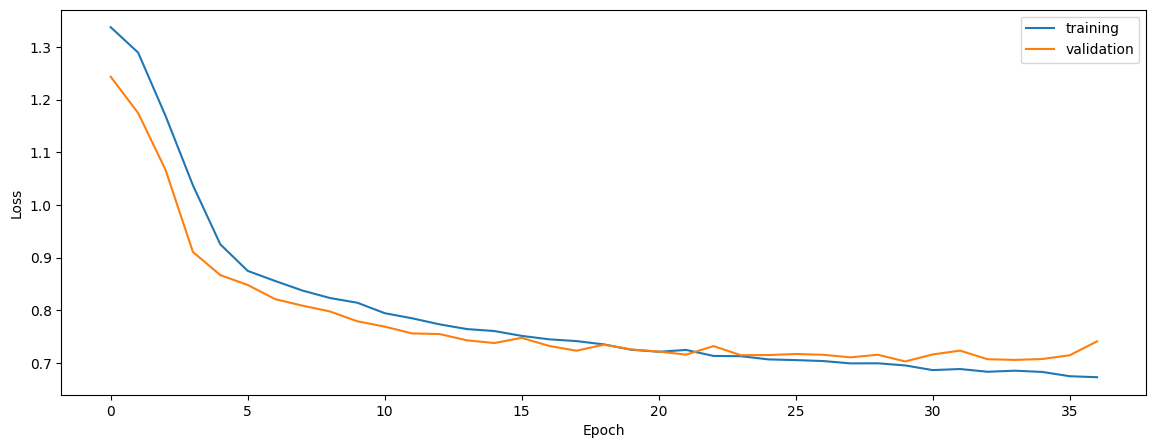

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


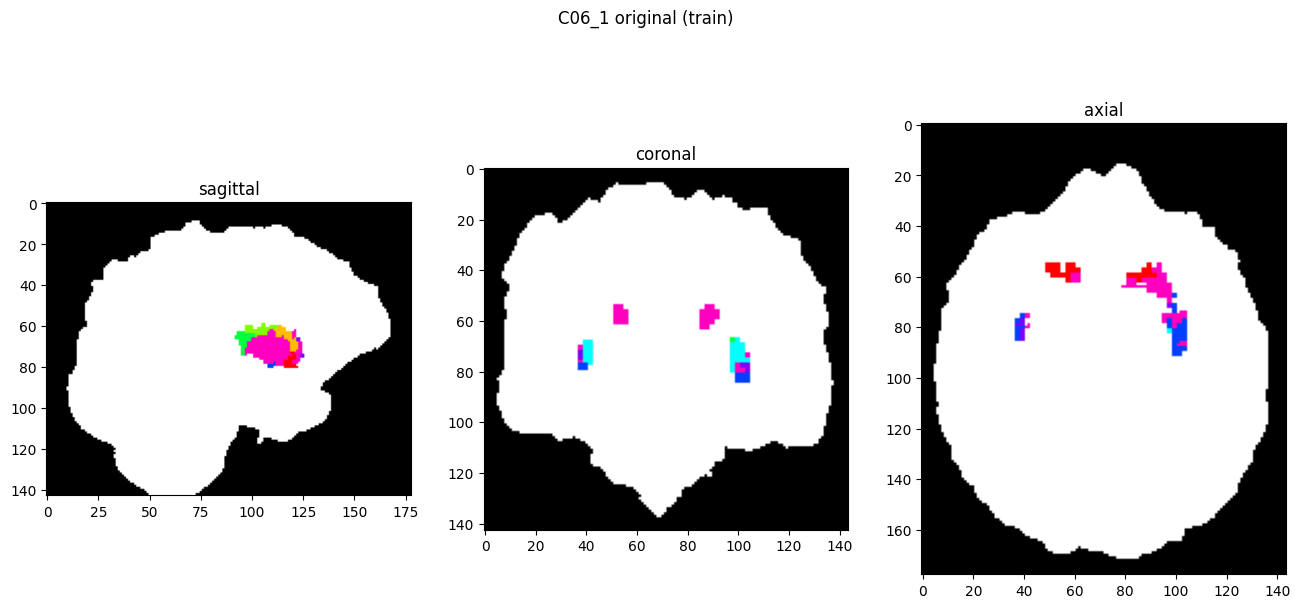

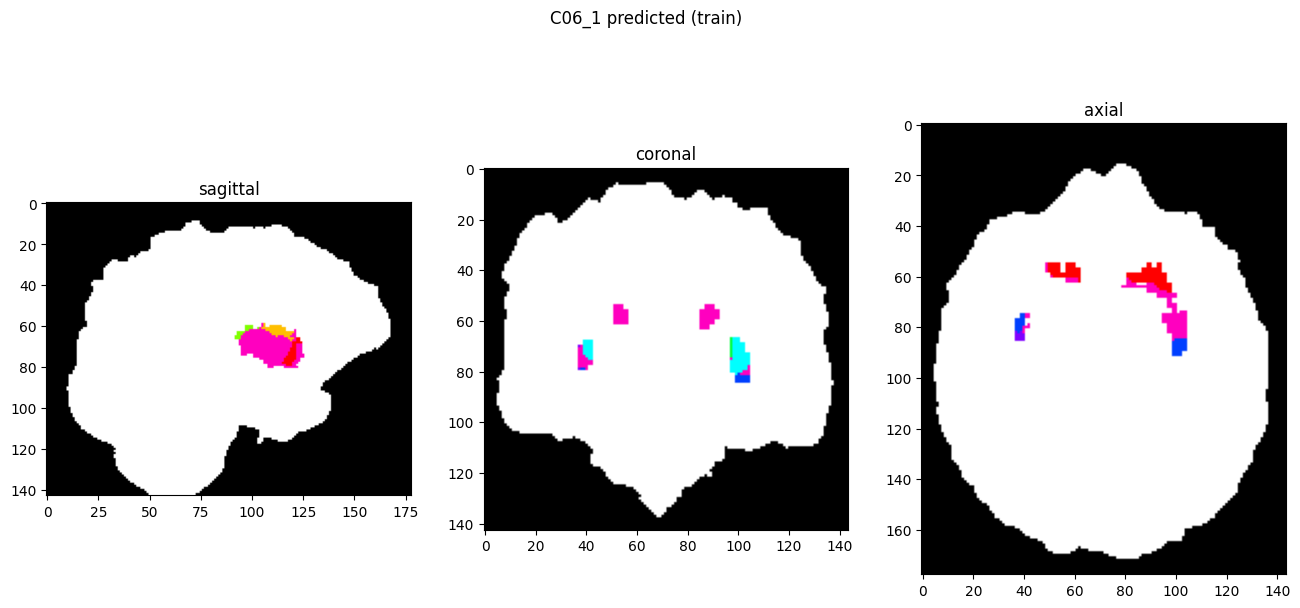

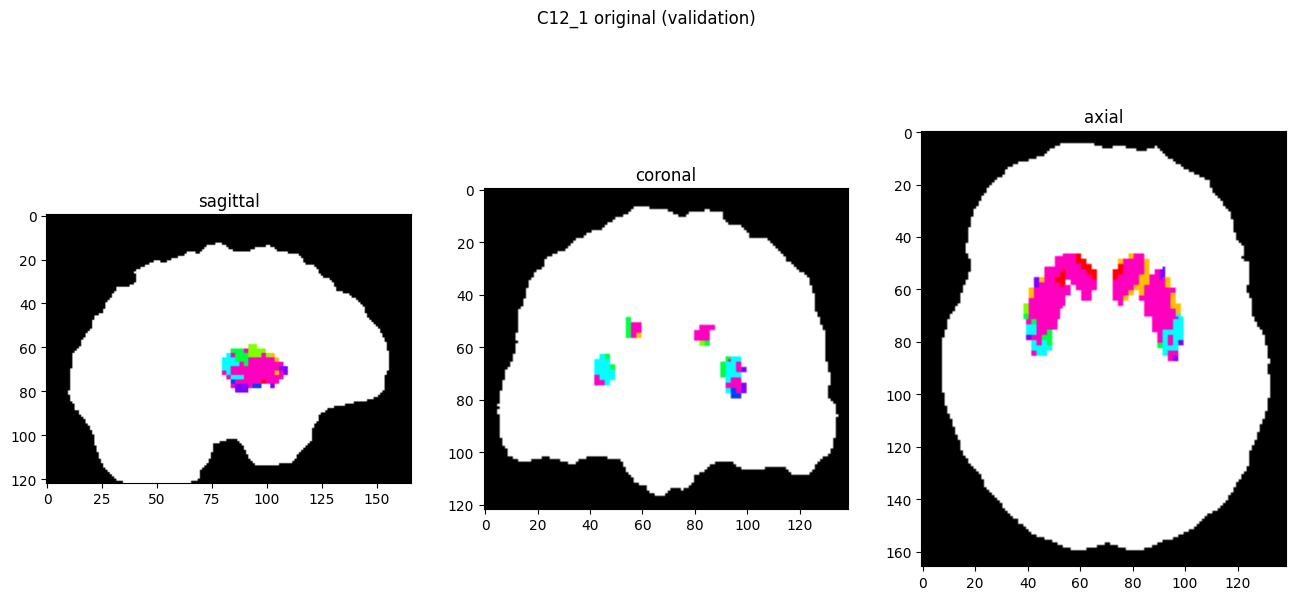

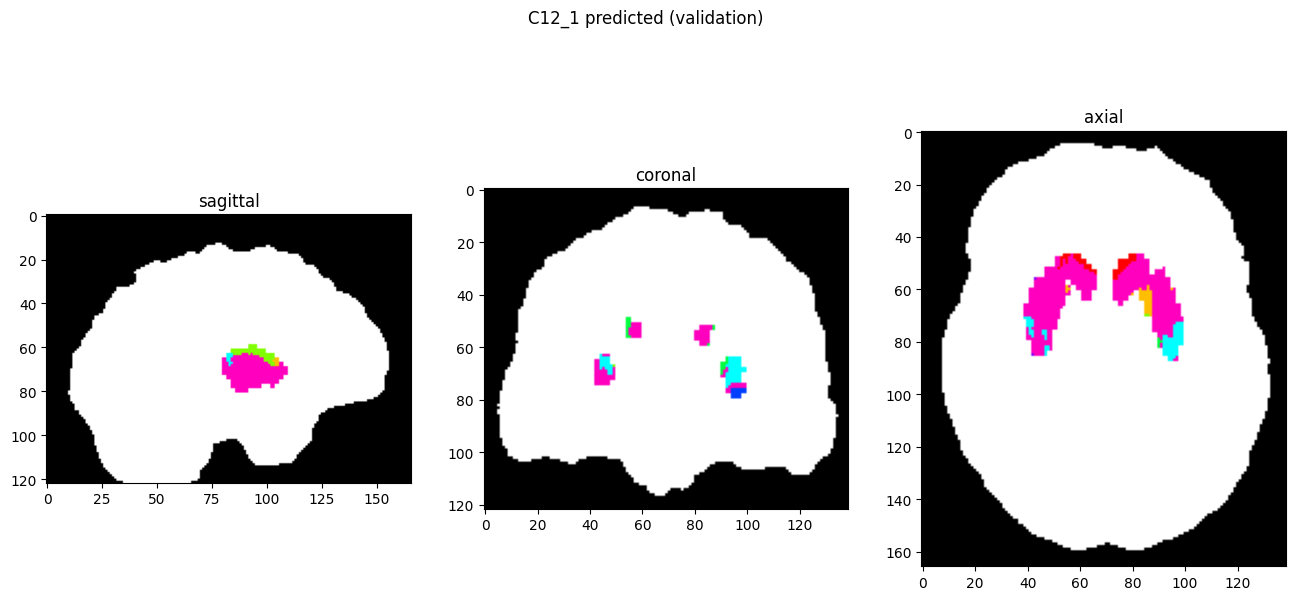

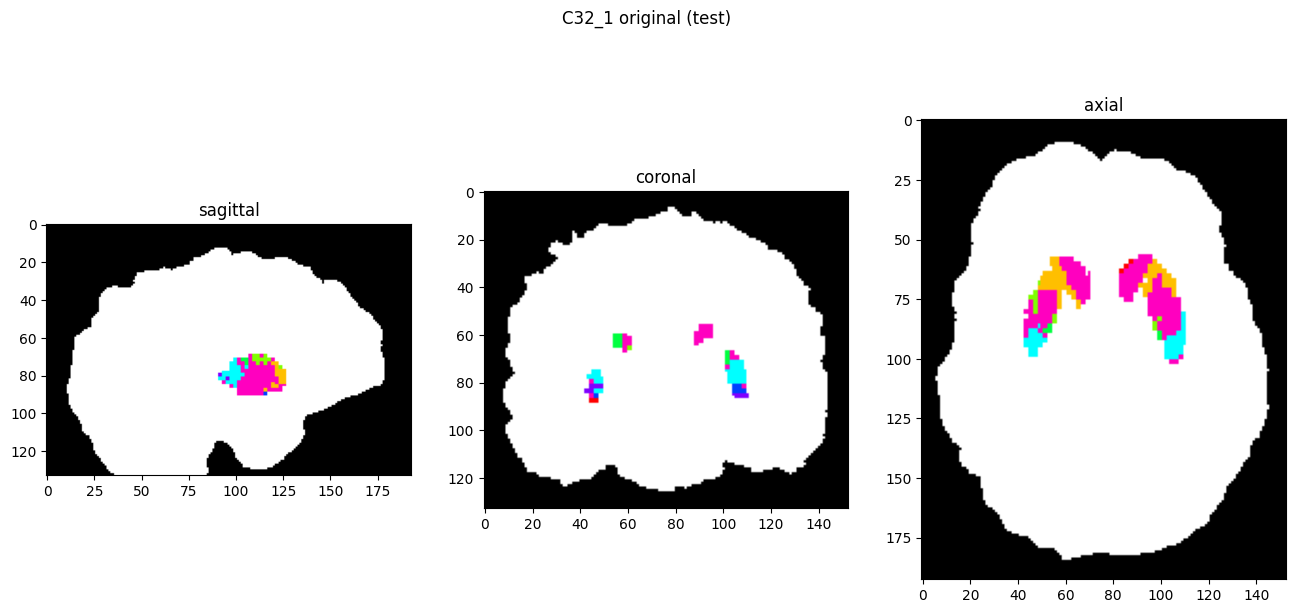

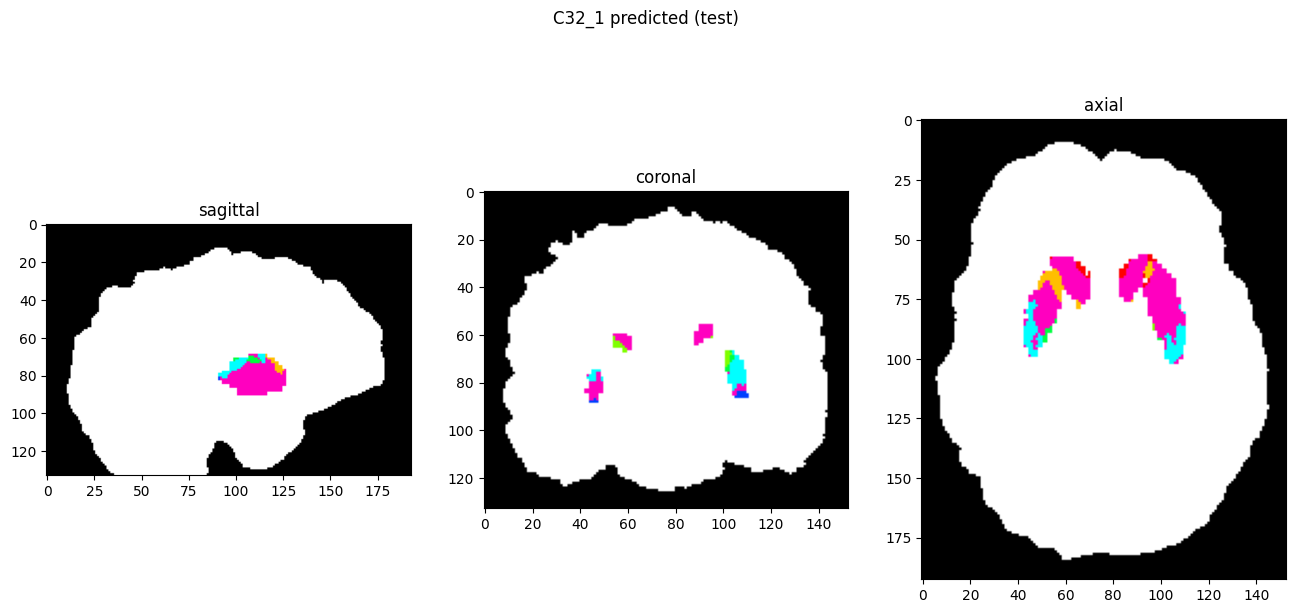

In [10]:
showResults(model, gen, threshold=0)